# Stephen King Novel NLP

## Imports

In [145]:
import pandas as pd
import numpy as np
from IPython import display
from pymongo import MongoClient
import os
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.util import ngrams
import operator
from gensim import corpora, models, similarities, matutils
from sklearn import datasets
import json
import spacy 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from afinn import Afinn
import random
import scipy
from scipy.signal import spectrogram
from importlib import reload
from scipy.fftpack import fft
from statsmodels.nonparametric.smoothers_lowess import lowess


# gensim
from gensim import corpora, models, similarities, matutils
from gensim.models import LdaModel

# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


display.clear_output(wait=True)
from config import user_name,password,ip
from epub_conversion.utils import open_book

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 20, 10

## Stoplist

In [2]:
stoplist = stopwords.words('english')
stoplist += ['.', ',', '(', ')', "'", '"']
#stoplist = set(stoplist)

## Functions

### Manual Word Count

In [3]:
def clean_text(row):
    text = row['content'].lower()
    text = text.strip('\n')
    return text

### Manual Word Count

In [4]:
def book_word_count(book,n,stoplist=stoplist):
    text = clean_text(book)
    words = [''.join(words) for words in text.split()]
    title = book['title']
    counter = Counter()
    n = n
    words = [w for w in words if w not in stoplist]
    bigrams = ngrams(words, n)
    counter += Counter(bigrams)
    sorted_counter = sorted(counter.items(), key=operator.itemgetter(1),reverse=True)
    return title, sorted_counter

### Count Vectorizer Function

In [5]:
def book_cv(dtbooks,stoplist):
    cv = CountVectorizer(stop_words=stoplist,token_pattern="\\b[a-z][a-z]+\\b")
    print(type(dtbooks[0]))
    cv.fit(dtbooks)
    x = cv.transform(dtbooks)
    x_back = x.toarray()
    df = pd.DataFrame(x_back, columns=cv.get_feature_names())
    counts = cv.transform(dtbooks).transpose()
    print(counts.shape)
    corpus = matutils.Sparse2Corpus(counts)
    id2word = dict((v, k) for k, v in cv.vocabulary_.items())
    return df,corpus,id2word

### Display Topics

In [89]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
#     topic_words = []
#     for r in model.components_:
#         a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
#         topic_words.append([books[e[1]-1] for e in a])
#     return topic_words

In [7]:
# def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
#     for topic_idx, topic in enumerate(H):
#         print("Topic %d:" % (topic_idx))
#         print(" ".join([feature_names[i]
#                         for i in topic.argsort()[:-no_top_words - 1:-1]]))
#         top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
#         for doc_index in top_doc_indices:
#             print(documents[doc_index])

### Cleanup

In [8]:
def cleanup(token, lower = True):
    if lower:
       token = token.lower()
    return token.strip()

### Entity Detection

In [9]:
def ie_preprocess(document):
    document = ' '.join([i for i in document.split() if i not in stoplist])
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    return sentences

In [10]:
def extract_names(document):
    names = []
    sentences = ie_preprocess(document)
    for tagged_sentence in sentences:
        for chunk in nltk.ne_chunk(tagged_sentence):
            if type(chunk) == nltk.tree.Tree:
                if chunk.label() == 'PERSON':
                    names.append(' '.join([c[0] for c in chunk]))
    return names

### Tokenize and Stem

In [11]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [12]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

### Sentiment

In [13]:
def sentiment(filename):
    with open (filename, "r") as myfile:
        text=myfile.read().replace('\n', ' ')
        blob = TextBlob(text)       
        tot = 0.0
        sent = []        
        afinn = Afinn()
        for sentence in blob.sentences:            
            senti = afinn.score(str(sentence))        
            sent.append(senti)   
        return sent

### Sentiment Plot

In [14]:
def sentiplot(filename, title):
    fig = plt.figure()
    sent= sentiment(filename)    
    plt.plot(sent,label=title)
    plt.ylabel("Cumulative Emotional Valence")
    plt.xlabel("Sentence #")    
    plt.legend()


## Data Processing

**Create a dictionary from all books**

In [15]:
# book_list = []
# book_dict = {}
# path = "/Users/xavier/dev/metis/fletcher/books/"
# for file in os.listdir(path):
#     if file.endswith(".txt"):
#         clean_name = file.replace(" - Stephen King.txt","")
#         book_dict[clean_name] = open(path+file, "r").read()
#         book_list.append(clean_name)

In [16]:
# # Insert the books into mongo db
# clean_list = []
# for k,v in book_dict.items():
#     try:
#         year = re.search("[Cc]opyright ©\s*.*_*(\d{4}).*Stephen King|[Cc]opyright ©\s.*Stephen King.*_*(\d{4})|[Cc]opyright ©\s*.*_*(\d{4}).*Richard Bachman|[Cc]opyright ©\s.*Richard Bachman.*_*(\d{4})",v).group(0) # get copyright year from book text
#         year = re.search("(\d{4})",year).group(0)
#     except:
#         year = ""
#     try:
#         isbn = re.search(".*ISBN+:*(\d*.*)",v)[1].split(" ")
#         isbn = max(isbn, key=len)
#     except:
#         isbn = ""
#     try:
#         start = v.find('******start_of_file******')+25
#         end = v.find('******end_of_file******')
#         text = v[start:end]
#     except:
#         text = ""
        
#     doc = {"title":k,"year":year,'isbn':isbn,"content":text}
#     clean_list.append(doc)
#     #print(doc['title'],doc['isbn'])
#     #print(doc['title'],doc['year'])
#     #db.books.insert_one(doc)

In [17]:
# len(clean_list)

In [18]:
# #pd.DataFrame(a, index=['i',])
# df = pd.DataFrame(clean_list)

In [19]:
# df.to_pickle('books.pkl')

### Import Pickle

In [20]:
df = pd.read_pickle('books.pkl')

In [21]:
df.columns.tolist()

['content', 'isbn', 'title', 'year']

In [22]:
df.head()

,content,isbn,title,year
0,d by “Duel”\n\nJoe Hill and Stephen King\n\n\n...,9780062215956,Throttle,2009
1,TS\n\n\n\nCover Page\n\nTitle Page\n\n\n\nIntr...,978-0-385-52884-9,Night Shift,1976
2,this Scribner eBook.\n\n\n\n* * *\n\n\n\nSign...,0-7432-0467-0,Riding the Bullet,2000
3,Page\n\nCopyright Page\n\nDedication\n\n\n\n\...,978-1-101-13813-7,Roadwork,1981
4,dication\n\nIntroduction\n\nAuthor’s Note\n\n\...,978-0-385-52822-1,Salem's Lot,1975


In [23]:
document = df.iloc[28]['content']

In [24]:
# df['content'] = df.content.apply(lambda x: x.lower())
# df['content'] = df.content.apply(lambda x: x.strip("\n"))

In [25]:
# words = [''.join(words) for words in gs_text.split()]
# vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1))
# doc_vectors = vectorizer.fit_transform(documents)

### Character extraction test

In [26]:
characters = extract_names(document)

In [27]:
characters

['Penguin Book',
 'Stephen King',
 'Penguin Putnam',
 'Penguin Books',
 'Penguin Putnam',
 'Penguin Putnam',
 'STEPHEN',
 'Carrie',
 'Salem',
 'Christine Pet Sematary Cycle Werewolf',
 'Peter Straub',
 'Dolores Claiborne Insomnia Rose Madder',
 'Wizard Glass Bag Bones',
 'Tom Gordon Dreamcatcher Black House',
 'Peter Straub',
 'Skeleton Crew',
 'Atlantis Everything',
 'Eventual SCREENPLAYS Creepshow Cat',
 'Eye Silver Bullet Maximum Overdrive Pet Sematary Golden',
 'Century',
 'Who',
 'Merrys Pippins',
 'Max Yasgur',
 'Great Woodstock Music Festival',
 'Gandalfs',
 'Tolkien',
 'Stephen Donaldson',
 'Terry Brooks',
 'Tolkien',
 'Tolkien',
 'Tricky Dick Nixon',
 'Mr. Tolkien',
 'Look',
 'Stevie',
 'Nineteen',
 'Bob Seger',
 'Patrol Boy',
 'Bad Lieutenant',
 'Patrol Boy',
 'Mine',
 'Stephen',
 'God',
 'Tolkien',
 'Pall Malls',
 'Patrol Boy',
 'Maine',
 'Sergio Leone',
 'Bad',
 'Ugly',
 'Tolkien',
 'Leone',
 'Clint',
 'Lee Van Cleef',
 'Wizard Glass',
 'Leone',
 'Phoenix',
 'Seems',
 'Patr

In [28]:
characters = [s.split(" ") for s in characters]

In [29]:
flat_list = [item for sublist in characters for item in sublist]

In [30]:
flat_list

['Penguin',
 'Book',
 'Stephen',
 'King',
 'Penguin',
 'Putnam',
 'Penguin',
 'Books',
 'Penguin',
 'Putnam',
 'Penguin',
 'Putnam',
 'STEPHEN',
 'Carrie',
 'Salem',
 'Christine',
 'Pet',
 'Sematary',
 'Cycle',
 'Werewolf',
 'Peter',
 'Straub',
 'Dolores',
 'Claiborne',
 'Insomnia',
 'Rose',
 'Madder',
 'Wizard',
 'Glass',
 'Bag',
 'Bones',
 'Tom',
 'Gordon',
 'Dreamcatcher',
 'Black',
 'House',
 'Peter',
 'Straub',
 'Skeleton',
 'Crew',
 'Atlantis',
 'Everything',
 'Eventual',
 'SCREENPLAYS',
 'Creepshow',
 'Cat',
 'Eye',
 'Silver',
 'Bullet',
 'Maximum',
 'Overdrive',
 'Pet',
 'Sematary',
 'Golden',
 'Century',
 'Who',
 'Merrys',
 'Pippins',
 'Max',
 'Yasgur',
 'Great',
 'Woodstock',
 'Music',
 'Festival',
 'Gandalfs',
 'Tolkien',
 'Stephen',
 'Donaldson',
 'Terry',
 'Brooks',
 'Tolkien',
 'Tolkien',
 'Tricky',
 'Dick',
 'Nixon',
 'Mr.',
 'Tolkien',
 'Look',
 'Stevie',
 'Nineteen',
 'Bob',
 'Seger',
 'Patrol',
 'Boy',
 'Bad',
 'Lieutenant',
 'Patrol',
 'Boy',
 'Mine',
 'Stephen',
 'G

In [31]:
characters = set(flat_list)
characters = list(characters)

In [32]:
stoplist = list(stoplist)
stoplist.extend(characters)
stoplist = set(stoplist)

In [33]:
print(stoplist)

{'Feldon', 'Sterile', 'wouldn', 'Rose', 'Walk', 'Creepshow', 'Yar', 'Wind', 'Chambers', 'Him', 'against', 'he', 'Ball', 'Beams', 'Tet', 'Ro', 'that', 'Golden', 'Barony', 'Stephen', 'the', 'Sargasso', 'Pittston', 'God', 'Wizard', 'Jeremiah', 'Bad', 'Hai', 'to', 'Gramma', 'Screw', 're', 'you', 'Someone', 'Which', 'needn', 'Fresh', 'Tears', 'Does', 'Vampire', 'Mice', 'Scribner', 'here', 'on', 'Zorro', 'Reaptide', 'ain', 'Thomas', 'Wake', 'Robeson', 'hers', 'Cadillac', 'Cuthbert', 'off', 'Whitman', 'same', 'Outside', 'itself', 'Ugly', 'Jubal', 'then', 'at', 'Ulysses', 'Allgood', 'Paul', 'Wipe', 'Larchies', 'can', 'Lee', 'Hello', 'Varney', 'Joshua', 'has', 'Book', 'those', 'there', 'Peddler', 'Broken', 'Fools', 'a', 'how', 'will', 'above', 'Hit', 'House', 'All', 'Deschain', 'when', 'Mr.', 'Handcar', 'Bag', 'didn', 'Van', 'or', 'Good', 'Soobie', 'no', 'Savior', 'Jesus', 'Serpents', 'Stevie', 'Soldier', 'Seven', 'Texas', 'Woodstock', 'Cort', 'Patches', 'me', 've', 'Tolkien', 'Jonson', 'an', '

### Word Tokenize

In [34]:
# df['content'] = df.content.apply(lambda x: word_tokenize(x))

In [35]:
df.head()

,content,isbn,title,year
0,d by “Duel”\n\nJoe Hill and Stephen King\n\n\n...,9780062215956,Throttle,2009
1,TS\n\n\n\nCover Page\n\nTitle Page\n\n\n\nIntr...,978-0-385-52884-9,Night Shift,1976
2,this Scribner eBook.\n\n\n\n* * *\n\n\n\nSign...,0-7432-0467-0,Riding the Bullet,2000
3,Page\n\nCopyright Page\n\nDedication\n\n\n\n\...,978-1-101-13813-7,Roadwork,1981
4,dication\n\nIntroduction\n\nAuthor’s Note\n\n\...,978-0-385-52822-1,Salem's Lot,1975


### Omit Stop Words

In [36]:
# df['content'] = df.content.apply(lambda x: [word for word in x if word not in stoplist])

In [37]:
# df.head()

### Convert tokens back to a long string

In [38]:
# df['content'] = df.content.apply(lambda x: " ".join(x))

In [39]:
# df.head()

### Sentence Tokenize

In [40]:
df['content'] = df.content.apply(lambda x: sent_tokenize(x))

In [41]:
df.head()

,content,isbn,title,year
0,[d by “Duel”\n\nJoe Hill and Stephen King\n\n\...,9780062215956,Throttle,2009
1,[TS\n\n\n\nCover Page\n\nTitle Page\n\n\n\nInt...,978-0-385-52884-9,Night Shift,1976
2,"[ this Scribner eBook., * * *\n\n\n\nSign up f...",0-7432-0467-0,Riding the Bullet,2000
3,[ Page\n\nCopyright Page\n\nDedication\n\n\n\n...,978-1-101-13813-7,Roadwork,1981
4,[dication\n\nIntroduction\n\nAuthor’s Note\n\n...,978-0-385-52822-1,Salem's Lot,1975


### Paragraph Tokenize

### Stem Words

In [42]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [43]:
df['content'] = df.content.apply(lambda x: [stemmer.stem(word) for word in x])

In [44]:
df.head()

,content,isbn,title,year
0,[d by “duel”\n\njoe hill and stephen king\n\n\...,9780062215956,Throttle,2009
1,[ts\n\n\n\ncover page\n\ntitle page\n\n\n\nint...,978-0-385-52884-9,Night Shift,1976
2,"[ this scribner ebook., * * *\n\n\n\nsign up f...",0-7432-0467-0,Riding the Bullet,2000
3,[ page\n\ncopyright page\n\ndedication\n\n\n\n...,978-1-101-13813-7,Roadwork,1981
4,[dication\n\nintroduction\n\nauthor's note\n\n...,978-0-385-52822-1,Salem's Lot,1975


In [45]:
titles = df.title

In [46]:
books = df.content

In [47]:
books[4][:500]

["dication\n\nintroduction\n\nauthor's note\n\n\n\n'salem's lot\n\n\n\nprologue\n\npart one\n\nthe marsten house\n\nchapter one ben (i)\n\nchapter two susan (i)\n\nchapter three the lot (i)\n\nchapter four danny glick and others\n\nchapter five ben (ii)\n\nchapter six the lot (ii)\n\nchapter seven matt\n\npart two\n\nthe emperor of ice cream\n\nchapter eight ben (iii)\n\nchapter nine susan (ii)\n\nchapter ten the lot (iii)\n\nchapter eleven ben (iv)\n\nchapter twelve mark\n\nchapter thirteen father callahan\n\npart three\n\nthe deserted village\n\nchapter fourteen the lot (iv)\n\nchapter fifteen ben and mark\n\nepilogue\n\n\n\none for the road\n\njerusalem's lot\n\ndeleted scenes\n\n\n\nafterword\n\ncopyright\n\n\n\n\n\nfor naomi rachel king\n\n“…promises to keep.”\n\n\n\n\n\nintroduction to 'salem's lot\n\nby stephen king\n\nmy father-in-law is now retired, but when he was working for maine's department of human services, he had a very cool sign in his office.",
 'it said once i had n

### Lower Stop List

In [48]:
stoplist = [x.lower() for x in stoplist]

### Convert sentences to Rows

In [137]:
s = df.apply(lambda x: pd.Series(x['content']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'content'
sentDF = df.drop('content', axis=1).join(s)

In [138]:
sentDF.head()

,isbn,title,year,content
0,9780062215956,Throttle,2009,d by “duel”\n\njoe hill and stephen king\n\n\n...
0,9780062215956,Throttle,2009,"finally, in the early afternoon, they turned i..."
0,9780062215956,Throttle,2009,the overlapping thunder of their engines shook...
0,9780062215956,Throttle,2009,they drew up together among parked long-haul t...
0,9780062215956,Throttle,2009,"race adamson had led them the whole way, his h..."


In [139]:
cujoDF = sentDF.loc[sentDF['title'] == 'Cujo']

In [140]:
cujoDF

,isbn,title,year,content
60,978-1-101-13806-9,Cujo,1981,page\n\ncopyright page\n\ndedication\n\n\n\n\...
60,978-1-101-13806-9,Cujo,1981,.
60,978-1-101-13806-9,Cujo,1981,.
60,978-1-101-13806-9,Cujo,1981,"cujo\n\nit happens innocently enough, but does..."
60,978-1-101-13806-9,Cujo,1981,"a big, friendly dog chases a rabbit into a hid..."
60,978-1-101-13806-9,Cujo,1981,a terrified four-year-old boy sees his bedroom...
60,978-1-101-13806-9,Cujo,1981,the little maine town of castle rock is about ...
60,978-1-101-13806-9,Cujo,1981,“hits the jugular.”\n\n—new york times\n\n\n\n...
60,978-1-101-13806-9,Cujo,1981,"250 camberwell road, camberwell."
60,978-1-101-13806-9,Cujo,1981,victoria 3124.


In [52]:
books = sentDF.content

### Processing Sentences

In [53]:
# totalvocab_stemmed = []
# totalvocab_tokenized = []
# for i in books:
#     allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
#     totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
#     allwords_tokenized = tokenize_only(i)
#     totalvocab_tokenized.extend(allwords_tokenized)

In [54]:
# totalvocab_stemmed

In [55]:
titles = sentDF.title
#titles

In [56]:
len(books)

748650

## Sentiment Analysis

In [57]:
dfRaw = pd.read_pickle('books.pkl')

In [58]:
#Cujo Test
cujo = dfRaw.loc[dfRaw['title'] == 'Cujo']

In [59]:
cujo.to_pickle('cujodf.pkl')

In [60]:
cujo.content

60     Page\n\nCopyright Page\n\nDedication\n\n\n\n\...
Name: content, dtype: object

In [61]:
TextBlob(str(cujo.content)).sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [62]:
cujoDF['sentiment'] = cujoDF.content.apply(lambda x: TextBlob(x).sentiment[0])

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


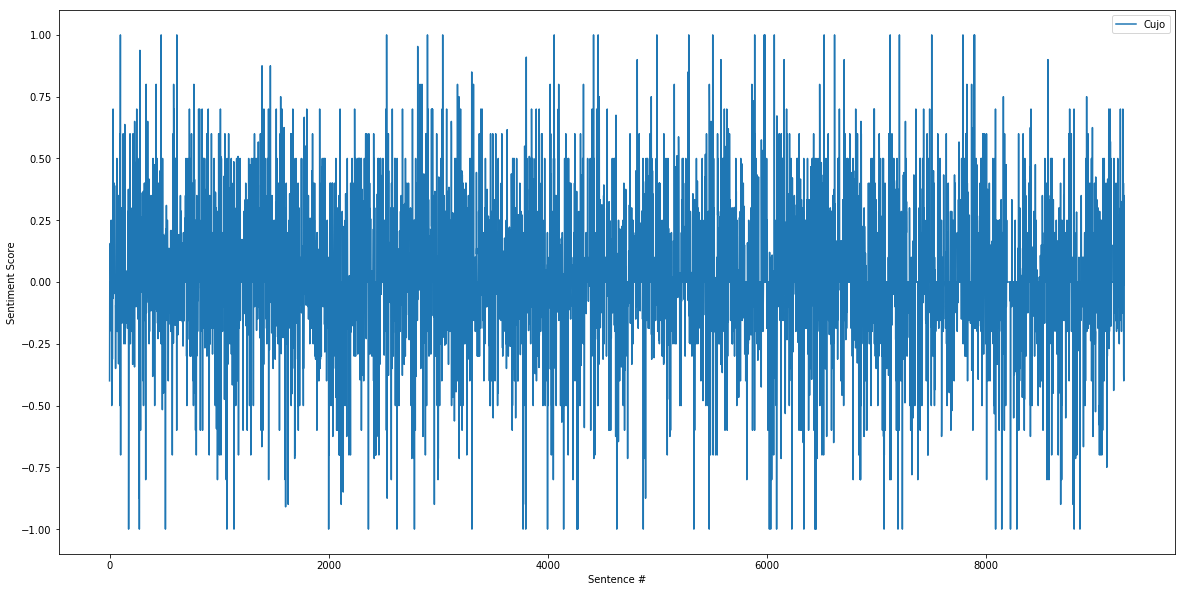

In [63]:
sent = list(cujoDF.sentiment)
title = 'Cujo'
fig = plt.figure()
plt.plot(sent,label=title)
plt.ylabel("Sentiment Score")
plt.xlabel("Sentence #")    
plt.legend()

In [65]:
# sentiplot('books/Girl Who Loved Tom Gordon_ A Novel, The - Stephen King.txt','Girl who loved tom gordon')

In [73]:
cumsum_vec = np.cumsum(np.insert(sent, 0, 0)) 
ma_vec = (cumsum_vec[300:] - cumsum_vec[:-300]) / 300

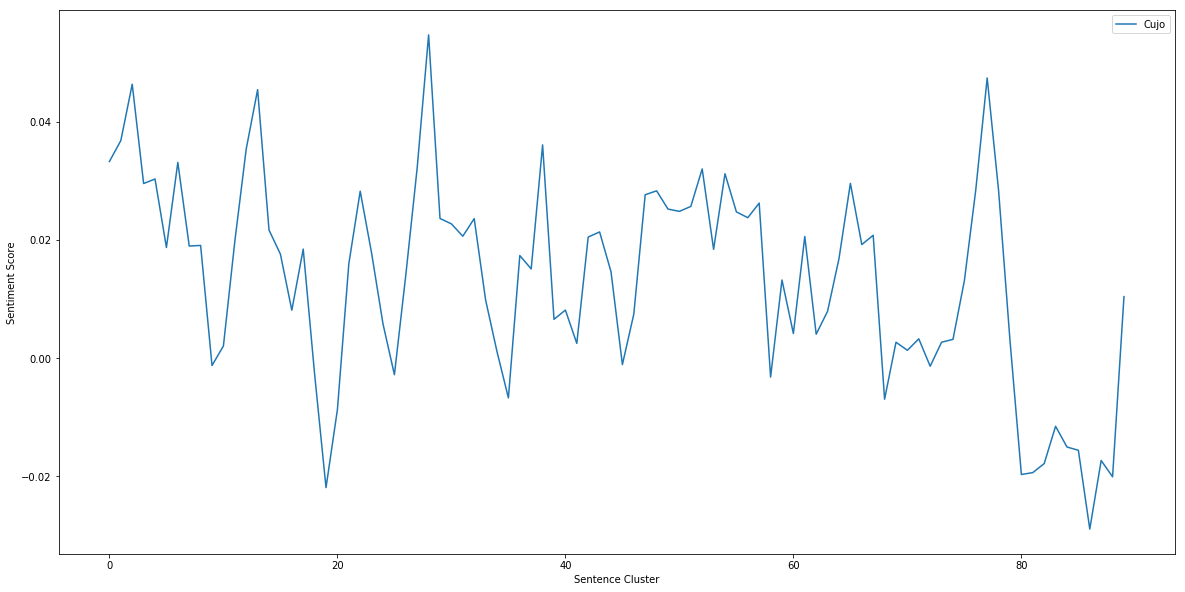

In [91]:
title = 'Cujo'
fig = plt.figure()
plt.plot(ma_vec[::100],label=title)
plt.ylabel("Sentiment Score")
plt.xlabel("Sentence Cluster")    
plt.legend()

In [ ]:
sent

In [67]:
sent_group = []
for x in range(0, len(sent), 300):
     sent_group.append( sum(sent[x:x+300])/300 )

In [69]:
len(sent_group)

31

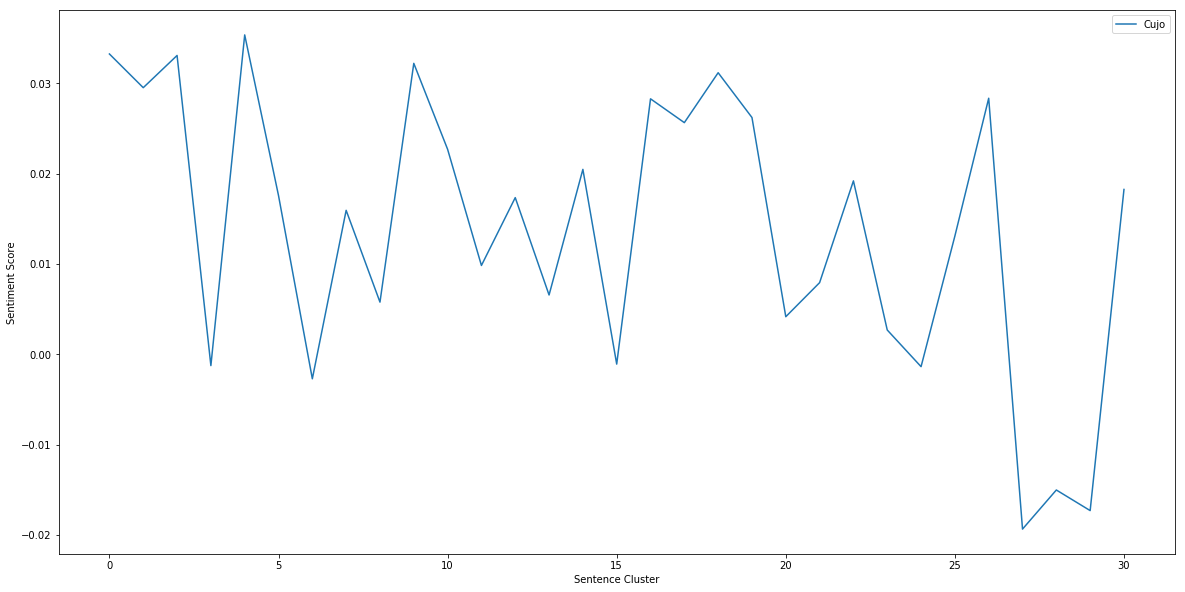

In [92]:
title = 'Cujo'
fig = plt.figure()
plt.plot(sent_group,label=title)
plt.ylabel("Sentiment Score")
plt.xlabel("Sentence Cluster")    
plt.legend()

### Smoothing

In [167]:
lowX = list(range(1,len(sent)+1))
print(len(sent),len(lowX))
low_plot = lowess(sent,lowX,frac=.1,return_sorted=False)

9262 9262


In [168]:
low_plot

array([  3.68503313e-08,   3.66196209e-08,   3.63887654e-08, ...,
        -2.58071612e-06,  -2.59462443e-06,  -2.60852202e-06])

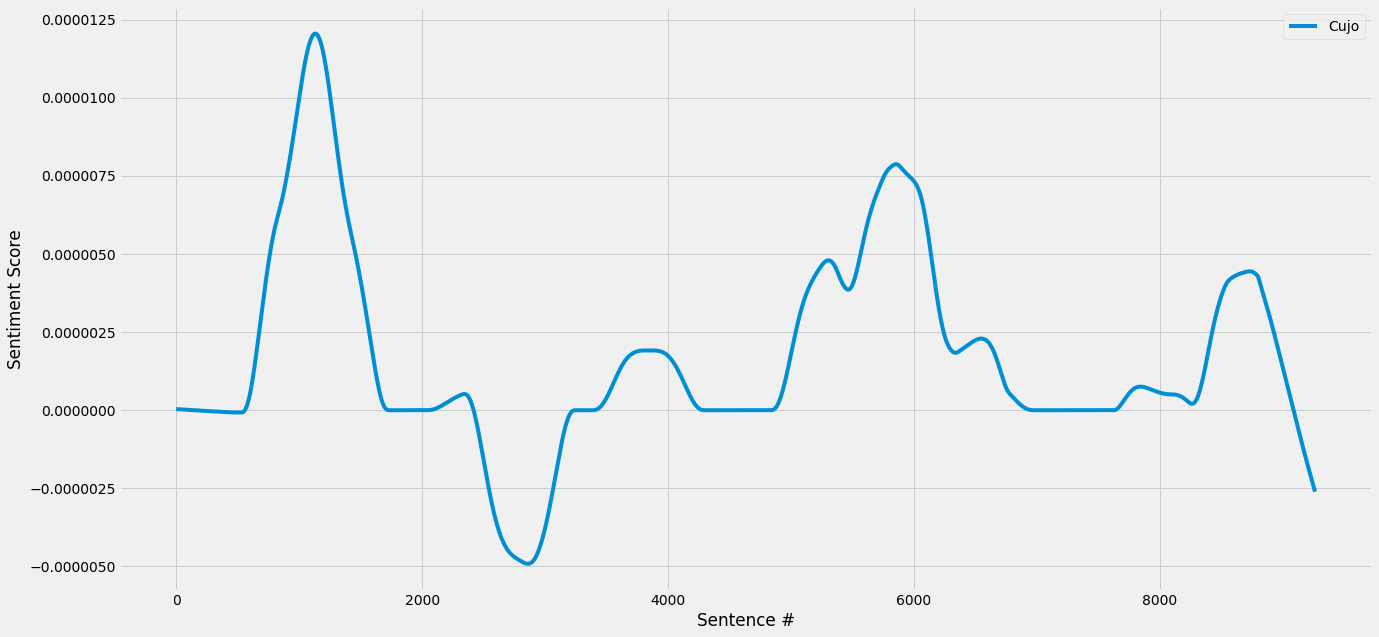

In [169]:
title = 'Cujo'
fig = plt.figure()
plt.plot(low_plot,label=title)
plt.ylabel("Sentiment Score")
plt.xlabel("Sentence #")    
plt.legend()

In [166]:
sent = list(cujoDF.sentiment)
title = 'Cujo'
fig = plt.figure()
plt.plot(sent,label=title)
plt.ylabel("Sentiment Score")
plt.xlabel("Sentence #")    
plt.legend()

AttributeError: 'DataFrame' object has no attribute 'sentiment'

## Test Method

In [69]:
title_list = list(dfRaw.title)

In [70]:
book_list = list(dfRaw.content)

In [71]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in book_list:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [72]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 10445058 items in vocab_frame


### TFID Test

In [75]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                 min_df=0.2, stop_words=stoplist,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(book_list) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

(68, 28201)


In [76]:
tf_terms = tfidf_vectorizer.get_feature_names()

### NMF Test

In [90]:
nmf_test = NMF(n_components=20, init='random')
fit_test = nmf_test.fit_transform(tfidf_matrix)

In [91]:
display_topics(nmf_test,tf_terms,10)

Topic 0:
anni mike fred carolina miseri wheelchair hardi dean carni kite
Topic 1:
andi charli chris teddi andi said irv mcgee morri momma norma
Topic 2:
eddi susannah oy ye aye gunsling ka calla patrick riddl
Topic 3:
chapter chapter chapter chapter chapter alic chapter barbi dan brutal cell phone denni gerald
Topic 4:
cal morrison boon jim harold ross calvin lawnmow jackson corn
Topic 5:
danni dan catcher anderson overlook titan toni locker al pinki
Topic 6:
pete morri bradi holli merced rachel carla jimmi station wagon owen
Topic 7:
henri omaha sheriff jone poppa lester owen beadi donni ellen
Topic 8:
jacob jami coven astrid hugh nell con aye ross ye
Topic 9:
bobbi ted ruth anderson carol elli willi speedi soupi derri
Topic 10:
rosi norman tad vic hale bull harley donna cujo seed
Topic 11:
billi miller mist billi said norm dan tentacl houston reg randi
Topic 12:
loui rachel elli norma station wagon carla al pete doug dalla
Topic 13:
ralph harold larri nick glen ed helen aura steve de

### Vizualize NMF

In [168]:
x = []
y = []
order_model = nmf.components_.argsort()[:, ::-1]
components = nmf.components_

for i in range(len(components)):
    tempx = []
    tempy = []
    for index in order_model[i, :20]:
        tempx.append(str(vocab_frame.loc[tf_terms[index].split(' ')]
                     .values.tolist()[0][0]))
        tempy.append(components[i][index])
    x.append(tempx)
    y.append(tempy)

IndexError: list index out of range

In [ ]:
sns.set(font_scale=1)
f, axarr = plt.subplots(10, figsize=(8,25), sharex=False)
for i in range(10):
    title = "KMeans Topic %d" % i
    figsize(6,1.25)
    sns.set(style="dark")
#     sns.set_color_codes("muted") x[i]
    sns.barplot(x=x_k[i], y=y_k[i], color='black', ax=axarr[i])
    axarr[i].set_title(title)
    axarr[i].set_ylim([0,0.6])
#     plt.xticks(rotation=90)
    sns.despine(left=True, bottom=True)
for ax in f.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)
plt.tight_layout(h_pad=3)

### Clustering Test

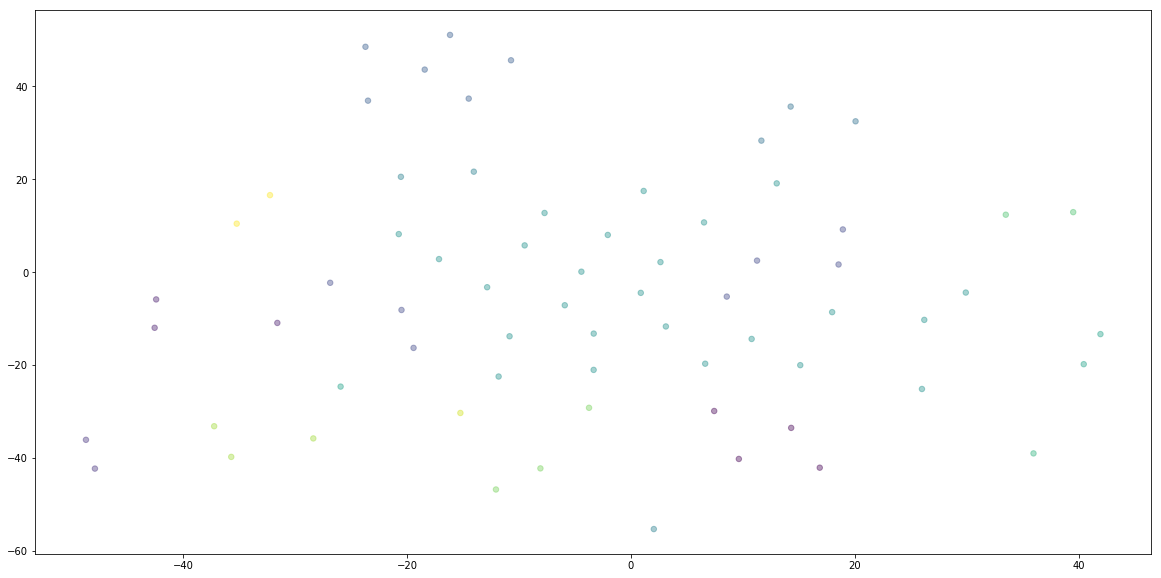

In [97]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0)
results = tsne_model.fit_transform(fit_test) 

def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

x, y = get_coords(results)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(fit_test)

# Scatter plot with colouring by kmeans labels:
plt.scatter(x, y, alpha=0.4, c=kmeans.labels_, marker='o', s=30);

In [169]:
num_clusters = 10

km = KMeans(n_clusters=8)

km.fit(nmf_test)

clusters = km.labels_.tolist()

In [170]:
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [172]:
test_dict = { 'title': title_list, 'content': book_list, 'cluster': clusters}

frame = pd.DataFrame(test_dict, index = [clusters] , columns = ['title', 'cluster'])

In [173]:
frame.cluster.value_counts()

0    43
1    16
4     6
2     2
3     1
Name: cluster, dtype: int64

### Spectral Clustering

In [157]:
from sklearn.cluster import spectral_clustering

In [159]:
sc = spectral_clustering(n_clusters=8,affinity='cosine')
sc.fit(tfidf_matrix)
sclusters = sc.labels.tolist()

AttributeError: 'str' object has no attribute 'ndim'

## Model Fits

### Count Vectorizer

In [64]:
cv = CountVectorizer(stop_words=stoplist,max_df=.002,token_pattern="\\b[a-z][a-z]+\\b")
x = cv.fit_transform(books)
cv_feature_names = cv.get_feature_names()
#x = cv.transform(books)

In [65]:
x.shape

(748650, 72769)

In [59]:
# x_back = x.toarray()

In [60]:
# bookDF = pd.DataFrame(x_back, columns=cv.get_feature_names())

In [61]:
# bookDF.head()

### TFIDF Vectorizer

In [84]:
tf = TfidfVectorizer(stop_words=stoplist,use_idf=True,max_df=.002,token_pattern="\\b[a-z][a-z]+\\b")
x2 = tf.fit_transform(books)
tf_feature_names = tf.get_feature_names()

In [85]:
x2.shape

(748650, 72769)

### Cosine Similarity

In [ ]:
dist = 1 - cosine_similarity(x2)

### NMF

#### With Count Vectorizer

In [80]:
# nmf = NMF(n_components=20, init='random')
# fit = nmf.fit_transform(x)

In [81]:
# display_topics(nmf,cv_feature_names,10)

#### With TFIDF

In [86]:
nmf2 = NMF(n_components=20, init='random')
nmf_fit = nmf2.fit_transform(x2)

In [87]:
# no_top_words = 5
# no_top_documents = 2

In [90]:
display_topics(nmf2,tf_feature_names,10)

Topic 0:
jonesy thinks beaver duddits beav wants hospital mccarthy sit hurry
Topic 1:
tonight tomorrow today meet nine wish saved game finish meeting
Topic 2:
christ sake dear holy almighty steve muttered wish sweet hurry
Topic 3:
stu nick larry harold brian glen shrugged fran frannie agreed
Topic 4:
wondered problem garraty mcvries briefly possible larry mad callahan richards
Topic 5:
funny huh laughing dreams damn circumstances ideas weird joke agreed
Topic 6:
chance fat gets fair giving finish catch lose reply likely
Topic 7:
alive glad buried tomorrow lucky eaten fully hungry burned talked
Topic 8:
shouted beverly laughing bitch ear steve grabbed todd garraty surprise
Topic 9:
mom thanks brian ted honey gets family worried loved sister
Topic 10:
wolf trouble live easy drink changed sick dan anymore today
Topic 11:
tired garraty sick asleep pale frightened makes sounds confused gets
Topic 12:
danny wendy tony hallorann sir glick mommy hotel overlook pastor
Topic 13:
listen carefully

## Rejoin to Original DF

In [170]:
sentDF.columns

Index(['isbn', 'title', 'year', 'content'], dtype='object')

In [173]:
np.mean(nmf_fit[sentDF['title'] == 'Cujo'], axis=0)

array([  1.24183624e-04,   1.16286946e-03,   7.74376652e-04,
         1.70867436e-04,   8.20949781e-04,   3.82079653e-04,
         6.63187012e-04,   4.04954826e-04,   1.87192391e-04,
         8.50320329e-04,   4.19599554e-03,   4.01291927e-04,
         9.77192932e-05,   3.12634699e-04,   2.81438180e-04,
         3.91226540e-04,   3.60879141e-04,   8.49708818e-05,
         1.75298209e-04,   3.14569840e-04])

In [93]:
no_topics = 20

NMF_cols = ['NMF_' + str(i) for i in range(1, no_topics + 1)]
nmf_x = pd.DataFrame(nmf_fit, columns = NMF_cols)

In [104]:
#joblib.dump(nmf2, 'nmf_tdidf.pkl')

['nmf_tdidf.pkl']

In [ ]:
#nmf_pickle = joblib.load('nmf_tdidf.pkl')

In [ ]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0)
results = tsne_model.fit_transform(nmf_fit) 

def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

x, y = get_coords(results)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(nmf_fit)

# Scatter plot with colouring by kmeans labels:
plt.scatter(x, y, alpha=0.4, c=kmeans.labels_, marker='o', s=30);

In [ ]:
clusters = kmeans.clusters.tolist()

### LDA

#### With Count Vectorizer

In [103]:
cv2 = CountVectorizer(stop_words=stoplist,max_df=.002)
x3 = cv2.fit_transform(books)
cv2_feature_names = cv.get_feature_names()

In [104]:
lda = LatentDirichletAllocation(n_topics=20, max_iter=2).fit(x3)

/Users/xavier/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/xavier/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [120]:
display_topics(lda,cv2_feature_names,10)

NameError: name 'lda' is not defined

### Gensim LDA

In [79]:
#book_array = np.array(books)

In [106]:
count_vectorizer = CountVectorizer(stop_words=stoplist, token_pattern="\\b[a-z][a-z]+\\b",max_df=.002)
count_vectorizer.fit(books)

counts = count_vectorizer.transform(books).transpose()

In [121]:
count_vectorizer_feature_names = count_vectorizer.get_feature_names()

In [107]:
counts.shape

(72769, 748650)

In [108]:
corpus = matutils.Sparse2Corpus(counts)

In [109]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [110]:
len(id2word)

72769

In [111]:
lda2 = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=2)

2017-11-07 21:32:17,274 : INFO : using symmetric alpha at 0.1
2017-11-07 21:32:17,277 : INFO : using symmetric eta at 1.37421154613e-05
2017-11-07 21:32:17,289 : INFO : using serial LDA version on this node
2017-11-07 21:32:20,388 : INFO : running online (multi-pass) LDA training, 10 topics, 2 passes over the supplied corpus of 748650 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-07 21:32:20,396 : INFO : PROGRESS: pass 0, at document #2000/748650
2017-11-07 21:32:21,318 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:32:21,380 : INFO : topic #8 (0.100): 0.108*"vince" + 0.019*"race" + 0.010*"peaches" + 0.010*"lemmy" + 0.009*"dust" + 0.007*"tribe" + 0.006*"bike" + 0.005*"laughlin" + 0.004*"walls" + 0.004*"flash"
2017-11-07 21:32:21,382 : INFO : topic #7 (0.100): 0.017*"cal" + 0.016*"write" + 0.012*"boone" + 0.005*"peaches" + 0.005*

2017-11-07 21:32:24,592 : INFO : topic #2 (0.100): 0.009*"month" + 0.008*"driving" + 0.008*"damn" + 0.008*"break" + 0.007*"trees" + 0.007*"game" + 0.007*"lived" + 0.006*"softly" + 0.006*"loved" + 0.006*"morrison"
2017-11-07 21:32:24,595 : INFO : topic diff=0.122053, rho=0.408248
2017-11-07 21:32:24,612 : INFO : PROGRESS: pass 0, at document #14000/748650
2017-11-07 21:32:25,147 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:32:25,213 : INFO : topic #6 (0.100): 0.014*"doctor" + 0.009*"coat" + 0.008*"chance" + 0.007*"wheel" + 0.007*"gets" + 0.007*"staring" + 0.007*"listen" + 0.007*"park" + 0.007*"wish" + 0.007*"dawes"
2017-11-07 21:32:25,215 : INFO : topic #7 (0.100): 0.021*"corn" + 0.013*"november" + 0.010*"tony" + 0.009*"pills" + 0.008*"pick" + 0.008*"minute" + 0.008*"shop" + 0.007*"bar" + 0.007*"tomorrow" + 0.007*"sent"
2017-11-07 21:32:25,217 : INFO : topic #2 (0.100): 0.012*"laundry" + 0.010*"nurse" + 0.009*"loved" + 0.008*"month" + 0.007

2017-11-07 21:32:29,330 : INFO : topic diff=0.102366, rho=0.288675
2017-11-07 21:32:29,338 : INFO : PROGRESS: pass 0, at document #26000/748650
2017-11-07 21:32:29,847 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:32:29,954 : INFO : topic #1 (0.100): 0.024*"parkins" + 0.015*"matt" + 0.013*"nine" + 0.012*"corey" + 0.012*"glick" + 0.010*"danny" + 0.010*"drink" + 0.010*"weasel" + 0.009*"gillespie" + 0.008*"paused"
2017-11-07 21:32:29,955 : INFO : topic #8 (0.100): 0.010*"drive" + 0.010*"dump" + 0.009*"threw" + 0.009*"slightly" + 0.008*"person" + 0.008*"liked" + 0.008*"ought" + 0.006*"cream" + 0.006*"showed" + 0.006*"bent"
2017-11-07 21:32:29,957 : INFO : topic #2 (0.100): 0.011*"drove" + 0.010*"upstairs" + 0.010*"drunk" + 0.008*"drake" + 0.007*"month" + 0.007*"bought" + 0.007*"glad" + 0.007*"playing" + 0.006*"trees" + 0.006*"softly"
2017-11-07 21:32:29,959 : INFO : topic #5 (0.100): 0.010*"evil" + 0.010*"portland" + 0.009*"funny" + 0.009*"ciga

2017-11-07 21:32:33,663 : INFO : topic #8 (0.100): 0.008*"threw" + 0.008*"drive" + 0.008*"frightened" + 0.007*"expression" + 0.007*"stared" + 0.007*"piece" + 0.007*"slightly" + 0.007*"cream" + 0.006*"dust" + 0.006*"cloud"
2017-11-07 21:32:33,665 : INFO : topic #0 (0.100): 0.018*"matt" + 0.010*"marsten" + 0.008*"bottle" + 0.008*"sheet" + 0.008*"alive" + 0.008*"pages" + 0.007*"manuscript" + 0.006*"burned" + 0.006*"live" + 0.006*"capsules"
2017-11-07 21:32:33,666 : INFO : topic #4 (0.100): 0.011*"typewriter" + 0.009*"darkness" + 0.009*"callahan" + 0.008*"awhile" + 0.008*"dirty" + 0.007*"today" + 0.007*"dry" + 0.007*"royal" + 0.007*"medication" + 0.006*"page"
2017-11-07 21:32:33,668 : INFO : topic #1 (0.100): 0.032*"chapter" + 0.011*"hospital" + 0.011*"cross" + 0.009*"writing" + 0.008*"nine" + 0.008*"paused" + 0.008*"parkins" + 0.007*"news" + 0.007*"shadows" + 0.007*"faint"
2017-11-07 21:32:33,670 : INFO : topic #6 (0.100): 0.039*"jimmy" + 0.017*"annie" + 0.011*"sounds" + 0.008*"doctor" + 

2017-11-07 21:32:38,167 : INFO : topic #0 (0.100): 0.010*"alive" + 0.007*"laughing" + 0.007*"thousand" + 0.007*"live" + 0.006*"burned" + 0.006*"grin" + 0.006*"floyd" + 0.006*"sharp" + 0.006*"changed" + 0.006*"medallion"
2017-11-07 21:32:38,169 : INFO : topic #3 (0.100): 0.024*"johnnie" + 0.012*"scream" + 0.009*"ring" + 0.008*"sisters" + 0.007*"bedroom" + 0.007*"movie" + 0.007*"bugs" + 0.007*"dear" + 0.006*"food" + 0.006*"bottom"
2017-11-07 21:32:38,171 : INFO : topic #8 (0.100): 0.023*"sister" + 0.009*"computer" + 0.008*"piece" + 0.008*"liked" + 0.007*"likely" + 0.006*"ye" + 0.006*"bent" + 0.006*"gold" + 0.006*"fletcher" + 0.006*"pale"
2017-11-07 21:32:38,174 : INFO : topic #5 (0.100): 0.040*"annie" + 0.011*"misery" + 0.011*"frank" + 0.009*"cigarette" + 0.007*"strong" + 0.007*"closer" + 0.006*"wilkes" + 0.006*"funny" + 0.006*"check" + 0.006*"lunch"
2017-11-07 21:32:38,177 : INFO : topic diff=0.092926, rho=0.200000
2017-11-07 21:32:38,185 : INFO : PROGRESS: pass 0, at document #52000/74

2017-11-07 21:32:42,476 : INFO : topic #7 (0.100): 0.009*"store" + 0.008*"certainly" + 0.008*"write" + 0.007*"lie" + 0.007*"writer" + 0.007*"aware" + 0.007*"expected" + 0.007*"final" + 0.007*"understood" + 0.006*"cal"
2017-11-07 21:32:42,478 : INFO : topic #0 (0.100): 0.094*"mia" + 0.011*"song" + 0.010*"turtle" + 0.006*"version" + 0.006*"changed" + 0.006*"beam" + 0.006*"laughing" + 0.006*"alive" + 0.006*"avenue" + 0.006*"sing"
2017-11-07 21:32:42,480 : INFO : topic #6 (0.100): 0.008*"listen" + 0.008*"cave" + 0.008*"terrible" + 0.008*"upon" + 0.007*"sounds" + 0.007*"leg" + 0.007*"park" + 0.007*"chance" + 0.006*"replied" + 0.006*"seeing"
2017-11-07 21:32:42,483 : INFO : topic diff=0.085159, rho=0.179605
2017-11-07 21:32:42,491 : INFO : PROGRESS: pass 0, at document #64000/748650
2017-11-07 21:32:42,950 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:32:43,091 : INFO : topic #6 (0.100): 0.009*"listen" + 0.009*"upon" + 0.008*"sounds" + 0.008*"ter

2017-11-07 21:32:46,122 : INFO : topic #1 (0.100): 0.010*"dress" + 0.009*"speak" + 0.008*"folks" + 0.008*"ears" + 0.008*"send" + 0.008*"chapter" + 0.008*"drink" + 0.008*"path" + 0.007*"mayhap" + 0.007*"doors"
2017-11-07 21:32:46,125 : INFO : topic diff=0.072335, rho=0.164399
2017-11-07 21:32:46,133 : INFO : PROGRESS: pass 0, at document #76000/748650
2017-11-07 21:32:46,545 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:32:46,682 : INFO : topic #4 (0.100): 0.014*"fair" + 0.014*"mayor" + 0.013*"cord" + 0.012*"callahan" + 0.010*"pink" + 0.009*"dry" + 0.009*"doubt" + 0.009*"roy" + 0.008*"reaping" + 0.007*"dave"
2017-11-07 21:32:46,684 : INFO : topic #0 (0.100): 0.029*"mia" + 0.015*"horses" + 0.010*"agreed" + 0.009*"riding" + 0.008*"stone" + 0.008*"soft" + 0.008*"led" + 0.008*"saddle" + 0.007*"laughing" + 0.007*"silent"
2017-11-07 21:32:46,687 : INFO : topic #1 (0.100): 0.010*"dress" + 0.009*"speak" + 0.008*"folks" + 0.008*"path" + 0.008*"kissed

2017-11-07 21:32:50,609 : INFO : topic diff=0.077918, rho=0.152499
2017-11-07 21:32:50,620 : INFO : PROGRESS: pass 0, at document #88000/748650
2017-11-07 21:32:51,050 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:32:51,206 : INFO : topic #5 (0.100): 0.014*"horse" + 0.010*"pounds" + 0.009*"blaine" + 0.009*"rode" + 0.009*"strong" + 0.008*"edge" + 0.008*"curse" + 0.008*"tonight" + 0.008*"parked" + 0.007*"bird"
2017-11-07 21:32:51,209 : INFO : topic #6 (0.100): 0.007*"olive" + 0.007*"seeing" + 0.007*"chance" + 0.007*"listen" + 0.007*"sight" + 0.006*"become" + 0.006*"upon" + 0.006*"terrible" + 0.006*"met" + 0.006*"sounds"
2017-11-07 21:32:51,211 : INFO : topic #0 (0.100): 0.014*"horses" + 0.011*"mia" + 0.008*"saddle" + 0.008*"easy" + 0.007*"silent" + 0.007*"riding" + 0.007*"agreed" + 0.007*"rhea" + 0.007*"soft" + 0.007*"bottle"
2017-11-07 21:32:51,214 : INFO : topic #4 (0.100): 0.021*"william" + 0.009*"pink" + 0.009*"ginelli" + 0.008*"station" 

2017-11-07 21:32:55,534 : INFO : topic #6 (0.100): 0.013*"ronnie" + 0.010*"park" + 0.008*"coat" + 0.008*"slipped" + 0.007*"knowing" + 0.007*"seeing" + 0.007*"carefully" + 0.006*"become" + 0.006*"met" + 0.006*"girls"
2017-11-07 21:32:55,537 : INFO : topic #1 (0.100): 0.026*"carol" + 0.017*"willie" + 0.014*"harry" + 0.010*"chapter" + 0.006*"christmas" + 0.006*"dean" + 0.006*"paused" + 0.006*"laugh" + 0.006*"nine" + 0.006*"thanks"
2017-11-07 21:32:55,539 : INFO : topic #8 (0.100): 0.013*"ye" + 0.013*"liz" + 0.010*"houston" + 0.009*"garfield" + 0.008*"crossed" + 0.008*"bent" + 0.008*"showed" + 0.007*"bet" + 0.007*"liked" + 0.007*"weight"
2017-11-07 21:32:55,541 : INFO : topic #0 (0.100): 0.024*"mom" + 0.015*"cards" + 0.014*"laughing" + 0.010*"lounge" + 0.009*"baseball" + 0.007*"study" + 0.007*"beat" + 0.007*"broad" + 0.006*"st" + 0.006*"telephone"
2017-11-07 21:32:55,543 : INFO : topic #2 (0.100): 0.017*"hearts" + 0.014*"rip" + 0.013*"game" + 0.012*"ginelli" + 0.011*"playing" + 0.009*"bitc

2017-11-07 21:32:59,190 : INFO : topic #5 (0.100): 0.011*"eclipse" + 0.009*"funny" + 0.009*"college" + 0.008*"pay" + 0.007*"husband" + 0.007*"turns" + 0.007*"halliday" + 0.007*"weeks" + 0.007*"check" + 0.006*"building"
2017-11-07 21:32:59,192 : INFO : topic #3 (0.100): 0.009*"thinkin" + 0.009*"american" + 0.007*"outta" + 0.007*"bottom" + 0.007*"sit" + 0.006*"mad" + 0.006*"runner" + 0.006*"safe" + 0.006*"bedroom" + 0.006*"shoes"
2017-11-07 21:32:59,194 : INFO : topic #8 (0.100): 0.022*"gonna" + 0.013*"gold" + 0.009*"happy" + 0.008*"piece" + 0.008*"likely" + 0.007*"liked" + 0.007*"showed" + 0.007*"dust" + 0.007*"tryin" + 0.007*"bet"
2017-11-07 21:32:59,198 : INFO : topic diff=0.087249, rho=0.133631
2017-11-07 21:32:59,206 : INFO : PROGRESS: pass 0, at document #114000/748650
2017-11-07 21:32:59,649 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:32:59,802 : INFO : topic #6 (0.100): 0.016*"jimmy" + 0.013*"morris" + 0.011*"somethin" + 0.010*"note

2017-11-07 21:33:03,518 : INFO : topic #2 (0.100): 0.008*"trouble" + 0.008*"bitch" + 0.007*"game" + 0.007*"playing" + 0.007*"talked" + 0.007*"especially" + 0.007*"hodges" + 0.006*"huh" + 0.006*"month" + 0.006*"finished"
2017-11-07 21:33:03,520 : INFO : topic #6 (0.100): 0.026*"helen" + 0.011*"jimmy" + 0.011*"seeing" + 0.010*"notebooks" + 0.009*"park" + 0.008*"gets" + 0.007*"morris" + 0.007*"listen" + 0.007*"doctor" + 0.006*"family"
2017-11-07 21:33:03,524 : INFO : topic diff=0.064152, rho=0.127000
2017-11-07 21:33:03,645 : INFO : PROGRESS: pass 0, at document #126000/748650
2017-11-07 21:33:04,052 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:33:04,203 : INFO : topic #2 (0.100): 0.008*"trouble" + 0.008*"playing" + 0.007*"game" + 0.007*"bitch" + 0.007*"surprised" + 0.007*"talked" + 0.006*"finished" + 0.006*"especially" + 0.006*"faye" + 0.006*"huh"
2017-11-07 21:33:04,205 : INFO : topic #4 (0.100): 0.013*"ted" + 0.010*"sully" + 0.010*"today" 

2017-11-07 21:33:07,147 : INFO : topic diff=0.073040, rho=0.121268
2017-11-07 21:33:07,154 : INFO : PROGRESS: pass 0, at document #138000/748650
2017-11-07 21:33:07,561 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:33:07,732 : INFO : topic #2 (0.100): 0.008*"cell" + 0.008*"civic" + 0.007*"trouble" + 0.007*"break" + 0.007*"bitch" + 0.007*"named" + 0.006*"talked" + 0.006*"game" + 0.006*"finished" + 0.006*"followed"
2017-11-07 21:33:07,734 : INFO : topic #0 (0.100): 0.024*"atropos" + 0.010*"avenue" + 0.009*"thousand" + 0.007*"rubber" + 0.007*"bottle" + 0.007*"lois" + 0.007*"live" + 0.007*"mom" + 0.007*"grin" + 0.006*"harris"
2017-11-07 21:33:07,737 : INFO : topic #8 (0.100): 0.014*"lois" + 0.010*"auras" + 0.008*"happy" + 0.008*"gold" + 0.008*"glanced" + 0.007*"piece" + 0.007*"slightly" + 0.007*"liked" + 0.007*"bet" + 0.007*"person"
2017-11-07 21:33:07,739 : INFO : topic #4 (0.100): 0.055*"todd" + 0.010*"dussander" + 0.008*"today" + 0.007*"awhi

2017-11-07 21:33:11,981 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:33:12,141 : INFO : topic #2 (0.100): 0.008*"named" + 0.007*"nurse" + 0.007*"break" + 0.006*"playing" + 0.006*"month" + 0.006*"finished" + 0.006*"horror" + 0.006*"followed" + 0.006*"talked" + 0.006*"game"
2017-11-07 21:33:12,143 : INFO : topic #1 (0.100): 0.018*"herb" + 0.011*"hospital" + 0.008*"stevens" + 0.008*"chapter" + 0.007*"color" + 0.007*"letter" + 0.006*"nine" + 0.006*"christmas" + 0.006*"news" + 0.006*"screaming"
2017-11-07 21:33:12,145 : INFO : topic #9 (0.100): 0.026*"ed" + 0.024*"sarah" + 0.008*"became" + 0.008*"castle" + 0.007*"card" + 0.007*"fuckin" + 0.007*"thinks" + 0.007*"rather" + 0.007*"stomach" + 0.006*"sick"
2017-11-07 21:33:12,147 : INFO : topic #5 (0.100): 0.008*"aura" + 0.007*"begun" + 0.007*"building" + 0.007*"chico" + 0.007*"breathing" + 0.007*"funny" + 0.006*"pay" + 0.006*"tonight" + 0.006*"weeks" + 0.006*"neither"
2017-11-07 21:33:12,149 : INFO

2017-11-07 21:33:16,411 : INFO : topic #8 (0.100): 0.011*"bannerman" + 0.009*"gonna" + 0.009*"laughs" + 0.007*"happy" + 0.007*"glanced" + 0.006*"piece" + 0.006*"showed" + 0.006*"view" + 0.006*"bet" + 0.006*"likely"
2017-11-07 21:33:16,414 : INFO : topic #5 (0.100): 0.017*"chuck" + 0.011*"frank" + 0.008*"roger" + 0.007*"funny" + 0.007*"weeks" + 0.006*"check" + 0.006*"pay" + 0.006*"building" + 0.005*"problem" + 0.005*"calling"
2017-11-07 21:33:16,416 : INFO : topic #7 (0.100): 0.008*"often" + 0.008*"write" + 0.008*"driveway" + 0.007*"dr" + 0.007*"writer" + 0.006*"warm" + 0.006*"touched" + 0.006*"stairs" + 0.005*"walt" + 0.005*"sonny"
2017-11-07 21:33:16,418 : INFO : topic #1 (0.100): 0.015*"herb" + 0.011*"chapter" + 0.009*"hospital" + 0.008*"news" + 0.007*"nine" + 0.007*"sam" + 0.007*"christmas" + 0.007*"thanks" + 0.007*"letter" + 0.007*"dozen"
2017-11-07 21:33:16,420 : INFO : topic #2 (0.100): 0.013*"sara" + 0.010*"lake" + 0.007*"finished" + 0.007*"trouble" + 0.006*"named" + 0.006*"mont

2017-11-07 21:33:19,907 : INFO : topic #2 (0.100): 0.025*"sara" + 0.019*"lake" + 0.010*"kyra" + 0.008*"finished" + 0.007*"trees" + 0.006*"trouble" + 0.006*"devore" + 0.006*"named" + 0.006*"mattie" + 0.006*"followed"
2017-11-07 21:33:19,909 : INFO : topic #3 (0.100): 0.009*"chris" + 0.008*"rain" + 0.008*"party" + 0.007*"evening" + 0.007*"plastic" + 0.007*"writing" + 0.007*"letters" + 0.006*"scream" + 0.006*"war" + 0.005*"american"
2017-11-07 21:33:19,911 : INFO : topic #4 (0.100): 0.014*"todd" + 0.010*"reading" + 0.007*"working" + 0.007*"written" + 0.007*"dollars" + 0.006*"fair" + 0.006*"deal" + 0.006*"tree" + 0.006*"lance" + 0.006*"brother"
2017-11-07 21:33:19,914 : INFO : topic diff=0.082812, rho=0.107211
2017-11-07 21:33:19,922 : INFO : PROGRESS: pass 0, at document #176000/748650
2017-11-07 21:33:20,324 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:33:20,499 : INFO : topic #4 (0.100): 0.013*"todd" + 0.010*"reading" + 0.010*"ted" + 0.008*

2017-11-07 21:33:24,268 : INFO : topic #4 (0.100): 0.008*"working" + 0.008*"derry" + 0.008*"reading" + 0.007*"ted" + 0.007*"todd" + 0.007*"leandro" + 0.007*"key" + 0.006*"damned" + 0.006*"dry" + 0.006*"bring"
2017-11-07 21:33:24,269 : INFO : topic #6 (0.100): 0.036*"anderson" + 0.019*"bobbi" + 0.014*"shed" + 0.008*"become" + 0.008*"thoughts" + 0.006*"becoming" + 0.006*"seeing" + 0.006*"wheel" + 0.006*"sounds" + 0.006*"dreams"
2017-11-07 21:33:24,273 : INFO : topic diff=0.056031, rho=0.103695
2017-11-07 21:33:24,394 : INFO : PROGRESS: pass 0, at document #188000/748650
2017-11-07 21:33:24,801 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:33:24,969 : INFO : topic #9 (0.100): 0.045*"bobbi" + 0.011*"christ" + 0.009*"sick" + 0.006*"hank" + 0.006*"dolls" + 0.006*"stomach" + 0.006*"north" + 0.006*"rather" + 0.006*"loud" + 0.006*"village"
2017-11-07 21:33:24,972 : INFO : topic #1 (0.100): 0.031*"ruth" + 0.019*"hilly" + 0.017*"ship" + 0.010*"radio" 

2017-11-07 21:33:27,869 : INFO : topic diff=0.054686, rho=0.100504
2017-11-07 21:33:28,626 : INFO : -10.590 per-word bound, 1541.6 perplexity estimate based on a held-out corpus of 2000 documents with 5785 words
2017-11-07 21:33:28,627 : INFO : PROGRESS: pass 0, at document #200000/748650
2017-11-07 21:33:29,065 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:33:29,230 : INFO : topic #3 (0.100): 0.011*"mist" + 0.008*"nell" + 0.007*"tommyknockers" + 0.007*"beach" + 0.007*"metal" + 0.007*"food" + 0.007*"tyger" + 0.006*"bottom" + 0.005*"silence" + 0.005*"voices"
2017-11-07 21:33:29,232 : INFO : topic #4 (0.100): 0.013*"tree" + 0.010*"leandro" + 0.008*"key" + 0.008*"bring" + 0.007*"steff" + 0.007*"market" + 0.007*"dry" + 0.006*"doubt" + 0.006*"working" + 0.006*"ear"
2017-11-07 21:33:29,234 : INFO : topic #6 (0.100): 0.020*"anderson" + 0.020*"ollie" + 0.013*"shed" + 0.012*"bobbi" + 0.009*"storm" + 0.007*"slipped" + 0.007*"thoughts" + 0.007*"become

2017-11-07 21:33:32,810 : INFO : topic #4 (0.100): 0.009*"key" + 0.007*"tree" + 0.007*"dry" + 0.006*"sweat" + 0.006*"wrist" + 0.006*"brother" + 0.006*"slid" + 0.006*"damned" + 0.006*"perfectly" + 0.006*"deal"
2017-11-07 21:33:32,813 : INFO : topic #2 (0.100): 0.056*"jessie" + 0.011*"lake" + 0.009*"brandon" + 0.006*"drove" + 0.006*"human" + 0.006*"possible" + 0.006*"game" + 0.005*"trees" + 0.005*"continued" + 0.005*"tiny"
2017-11-07 21:33:32,815 : INFO : topic #6 (0.100): 0.011*"ollie" + 0.010*"anderson" + 0.009*"miss" + 0.007*"wheel" + 0.007*"shed" + 0.007*"shape" + 0.007*"become" + 0.007*"slipped" + 0.006*"chance" + 0.006*"handcuffs"
2017-11-07 21:33:32,817 : INFO : topic #8 (0.100): 0.008*"believed" + 0.007*"thick" + 0.007*"ev" + 0.006*"stared" + 0.006*"piece" + 0.006*"bent" + 0.006*"drive" + 0.006*"view" + 0.006*"liked" + 0.006*"anne"
2017-11-07 21:33:32,819 : INFO : topic #3 (0.100): 0.027*"gerald" + 0.013*"jessie" + 0.007*"mist" + 0.007*"scream" + 0.007*"bottom" + 0.007*"bedroom" 

2017-11-07 21:33:36,996 : INFO : topic #5 (0.100): 0.009*"husband" + 0.009*"brian" + 0.007*"begun" + 0.006*"strong" + 0.006*"building" + 0.006*"cigarette" + 0.006*"edge" + 0.006*"quickly" + 0.006*"worked" + 0.006*"tonight"
2017-11-07 21:33:36,998 : INFO : topic #4 (0.100): 0.008*"key" + 0.006*"quick" + 0.006*"damned" + 0.006*"brother" + 0.006*"deal" + 0.005*"dry" + 0.005*"quarter" + 0.005*"awhile" + 0.005*"perfectly" + 0.005*"doubt"
2017-11-07 21:33:37,000 : INFO : topic #0 (0.100): 0.024*"tim" + 0.017*"katie" + 0.013*"dees" + 0.009*"study" + 0.008*"gard" + 0.007*"thousand" + 0.007*"mom" + 0.007*"woods" + 0.006*"laughing" + 0.006*"grin"
2017-11-07 21:33:37,002 : INFO : topic #8 (0.100): 0.012*"clark" + 0.009*"gonna" + 0.008*"believed" + 0.008*"glanced" + 0.006*"bent" + 0.006*"expression" + 0.006*"thick" + 0.006*"drive" + 0.006*"stared" + 0.006*"piece"
2017-11-07 21:33:37,005 : INFO : topic diff=0.062457, rho=0.094491
2017-11-07 21:33:37,013 : INFO : PROGRESS: pass 0, at document #22600

2017-11-07 21:33:40,528 : INFO : topic #0 (0.100): 0.014*"tim" + 0.010*"katie" + 0.008*"dees" + 0.008*"bottle" + 0.007*"steps" + 0.007*"thousand" + 0.007*"live" + 0.006*"alive" + 0.006*"grin" + 0.006*"study"
2017-11-07 21:33:40,529 : INFO : topic #7 (0.100): 0.013*"bangor" + 0.008*"store" + 0.007*"often" + 0.007*"bank" + 0.007*"certainly" + 0.007*"jones" + 0.006*"minute" + 0.006*"porch" + 0.005*"however" + 0.005*"usually"
2017-11-07 21:33:40,533 : INFO : topic diff=0.050997, rho=0.092057
2017-11-07 21:33:40,540 : INFO : PROGRESS: pass 0, at document #238000/748650
2017-11-07 21:33:40,908 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:33:41,083 : INFO : topic #3 (0.100): 0.015*"pearson" + 0.009*"shannon" + 0.008*"streeter" + 0.008*"gerald" + 0.007*"bedroom" + 0.006*"bottom" + 0.006*"scream" + 0.006*"writing" + 0.005*"plate" + 0.005*"american"
2017-11-07 21:33:41,085 : INFO : topic #2 (0.100): 0.017*"jessie" + 0.012*"game" + 0.008*"duke" + 0.0

2017-11-07 21:33:44,823 : INFO : topic #6 (0.100): 0.026*"shed" + 0.010*"sarge" + 0.008*"troop" + 0.008*"family" + 0.008*"wheel" + 0.007*"terrible" + 0.007*"finger" + 0.007*"rope" + 0.007*"holmes" + 0.007*"gets"
2017-11-07 21:33:44,826 : INFO : topic diff=0.066811, rho=0.089803
2017-11-07 21:33:44,835 : INFO : PROGRESS: pass 0, at document #250000/748650
2017-11-07 21:33:45,213 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:33:45,385 : INFO : topic #4 (0.100): 0.009*"brother" + 0.006*"key" + 0.006*"fair" + 0.006*"deal" + 0.006*"hanging" + 0.006*"important" + 0.006*"dry" + 0.006*"doubt" + 0.006*"working" + 0.005*"awhile"
2017-11-07 21:33:45,387 : INFO : topic #9 (0.100): 0.012*"trunk" + 0.008*"claire" + 0.007*"stuck" + 0.007*"field" + 0.007*"darcy" + 0.006*"grabbed" + 0.006*"cheeks" + 0.006*"hardly" + 0.006*"quiet" + 0.006*"makes"
2017-11-07 21:33:45,389 : INFO : topic #7 (0.100): 0.027*"tony" + 0.008*"roll" + 0.008*"everyone" + 0.007*"bangor

2017-11-07 21:33:48,994 : INFO : topic diff=0.045173, rho=0.087706
2017-11-07 21:33:49,002 : INFO : PROGRESS: pass 0, at document #262000/748650
2017-11-07 21:33:49,357 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:33:49,533 : INFO : topic #0 (0.100): 0.030*"sandy" + 0.022*"curt" + 0.011*"hugh" + 0.010*"shirley" + 0.008*"curtis" + 0.008*"live" + 0.007*"mom" + 0.007*"huddie" + 0.006*"stone" + 0.006*"napkin"
2017-11-07 21:33:49,535 : INFO : topic #5 (0.100): 0.008*"lightning" + 0.007*"brian" + 0.007*"horse" + 0.007*"worked" + 0.007*"mister" + 0.007*"quickly" + 0.007*"astrid" + 0.007*"begun" + 0.007*"tonight" + 0.006*"strong"
2017-11-07 21:33:49,537 : INFO : topic #9 (0.100): 0.049*"dennis" + 0.016*"castle" + 0.010*"wine" + 0.009*"note" + 0.007*"trunk" + 0.007*"dragon" + 0.007*"several" + 0.006*"cheeks" + 0.006*"murder" + 0.006*"spent"
2017-11-07 21:33:49,539 : INFO : topic #3 (0.100): 0.007*"kingdom" + 0.006*"sand" + 0.006*"grew" + 0.006*"sit

2017-11-07 21:33:52,781 : INFO : topic #5 (0.100): 0.014*"blaine" + 0.013*"tick" + 0.012*"tock" + 0.007*"building" + 0.007*"begun" + 0.007*"edge" + 0.006*"strong" + 0.006*"worked" + 0.006*"tonight" + 0.006*"lightning"
2017-11-07 21:33:52,784 : INFO : topic #1 (0.100): 0.038*"flagg" + 0.018*"gasher" + 0.017*"oy" + 0.010*"chapter" + 0.008*"needle" + 0.007*"bridge" + 0.006*"ears" + 0.006*"drink" + 0.006*"con" + 0.006*"speak"
2017-11-07 21:33:52,786 : INFO : topic #8 (0.100): 0.008*"ned" + 0.008*"piece" + 0.008*"glanced" + 0.007*"bent" + 0.007*"pointed" + 0.007*"threw" + 0.007*"liked" + 0.006*"happy" + 0.006*"surprise" + 0.006*"pack"
2017-11-07 21:33:52,788 : INFO : topic #9 (0.100): 0.032*"dennis" + 0.011*"castle" + 0.007*"shoulders" + 0.007*"wine" + 0.007*"ka" + 0.007*"cheeks" + 0.007*"note" + 0.007*"became" + 0.006*"grabbed" + 0.006*"several"
2017-11-07 21:33:52,791 : INFO : topic diff=0.061074, rho=0.085436
2017-11-07 21:33:52,799 : INFO : PROGRESS: pass 0, at document #276000/748650
2

2017-11-07 21:33:56,799 : INFO : topic #0 (0.100): 0.018*"woods" + 0.014*"stream" + 0.011*"trisha" + 0.011*"mom" + 0.010*"sandy" + 0.010*"stone" + 0.007*"curt" + 0.007*"choo" + 0.006*"silent" + 0.006*"steps"
2017-11-07 21:33:56,801 : INFO : topic #8 (0.100): 0.014*"pack" + 0.010*"speedy" + 0.008*"bent" + 0.007*"threw" + 0.007*"thick" + 0.007*"pointed" + 0.007*"piece" + 0.006*"stared" + 0.006*"dust" + 0.006*"within"
2017-11-07 21:33:56,803 : INFO : topic #2 (0.100): 0.014*"trees" + 0.013*"jacobs" + 0.009*"followed" + 0.008*"game" + 0.007*"wonder" + 0.007*"tiny" + 0.006*"surprised" + 0.006*"tall" + 0.006*"break" + 0.006*"steel"
2017-11-07 21:33:56,807 : INFO : topic diff=0.060324, rho=0.083624
2017-11-07 21:33:56,815 : INFO : PROGRESS: pass 0, at document #288000/748650
2017-11-07 21:33:57,186 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:33:57,347 : INFO : topic #5 (0.100): 0.018*"blaine" + 0.010*"tick" + 0.010*"tock" + 0.010*"captain" + 0.0

2017-11-07 21:34:00,159 : INFO : topic #9 (0.100): 0.011*"dennis" + 0.010*"uncle" + 0.008*"tired" + 0.008*"wet" + 0.008*"shoulders" + 0.007*"sick" + 0.007*"stomach" + 0.007*"field" + 0.007*"faces" + 0.007*"became"
2017-11-07 21:34:00,162 : INFO : topic diff=0.047998, rho=0.081923
2017-11-07 21:34:00,991 : INFO : -10.407 per-word bound, 1357.5 perplexity estimate based on a held-out corpus of 2000 documents with 7086 words
2017-11-07 21:34:00,993 : INFO : PROGRESS: pass 0, at document #300000/748650
2017-11-07 21:34:01,365 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:34:01,523 : INFO : topic #9 (0.100): 0.010*"dennis" + 0.010*"uncle" + 0.008*"sick" + 0.008*"shoulders" + 0.008*"stomach" + 0.008*"tired" + 0.007*"wet" + 0.007*"faces" + 0.007*"field" + 0.006*"became"
2017-11-07 21:34:01,525 : INFO : topic #0 (0.100): 0.012*"woods" + 0.011*"train" + 0.010*"stream" + 0.009*"singer" + 0.009*"mom" + 0.009*"bottle" + 0.007*"backward" + 0.006*"trisha

2017-11-07 21:34:04,369 : INFO : topic diff=0.051484, rho=0.080322
2017-11-07 21:34:04,484 : INFO : PROGRESS: pass 0, at document #312000/748650
2017-11-07 21:34:04,871 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:34:05,040 : INFO : topic #4 (0.100): 0.014*"key" + 0.008*"tree" + 0.007*"brother" + 0.007*"darkness" + 0.007*"forehead" + 0.007*"smokey" + 0.006*"bring" + 0.006*"dry" + 0.005*"dirty" + 0.005*"quick"
2017-11-07 21:34:05,042 : INFO : topic #3 (0.100): 0.019*"talisman" + 0.016*"territories" + 0.011*"hotel" + 0.010*"frankie" + 0.009*"cop" + 0.007*"beach" + 0.006*"grass" + 0.006*"safe" + 0.005*"bottom" + 0.005*"sand"
2017-11-07 21:34:05,044 : INFO : topic #6 (0.100): 0.009*"gets" + 0.007*"shed" + 0.007*"straight" + 0.007*"olivia" + 0.007*"become" + 0.006*"sounds" + 0.006*"terrible" + 0.006*"covered" + 0.006*"shape" + 0.006*"seeing"
2017-11-07 21:34:05,046 : INFO : topic #1 (0.100): 0.037*"brady" + 0.012*"sawyer" + 0.009*"letter" + 0.0

2017-11-07 21:34:09,059 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:34:09,226 : INFO : topic #3 (0.100): 0.013*"cop" + 0.012*"talisman" + 0.010*"territories" + 0.008*"hotel" + 0.008*"ring" + 0.007*"grass" + 0.007*"frankie" + 0.006*"bottom" + 0.006*"detective" + 0.005*"relief"
2017-11-07 21:34:09,228 : INFO : topic #0 (0.100): 0.011*"mom" + 0.010*"stone" + 0.008*"steps" + 0.008*"wants" + 0.008*"parking" + 0.007*"laughing" + 0.007*"train" + 0.007*"live" + 0.006*"easy" + 0.006*"grin"
2017-11-07 21:34:09,231 : INFO : topic #8 (0.100): 0.044*"wolf" + 0.013*"speedy" + 0.009*"computer" + 0.007*"happy" + 0.007*"person" + 0.007*"drive" + 0.006*"thick" + 0.006*"piece" + 0.006*"bent" + 0.006*"sister"
2017-11-07 21:34:09,234 : INFO : topic #5 (0.100): 0.009*"turns" + 0.008*"building" + 0.007*"closer" + 0.007*"husband" + 0.007*"edge" + 0.006*"begun" + 0.006*"problem" + 0.006*"tonight" + 0.006*"forth" + 0.006*"quickly"
2017-11-07 21:34:09,236 : INFO : 

2017-11-07 21:34:12,652 : INFO : topic #1 (0.100): 0.056*"rosie" + 0.041*"norman" + 0.018*"brady" + 0.009*"chapter" + 0.009*"anna" + 0.006*"fat" + 0.006*"doors" + 0.006*"mask" + 0.006*"catch" + 0.005*"letter"
2017-11-07 21:34:12,654 : INFO : topic #5 (0.100): 0.007*"building" + 0.007*"husband" + 0.006*"closer" + 0.006*"begun" + 0.006*"sweet" + 0.006*"problem" + 0.006*"edge" + 0.006*"forth" + 0.006*"turns" + 0.006*"weeks"
2017-11-07 21:34:12,657 : INFO : topic #0 (0.100): 0.009*"mom" + 0.008*"steps" + 0.008*"stone" + 0.007*"parking" + 0.007*"bottle" + 0.006*"silent" + 0.006*"wants" + 0.006*"changed" + 0.006*"live" + 0.006*"grin"
2017-11-07 21:34:12,659 : INFO : topic #8 (0.100): 0.029*"nick" + 0.026*"wolf" + 0.010*"baker" + 0.008*"speedy" + 0.006*"piece" + 0.006*"drive" + 0.006*"person" + 0.006*"happy" + 0.006*"computer" + 0.006*"hap"
2017-11-07 21:34:12,662 : INFO : topic diff=0.058595, rho=0.077152
2017-11-07 21:34:12,670 : INFO : PROGRESS: pass 0, at document #338000/748650
2017-11-0

2017-11-07 21:34:16,913 : INFO : topic #3 (0.100): 0.016*"lloyd" + 0.009*"trash" + 0.007*"cop" + 0.007*"grinning" + 0.007*"grass" + 0.006*"asleep" + 0.006*"party" + 0.006*"silence" + 0.006*"leaving" + 0.005*"sit"
2017-11-07 21:34:16,915 : INFO : topic #9 (0.100): 0.054*"harold" + 0.024*"hodges" + 0.013*"jerome" + 0.009*"thinks" + 0.009*"holly" + 0.008*"sick" + 0.007*"tired" + 0.007*"shoulders" + 0.006*"leo" + 0.006*"became"
2017-11-07 21:34:16,917 : INFO : topic #2 (0.100): 0.040*"stu" + 0.019*"glen" + 0.007*"frannie" + 0.006*"human" + 0.006*"wonder" + 0.005*"break" + 0.005*"nearly" + 0.005*"trouble" + 0.005*"followed" + 0.005*"zone"
2017-11-07 21:34:16,920 : INFO : topic diff=0.045425, rho=0.075810
2017-11-07 21:34:16,928 : INFO : PROGRESS: pass 0, at document #350000/748650
2017-11-07 21:34:17,307 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:34:17,484 : INFO : topic #5 (0.100): 0.010*"judge" + 0.008*"tonight" + 0.007*"begun" + 0.007*"sle

2017-11-07 21:34:21,193 : INFO : topic #4 (0.100): 0.011*"lucy" + 0.007*"darkness" + 0.007*"key" + 0.007*"dry" + 0.007*"station" + 0.007*"bike" + 0.007*"quick" + 0.006*"tree" + 0.006*"simple" + 0.006*"important"
2017-11-07 21:34:21,195 : INFO : topic #7 (0.100): 0.070*"larry" + 0.008*"warm" + 0.006*"everyone" + 0.006*"tomorrow" + 0.006*"sudden" + 0.005*"muttered" + 0.005*"control" + 0.005*"wrote" + 0.005*"center" + 0.005*"stairs"
2017-11-07 21:34:21,198 : INFO : topic diff=0.053272, rho=0.074536
2017-11-07 21:34:21,206 : INFO : PROGRESS: pass 0, at document #362000/748650
2017-11-07 21:34:21,569 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:34:21,744 : INFO : topic #2 (0.100): 0.073*"stu" + 0.027*"glen" + 0.011*"zone" + 0.009*"frannie" + 0.006*"nearly" + 0.006*"wonder" + 0.006*"break" + 0.005*"human" + 0.005*"game" + 0.005*"possible"
2017-11-07 21:34:21,746 : INFO : topic #6 (0.100): 0.013*"albert" + 0.012*"dreams" + 0.010*"meeting" + 0.010

2017-11-07 21:34:24,619 : INFO : topic diff=0.048760, rho=0.073324
2017-11-07 21:34:24,627 : INFO : PROGRESS: pass 0, at document #374000/748650
2017-11-07 21:34:24,974 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:34:25,159 : INFO : topic #4 (0.100): 0.020*"dave" + 0.011*"ted" + 0.008*"dry" + 0.007*"simple" + 0.007*"lucy" + 0.006*"dirty" + 0.006*"important" + 0.006*"darkness" + 0.006*"sweat" + 0.006*"written"
2017-11-07 21:34:25,161 : INFO : topic #6 (0.100): 0.029*"albert" + 0.013*"plane" + 0.009*"flight" + 0.008*"dreams" + 0.008*"meeting" + 0.008*"greg" + 0.007*"leg" + 0.006*"listen" + 0.006*"chance" + 0.006*"sounds"
2017-11-07 21:34:25,163 : INFO : topic #9 (0.100): 0.036*"harold" + 0.026*"library" + 0.010*"hodges" + 0.008*"jenkins" + 0.007*"sick" + 0.006*"shoulders" + 0.006*"tired" + 0.006*"rather" + 0.006*"note" + 0.006*"anymore"
2017-11-07 21:34:25,165 : INFO : topic #7 (0.100): 0.039*"larry" + 0.029*"shooter" + 0.019*"laurel" + 0.01

2017-11-07 21:34:29,324 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:34:29,487 : INFO : topic #0 (0.100): 0.033*"mort" + 0.019*"camera" + 0.012*"telephone" + 0.010*"thad" + 0.009*"kevin" + 0.007*"polaroid" + 0.006*"rick" + 0.006*"silent" + 0.006*"grin" + 0.006*"agreed"
2017-11-07 21:34:29,489 : INFO : topic #1 (0.100): 0.055*"sam" + 0.014*"craig" + 0.010*"goddam" + 0.010*"rosie" + 0.009*"flagg" + 0.008*"chapter" + 0.008*"norman" + 0.007*"bethany" + 0.007*"paused" + 0.006*"dozen"
2017-11-07 21:34:29,491 : INFO : topic #8 (0.100): 0.038*"nick" + 0.013*"pangborn" + 0.010*"thad" + 0.009*"sheriff" + 0.008*"stu" + 0.007*"person" + 0.007*"liked" + 0.007*"bet" + 0.007*"believed" + 0.006*"wolf"
2017-11-07 21:34:29,493 : INFO : topic #7 (0.100): 0.025*"larry" + 0.019*"shooter" + 0.015*"naomi" + 0.012*"laurel" + 0.007*"wrote" + 0.007*"machine" + 0.006*"pick" + 0.006*"write" + 0.006*"control" + 0.005*"warm"
2017-11-07 21:34:29,495 : INFO : topic #4 (0

2017-11-07 21:34:32,862 : INFO : topic #2 (0.100): 0.022*"stu" + 0.009*"thad" + 0.009*"glen" + 0.007*"wendy" + 0.007*"wonder" + 0.007*"lake" + 0.007*"followed" + 0.006*"finished" + 0.006*"break" + 0.006*"magazine"
2017-11-07 21:34:32,864 : INFO : topic #4 (0.100): 0.048*"stark" + 0.020*"dave" + 0.020*"liz" + 0.007*"written" + 0.006*"important" + 0.006*"dry" + 0.006*"deal" + 0.006*"simple" + 0.006*"wagon" + 0.006*"brother"
2017-11-07 21:34:32,866 : INFO : topic #1 (0.100): 0.037*"sam" + 0.012*"herb" + 0.009*"craig" + 0.009*"goddam" + 0.008*"path" + 0.008*"chapter" + 0.007*"belinda" + 0.007*"rosie" + 0.006*"paused" + 0.006*"windows"
2017-11-07 21:34:32,868 : INFO : topic #5 (0.100): 0.018*"brian" + 0.015*"kevin" + 0.014*"steve" + 0.012*"brad" + 0.010*"birds" + 0.009*"reed" + 0.008*"seth" + 0.007*"edge" + 0.006*"husband" + 0.006*"building"
2017-11-07 21:34:32,872 : INFO : topic diff=0.039772, rho=0.070888
2017-11-07 21:34:33,657 : INFO : -10.124 per-word bound, 1116.0 perplexity estimate 

2017-11-07 21:34:36,932 : INFO : topic #6 (0.100): 0.009*"albert" + 0.008*"sounds" + 0.007*"finger" + 0.006*"seeing" + 0.006*"become" + 0.006*"terrible" + 0.006*"dreams" + 0.006*"leg" + 0.006*"locked" + 0.006*"chance"
2017-11-07 21:34:36,934 : INFO : topic #9 (0.100): 0.034*"thad" + 0.018*"pop" + 0.012*"library" + 0.011*"harold" + 0.010*"north" + 0.007*"block" + 0.007*"tired" + 0.007*"field" + 0.007*"thinks" + 0.006*"beaumont"
2017-11-07 21:34:36,936 : INFO : topic #7 (0.100): 0.016*"evers" + 0.011*"larry" + 0.008*"shooter" + 0.007*"naomi" + 0.006*"control" + 0.006*"twins" + 0.006*"machine" + 0.006*"store" + 0.005*"pick" + 0.005*"certainly"
2017-11-07 21:34:36,940 : INFO : topic diff=0.061786, rho=0.069843
2017-11-07 21:34:36,948 : INFO : PROGRESS: pass 0, at document #412000/748650
2017-11-07 21:34:37,323 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:34:37,485 : INFO : topic #1 (0.100): 0.022*"sam" + 0.017*"chapter" + 0.010*"raggedy" + 0.0

2017-11-07 21:34:41,105 : INFO : topic #5 (0.100): 0.014*"olson" + 0.010*"warning" + 0.009*"steve" + 0.009*"garraty" + 0.008*"brian" + 0.008*"brad" + 0.007*"funny" + 0.007*"kevin" + 0.007*"edge" + 0.006*"seth"
2017-11-07 21:34:41,106 : INFO : topic #8 (0.100): 0.018*"baker" + 0.011*"garraty" + 0.011*"nick" + 0.010*"tak" + 0.008*"stared" + 0.006*"flat" + 0.006*"gonna" + 0.006*"drive" + 0.006*"denise" + 0.006*"ass"
2017-11-07 21:34:41,110 : INFO : topic diff=0.049058, rho=0.068843
2017-11-07 21:34:41,118 : INFO : PROGRESS: pass 0, at document #424000/748650
2017-11-07 21:34:41,449 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:34:41,615 : INFO : topic #5 (0.100): 0.013*"olson" + 0.010*"warning" + 0.009*"steve" + 0.008*"garraty" + 0.008*"brian" + 0.008*"brad" + 0.007*"funny" + 0.007*"edge" + 0.006*"spring" + 0.006*"tonight"
2017-11-07 21:34:41,618 : INFO : topic #8 (0.100): 0.017*"baker" + 0.010*"garraty" + 0.010*"nick" + 0.010*"tak" + 0.008*"s

2017-11-07 21:34:44,351 : INFO : topic diff=0.044768, rho=0.067884
2017-11-07 21:34:44,459 : INFO : PROGRESS: pass 0, at document #436000/748650
2017-11-07 21:34:44,797 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:34:44,976 : INFO : topic #4 (0.100): 0.017*"jordan" + 0.014*"stark" + 0.008*"dave" + 0.007*"tommy" + 0.006*"brother" + 0.006*"major" + 0.006*"darkness" + 0.006*"petey" + 0.006*"dry" + 0.006*"sue"
2017-11-07 21:34:44,978 : INFO : topic #6 (0.100): 0.013*"randy" + 0.013*"ollie" + 0.010*"miss" + 0.009*"crowd" + 0.007*"girls" + 0.007*"wondered" + 0.006*"become" + 0.006*"leg" + 0.006*"straight" + 0.006*"sounds"
2017-11-07 21:34:44,980 : INFO : topic #5 (0.100): 0.017*"hal" + 0.008*"deke" + 0.008*"olson" + 0.008*"funny" + 0.006*"warning" + 0.006*"bird" + 0.006*"steve" + 0.006*"edge" + 0.006*"closer" + 0.005*"spring"
2017-11-07 21:34:44,983 : INFO : topic #0 (0.100): 0.007*"grin" + 0.007*"live" + 0.007*"soft" + 0.006*"mort" + 0.006*"ali

2017-11-07 21:34:49,123 : INFO : topic #7 (0.100): 0.008*"momma" + 0.006*"store" + 0.006*"writer" + 0.006*"minute" + 0.006*"everyone" + 0.006*"reach" + 0.005*"write" + 0.005*"pick" + 0.005*"sent" + 0.005*"played"
2017-11-07 21:34:49,125 : INFO : topic #1 (0.100): 0.009*"screaming" + 0.009*"harry" + 0.007*"laugh" + 0.007*"goddam" + 0.007*"monkey" + 0.007*"dunning" + 0.007*"sam" + 0.007*"fifty" + 0.006*"chapter" + 0.006*"hat"
2017-11-07 21:34:49,127 : INFO : topic #3 (0.100): 0.006*"sit" + 0.006*"rain" + 0.006*"scream" + 0.006*"plate" + 0.005*"leaving" + 0.005*"mist" + 0.005*"beach" + 0.005*"brain" + 0.005*"sand" + 0.005*"bottom"
2017-11-07 21:34:49,129 : INFO : topic #2 (0.100): 0.019*"al" + 0.012*"garraty" + 0.011*"game" + 0.009*"alice" + 0.007*"drove" + 0.006*"mcvries" + 0.006*"lake" + 0.006*"ray" + 0.005*"damn" + 0.005*"drunk"
2017-11-07 21:34:49,132 : INFO : topic #0 (0.100): 0.008*"mom" + 0.008*"live" + 0.006*"grin" + 0.006*"thousand" + 0.006*"changed" + 0.006*"woods" + 0.005*"soft

2017-11-07 21:34:53,162 : INFO : topic #8 (0.100): 0.035*"sadie" + 0.008*"drive" + 0.008*"bet" + 0.007*"baker" + 0.007*"reg" + 0.007*"gonna" + 0.006*"happy" + 0.006*"crossed" + 0.006*"knee" + 0.006*"liked"
2017-11-07 21:34:53,164 : INFO : topic #7 (0.100): 0.008*"sadie" + 0.006*"shouted" + 0.006*"certainly" + 0.006*"plenty" + 0.006*"everyone" + 0.006*"momma" + 0.005*"sent" + 0.005*"tomorrow" + 0.005*"minute" + 0.005*"played"
2017-11-07 21:34:53,166 : INFO : topic #3 (0.100): 0.007*"walker" + 0.006*"sit" + 0.006*"clayton" + 0.006*"american" + 0.006*"leaving" + 0.006*"evening" + 0.005*"party" + 0.005*"safe" + 0.005*"shoes" + 0.005*"scream"
2017-11-07 21:34:53,168 : INFO : topic #2 (0.100): 0.022*"al" + 0.012*"kennedy" + 0.009*"game" + 0.009*"drove" + 0.008*"garraty" + 0.006*"alice" + 0.006*"damn" + 0.005*"followed" + 0.005*"talked" + 0.005*"bought"
2017-11-07 21:34:53,171 : INFO : topic diff=0.033945, rho=0.065938
2017-11-07 21:34:53,179 : INFO : PROGRESS: pass 0, at document #462000/748

2017-11-07 21:34:56,516 : INFO : topic #1 (0.100): 0.009*"lane" + 0.008*"chapter" + 0.008*"harry" + 0.007*"hat" + 0.007*"fifty" + 0.007*"lights" + 0.006*"goddam" + 0.006*"radio" + 0.006*"laugh" + 0.006*"twice"
2017-11-07 21:34:56,518 : INFO : topic #5 (0.100): 0.014*"dallas" + 0.010*"deke" + 0.008*"cigarette" + 0.007*"worked" + 0.006*"team" + 0.006*"future" + 0.006*"frank" + 0.006*"funny" + 0.005*"weeks" + 0.005*"check"
2017-11-07 21:34:56,521 : INFO : topic diff=0.038516, rho=0.065094
2017-11-07 21:34:56,528 : INFO : PROGRESS: pass 0, at document #474000/748650
2017-11-07 21:34:56,879 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:34:57,052 : INFO : topic #2 (0.100): 0.015*"al" + 0.012*"kennedy" + 0.008*"drove" + 0.007*"game" + 0.007*"horror" + 0.006*"wendy" + 0.006*"break" + 0.006*"bought" + 0.006*"named" + 0.006*"trouble"
2017-11-07 21:34:57,054 : INFO : topic #7 (0.100): 0.006*"store" + 0.006*"everyone" + 0.006*"plenty" + 0.006*"sent" + 

2017-11-07 21:35:00,643 : INFO : topic #0 (0.100): 0.012*"barry" + 0.010*"mom" + 0.008*"live" + 0.007*"cap" + 0.007*"stone" + 0.007*"baseball" + 0.006*"parking" + 0.006*"beat" + 0.006*"grin" + 0.006*"bottle"
2017-11-07 21:35:00,646 : INFO : topic diff=0.031557, rho=0.064282
2017-11-07 21:35:00,654 : INFO : PROGRESS: pass 0, at document #486000/748650
2017-11-07 21:35:00,999 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:35:01,181 : INFO : topic #1 (0.100): 0.023*"crow" + 0.013*"hat" + 0.011*"lane" + 0.009*"danny" + 0.007*"drink" + 0.007*"chapter" + 0.007*"fifty" + 0.007*"thanks" + 0.006*"nine" + 0.006*"dozen"
2017-11-07 21:35:01,183 : INFO : topic #5 (0.100): 0.011*"annie" + 0.009*"dallas" + 0.008*"steam" + 0.007*"fred" + 0.007*"worked" + 0.007*"tonight" + 0.007*"strong" + 0.006*"deke" + 0.006*"cigarette" + 0.006*"shining"
2017-11-07 21:35:01,185 : INFO : topic #0 (0.100): 0.012*"barry" + 0.011*"mom" + 0.008*"live" + 0.008*"stone" + 0.007*"c

2017-11-07 21:35:04,341 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:35:04,512 : INFO : topic #4 (0.100): 0.027*"abra" + 0.013*"lucy" + 0.010*"dave" + 0.008*"brother" + 0.006*"today" + 0.006*"bring" + 0.006*"bus" + 0.006*"wallet" + 0.006*"counter" + 0.006*"awhile"
2017-11-07 21:35:04,515 : INFO : topic #3 (0.100): 0.062*"dan" + 0.012*"detta" + 0.010*"beach" + 0.008*"abra" + 0.007*"ride" + 0.007*"odetta" + 0.006*"asleep" + 0.006*"sand" + 0.005*"guns" + 0.005*"safe"
2017-11-07 21:35:04,517 : INFO : topic #6 (0.100): 0.036*"blaze" + 0.007*"wheel" + 0.007*"seeing" + 0.007*"girls" + 0.007*"chance" + 0.006*"listen" + 0.006*"waited" + 0.006*"park" + 0.006*"become" + 0.006*"family"
2017-11-07 21:35:04,519 : INFO : topic #9 (0.100): 0.009*"sick" + 0.007*"card" + 0.007*"knot" + 0.006*"tired" + 0.006*"cheeks" + 0.006*"grabbed" + 0.006*"knife" + 0.006*"christ" + 0.006*"uncle" + 0.006*"pants"
2017-11-07 21:35:04,522 : INFO : topic #5 (0.100): 0.008*"an

2017-11-07 21:35:08,492 : INFO : topic #3 (0.100): 0.041*"dan" + 0.013*"streeter" + 0.008*"detta" + 0.007*"beach" + 0.006*"ride" + 0.006*"bottom" + 0.005*"abra" + 0.005*"asleep" + 0.005*"hotel" + 0.005*"scream"
2017-11-07 21:35:08,494 : INFO : topic #9 (0.100): 0.011*"darcy" + 0.008*"sick" + 0.007*"arlette" + 0.007*"card" + 0.006*"tired" + 0.006*"cheeks" + 0.006*"crying" + 0.006*"pants" + 0.006*"grabbed" + 0.005*"stuck"
2017-11-07 21:35:08,496 : INFO : topic #0 (0.100): 0.009*"live" + 0.009*"balazar" + 0.008*"mort" + 0.008*"bottle" + 0.007*"mom" + 0.007*"grin" + 0.007*"alive" + 0.006*"cap" + 0.006*"unless" + 0.006*"thousand"
2017-11-07 21:35:08,498 : INFO : topic #5 (0.100): 0.008*"husband" + 0.007*"worked" + 0.006*"pay" + 0.006*"check" + 0.006*"tonight" + 0.006*"strong" + 0.005*"building" + 0.005*"rat" + 0.005*"parked" + 0.005*"cover"
2017-11-07 21:35:08,502 : INFO : topic diff=0.049869, rho=0.062622
2017-11-07 21:35:08,510 : INFO : PROGRESS: pass 0, at document #512000/748650
2017-11

2017-11-07 21:35:12,593 : INFO : topic #1 (0.100): 0.072*"danny" + 0.017*"tess" + 0.015*"chapter" + 0.012*"hallorann" + 0.009*"drink" + 0.008*"sir" + 0.008*"driver" + 0.007*"hat" + 0.007*"crow" + 0.006*"mallet"
2017-11-07 21:35:12,595 : INFO : topic #7 (0.100): 0.020*"overlook" + 0.012*"tony" + 0.009*"stairs" + 0.007*"bar" + 0.006*"store" + 0.006*"minute" + 0.006*"porch" + 0.006*"sent" + 0.005*"often" + 0.005*"clothes"
2017-11-07 21:35:12,597 : INFO : topic #2 (0.100): 0.030*"wendy" + 0.014*"al" + 0.009*"bathroom" + 0.007*"trouble" + 0.007*"game" + 0.007*"drunk" + 0.006*"horror" + 0.006*"bitch" + 0.006*"followed" + 0.005*"snowmobile"
2017-11-07 21:35:12,600 : INFO : topic diff=0.041961, rho=0.061898
2017-11-07 21:35:12,608 : INFO : PROGRESS: pass 0, at document #524000/748650
2017-11-07 21:35:12,933 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:35:13,101 : INFO : topic #7 (0.100): 0.019*"overlook" + 0.011*"tony" + 0.009*"stairs" + 0.007*"ba

2017-11-07 21:35:15,750 : INFO : topic #9 (0.100): 0.008*"grabbed" + 0.008*"shoulders" + 0.007*"stuck" + 0.007*"sick" + 0.006*"christ" + 0.006*"tired" + 0.006*"cheeks" + 0.006*"pants" + 0.006*"darcy" + 0.006*"crying"
2017-11-07 21:35:15,753 : INFO : topic diff=0.038095, rho=0.061199
2017-11-07 21:35:15,761 : INFO : PROGRESS: pass 0, at document #536000/748650
2017-11-07 21:35:16,082 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:35:16,265 : INFO : topic #9 (0.100): 0.008*"grabbed" + 0.007*"shoulders" + 0.007*"stuck" + 0.007*"sick" + 0.006*"christ" + 0.006*"crying" + 0.006*"cheeks" + 0.006*"places" + 0.006*"tired" + 0.006*"pants"
2017-11-07 21:35:16,267 : INFO : topic #4 (0.100): 0.008*"abra" + 0.007*"key" + 0.007*"hanging" + 0.006*"darkness" + 0.006*"dry" + 0.006*"ear" + 0.006*"station" + 0.006*"reading" + 0.006*"brother" + 0.005*"bring"
2017-11-07 21:35:16,269 : INFO : topic #8 (0.100): 0.016*"tak" + 0.008*"boss" + 0.007*"bent" + 0.007*"dri

2017-11-07 21:35:19,951 : INFO : topic diff=0.036982, rho=0.060523
2017-11-07 21:35:19,959 : INFO : PROGRESS: pass 0, at document #548000/748650
2017-11-07 21:35:20,339 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:35:20,515 : INFO : topic #1 (0.100): 0.032*"danny" + 0.028*"kurtz" + 0.012*"underhill" + 0.011*"duddits" + 0.010*"chapter" + 0.010*"lights" + 0.009*"cynthia" + 0.009*"freddy" + 0.007*"tess" + 0.007*"hat"
2017-11-07 21:35:20,517 : INFO : topic #4 (0.100): 0.009*"derry" + 0.009*"jonesy" + 0.006*"hanging" + 0.006*"reading" + 0.006*"roof" + 0.006*"ear" + 0.006*"abra" + 0.005*"dry" + 0.005*"dirty" + 0.005*"deal"
2017-11-07 21:35:20,520 : INFO : topic #2 (0.100): 0.034*"owen" + 0.014*"wendy" + 0.007*"bathroom" + 0.007*"al" + 0.007*"snowmobile" + 0.006*"bitch" + 0.006*"trouble" + 0.006*"game" + 0.006*"jonesy" + 0.006*"human"
2017-11-07 21:35:20,522 : INFO : topic #7 (0.100): 0.009*"ellen" + 0.009*"overlook" + 0.009*"jonesy" + 0.007*"sto

2017-11-07 21:35:24,381 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:35:24,550 : INFO : topic #8 (0.100): 0.037*"jonesy" + 0.018*"keeton" + 0.010*"boss" + 0.007*"tak" + 0.006*"bent" + 0.006*"person" + 0.006*"piece" + 0.006*"drive" + 0.006*"happy" + 0.006*"believed"
2017-11-07 21:35:24,552 : INFO : topic #7 (0.100): 0.013*"norris" + 0.009*"store" + 0.008*"jonesy" + 0.007*"ellen" + 0.006*"shop" + 0.006*"overlook" + 0.006*"aware" + 0.006*"final" + 0.006*"understood" + 0.005*"jacket"
2017-11-07 21:35:24,555 : INFO : topic #4 (0.100): 0.008*"jonesy" + 0.007*"deal" + 0.007*"tail" + 0.007*"derry" + 0.007*"key" + 0.006*"today" + 0.006*"hanging" + 0.005*"darkness" + 0.005*"reading" + 0.005*"doubt"
2017-11-07 21:35:24,557 : INFO : topic #1 (0.100): 0.027*"kurtz" + 0.024*"polly" + 0.023*"danny" + 0.016*"duddits" + 0.012*"freddy" + 0.010*"chapter" + 0.009*"underhill" + 0.007*"lights" + 0.007*"goddam" + 0.007*"cynthia"
2017-11-07 21:35:24,559 : INFO : 

2017-11-07 21:35:27,861 : INFO : topic #5 (0.100): 0.031*"brian" + 0.019*"steve" + 0.010*"lester" + 0.010*"building" + 0.008*"frank" + 0.008*"sean" + 0.006*"rusk" + 0.006*"strong" + 0.005*"problem" + 0.005*"begun"
2017-11-07 21:35:27,863 : INFO : topic #7 (0.100): 0.024*"norris" + 0.009*"shop" + 0.008*"store" + 0.006*"jonesy" + 0.006*"touched" + 0.006*"pick" + 0.006*"understood" + 0.005*"drew" + 0.005*"often" + 0.005*"sent"
2017-11-07 21:35:27,865 : INFO : topic #3 (0.100): 0.026*"nettie" + 0.015*"wilma" + 0.011*"cop" + 0.009*"needful" + 0.007*"dan" + 0.006*"jerzyck" + 0.006*"movie" + 0.006*"direction" + 0.005*"nelson" + 0.005*"bedroom"
2017-11-07 21:35:27,867 : INFO : topic #8 (0.100): 0.025*"jonesy" + 0.017*"keeton" + 0.015*"buster" + 0.011*"sheriff" + 0.008*"sally" + 0.008*"boss" + 0.007*"bent" + 0.007*"pangborn" + 0.006*"person" + 0.006*"believed"
2017-11-07 21:35:27,870 : INFO : topic diff=0.056269, rho=0.059131
2017-11-07 21:35:27,878 : INFO : PROGRESS: pass 0, at document #57400

2017-11-07 21:35:32,043 : INFO : topic #3 (0.100): 0.018*"nettie" + 0.014*"minus" + 0.013*"cop" + 0.010*"wilma" + 0.006*"needful" + 0.006*"rain" + 0.006*"dan" + 0.005*"sit" + 0.005*"wild" + 0.005*"bottom"
2017-11-07 21:35:32,046 : INFO : topic #7 (0.100): 0.037*"percy" + 0.016*"norris" + 0.007*"shop" + 0.007*"coffey" + 0.006*"store" + 0.006*"lie" + 0.006*"touched" + 0.005*"understood" + 0.005*"minute" + 0.005*"final"
2017-11-07 21:35:32,048 : INFO : topic #2 (0.100): 0.039*"gaunt" + 0.018*"owen" + 0.012*"cell" + 0.007*"trouble" + 0.007*"bitch" + 0.006*"game" + 0.006*"drove" + 0.006*"surprised" + 0.005*"finished" + 0.005*"break"
2017-11-07 21:35:32,052 : INFO : topic diff=0.040366, rho=0.058521
2017-11-07 21:35:32,059 : INFO : PROGRESS: pass 0, at document #586000/748650
2017-11-07 21:35:32,414 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:35:32,578 : INFO : topic #7 (0.100): 0.035*"percy" + 0.016*"norris" + 0.007*"shop" + 0.006*"store" + 0.

2017-11-07 21:35:35,251 : INFO : topic #3 (0.100): 0.013*"nettie" + 0.011*"minus" + 0.009*"cop" + 0.007*"wilma" + 0.007*"rain" + 0.006*"bottom" + 0.006*"plastic" + 0.005*"ring" + 0.005*"scream" + 0.005*"evening"
2017-11-07 21:35:35,254 : INFO : topic diff=0.039429, rho=0.057928
2017-11-07 21:35:35,262 : INFO : PROGRESS: pass 0, at document #598000/748650
2017-11-07 21:35:35,638 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:35:35,801 : INFO : topic #9 (0.100): 0.010*"castle" + 0.007*"block" + 0.007*"card" + 0.007*"grabbed" + 0.007*"beaver" + 0.007*"tired" + 0.007*"field" + 0.007*"south" + 0.006*"bradley" + 0.006*"sick"
2017-11-07 21:35:35,803 : INFO : topic #1 (0.100): 0.017*"polly" + 0.013*"dean" + 0.013*"harry" + 0.009*"kurtz" + 0.007*"danny" + 0.006*"fifty" + 0.006*"lights" + 0.006*"chapter" + 0.006*"jingles" + 0.006*"goddam"
2017-11-07 21:35:35,805 : INFO : topic #7 (0.100): 0.025*"percy" + 0.011*"norris" + 0.006*"understood" + 0.006*"to

2017-11-07 21:35:39,379 : INFO : topic diff=0.035100, rho=0.057354
2017-11-07 21:35:39,387 : INFO : PROGRESS: pass 0, at document #610000/748650
2017-11-07 21:35:39,762 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:35:39,926 : INFO : topic #2 (0.100): 0.018*"gaunt" + 0.008*"owen" + 0.007*"cell" + 0.007*"surprised" + 0.006*"trouble" + 0.006*"finished" + 0.006*"human" + 0.006*"bitch" + 0.006*"order" + 0.006*"break"
2017-11-07 21:35:39,928 : INFO : topic #7 (0.100): 0.017*"percy" + 0.008*"certainly" + 0.008*"norris" + 0.007*"understood" + 0.006*"store" + 0.006*"lie" + 0.006*"writer" + 0.006*"touched" + 0.006*"completely" + 0.005*"save"
2017-11-07 21:35:39,930 : INFO : topic #5 (0.100): 0.010*"brian" + 0.008*"building" + 0.008*"strong" + 0.007*"smoke" + 0.006*"steve" + 0.006*"problem" + 0.006*"worked" + 0.005*"closer" + 0.005*"speaking" + 0.005*"forth"
2017-11-07 21:35:39,933 : INFO : topic #8 (0.100): 0.008*"jonesy" + 0.008*"sai" + 0.007*"piec

2017-11-07 21:35:43,970 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:35:44,137 : INFO : topic #4 (0.100): 0.023*"richards" + 0.015*"ted" + 0.007*"doubt" + 0.006*"deal" + 0.006*"reading" + 0.006*"dry" + 0.006*"working" + 0.006*"bring" + 0.006*"darkness" + 0.006*"breakers"
2017-11-07 21:35:44,139 : INFO : topic #7 (0.100): 0.014*"darla" + 0.012*"percy" + 0.008*"certainly" + 0.007*"understood" + 0.007*"sees" + 0.006*"lie" + 0.006*"however" + 0.006*"stairs" + 0.006*"completely" + 0.006*"store"
2017-11-07 21:35:44,141 : INFO : topic #6 (0.100): 0.011*"brutal" + 0.008*"surely" + 0.008*"ace" + 0.008*"counting" + 0.007*"upon" + 0.007*"sounds" + 0.007*"terrible" + 0.007*"chance" + 0.007*"listen" + 0.007*"seeing"
2017-11-07 21:35:44,143 : INFO : topic #9 (0.100): 0.055*"scott" + 0.010*"ka" + 0.010*"castle" + 0.009*"thinks" + 0.007*"south" + 0.006*"tired" + 0.006*"makes" + 0.006*"cheeks" + 0.006*"rather" + 0.006*"fellow"
2017-11-07 21:35:44,145 : INF

2017-11-07 21:35:47,383 : INFO : topic #2 (0.100): 0.009*"gaunt" + 0.007*"surprised" + 0.007*"trees" + 0.007*"especially" + 0.006*"finished" + 0.006*"followed" + 0.006*"trouble" + 0.006*"finish" + 0.006*"loved" + 0.006*"human"
2017-11-07 21:35:47,385 : INFO : topic #0 (0.100): 0.016*"patrick" + 0.009*"laughing" + 0.008*"beam" + 0.007*"thousand" + 0.007*"study" + 0.007*"mia" + 0.006*"steps" + 0.006*"pair" + 0.006*"curtis" + 0.006*"agreed"
2017-11-07 21:35:47,387 : INFO : topic #6 (0.100): 0.009*"surely" + 0.008*"brutal" + 0.008*"sounds" + 0.007*"terrible" + 0.007*"upon" + 0.007*"seeing" + 0.007*"listen" + 0.007*"chance" + 0.006*"counting" + 0.006*"ace"
2017-11-07 21:35:47,389 : INFO : topic #3 (0.100): 0.011*"ya" + 0.010*"calla" + 0.009*"bool" + 0.008*"wolves" + 0.006*"grass" + 0.006*"laughter" + 0.006*"bottom" + 0.005*"voices" + 0.005*"safe" + 0.005*"silence"
2017-11-07 21:35:47,393 : INFO : topic diff=0.033837, rho=0.056166
2017-11-07 21:35:47,400 : INFO : PROGRESS: pass 0, at documen

2017-11-07 21:35:51,533 : INFO : topic #1 (0.100): 0.026*"amanda" + 0.025*"callahan" + 0.025*"oy" + 0.008*"path" + 0.008*"speak" + 0.008*"dean" + 0.007*"nine" + 0.007*"barn" + 0.007*"drink" + 0.006*"laugh"
2017-11-07 21:35:51,536 : INFO : topic #9 (0.100): 0.048*"scott" + 0.013*"ka" + 0.012*"thinks" + 0.012*"aye" + 0.007*"castle" + 0.007*"makes" + 0.007*"quiet" + 0.007*"callahan" + 0.006*"south" + 0.006*"rather"
2017-11-07 21:35:51,538 : INFO : topic #2 (0.100): 0.007*"surprised" + 0.007*"gaunt" + 0.007*"followed" + 0.007*"especially" + 0.006*"finished" + 0.006*"thankya" + 0.006*"wonder" + 0.006*"human" + 0.006*"trees" + 0.005*"trouble"
2017-11-07 21:35:51,541 : INFO : topic diff=0.031496, rho=0.055641
2017-11-07 21:35:51,549 : INFO : PROGRESS: pass 0, at document #648000/748650
2017-11-07 21:35:51,890 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:35:52,067 : INFO : topic #0 (0.100): 0.011*"patrick" + 0.009*"laughing" + 0.009*"mia" + 0.007*

2017-11-07 21:35:54,765 : INFO : topic #1 (0.100): 0.019*"callahan" + 0.019*"amanda" + 0.018*"oy" + 0.018*"donna" + 0.011*"path" + 0.010*"charity" + 0.009*"barn" + 0.009*"chapter" + 0.007*"nine" + 0.007*"speak"
2017-11-07 21:35:54,769 : INFO : topic diff=0.038920, rho=0.055132
2017-11-07 21:35:55,536 : INFO : -10.721 per-word bound, 1688.4 perplexity estimate based on a held-out corpus of 2000 documents with 6415 words
2017-11-07 21:35:55,537 : INFO : PROGRESS: pass 0, at document #660000/748650
2017-11-07 21:35:55,899 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:35:56,069 : INFO : topic #0 (0.100): 0.031*"vic" + 0.013*"ellie" + 0.010*"sharp" + 0.009*"gary" + 0.008*"laughing" + 0.008*"pinto" + 0.008*"rachel" + 0.007*"patrick" + 0.007*"agreed" + 0.007*"steps"
2017-11-07 21:35:56,071 : INFO : topic #6 (0.100): 0.036*"tad" + 0.011*"camber" + 0.008*"sounds" + 0.007*"terrible" + 0.007*"surely" + 0.007*"chance" + 0.007*"listen" + 0.007*"seeing" 

2017-11-07 21:35:58,880 : INFO : topic diff=0.037874, rho=0.054636
2017-11-07 21:35:58,888 : INFO : PROGRESS: pass 0, at document #672000/748650
2017-11-07 21:35:59,242 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:35:59,430 : INFO : topic #1 (0.100): 0.014*"callahan" + 0.013*"amanda" + 0.013*"oy" + 0.012*"donna" + 0.011*"path" + 0.007*"charity" + 0.007*"nine" + 0.007*"driver" + 0.007*"screaming" + 0.007*"barn"
2017-11-07 21:35:59,433 : INFO : topic #4 (0.100): 0.007*"dry" + 0.007*"brother" + 0.006*"darkness" + 0.006*"richards" + 0.006*"tree" + 0.006*"bring" + 0.006*"honey" + 0.006*"buried" + 0.006*"deal" + 0.006*"river"
2017-11-07 21:35:59,435 : INFO : topic #9 (0.100): 0.025*"scott" + 0.009*"becky" + 0.009*"cal" + 0.007*"castle" + 0.007*"ka" + 0.007*"tired" + 0.006*"thinks" + 0.006*"field" + 0.006*"crying" + 0.006*"quiet"
2017-11-07 21:35:59,437 : INFO : topic #7 (0.100): 0.008*"slightman" + 0.007*"pick" + 0.007*"porch" + 0.007*"benny" + 

2017-11-07 21:36:03,604 : INFO : topic #2 (0.100): 0.014*"norma" + 0.008*"daughter" + 0.007*"jud" + 0.007*"nearly" + 0.007*"rich" + 0.006*"trouble" + 0.006*"surprised" + 0.006*"human" + 0.006*"bathroom" + 0.006*"break"
2017-11-07 21:36:03,607 : INFO : topic #5 (0.100): 0.012*"steve" + 0.010*"roger" + 0.008*"ricky" + 0.007*"tonight" + 0.007*"begun" + 0.006*"funny" + 0.006*"husband" + 0.006*"worked" + 0.006*"stanley" + 0.006*"problem"
2017-11-07 21:36:03,609 : INFO : topic #9 (0.100): 0.018*"scott" + 0.007*"becky" + 0.007*"cal" + 0.006*"christ" + 0.006*"quiet" + 0.006*"tired" + 0.006*"anymore" + 0.006*"sick" + 0.006*"became" + 0.006*"note"
2017-11-07 21:36:03,611 : INFO : topic #7 (0.100): 0.028*"rainbird" + 0.011*"shop" + 0.007*"porch" + 0.006*"dr" + 0.006*"final" + 0.006*"pick" + 0.006*"stairs" + 0.006*"closet" + 0.006*"understood" + 0.005*"tomorrow"
2017-11-07 21:36:03,612 : INFO : topic #1 (0.100): 0.010*"callahan" + 0.010*"amanda" + 0.009*"oy" + 0.009*"donna" + 0.008*"path" + 0.008*

2017-11-07 21:36:06,897 : INFO : topic #4 (0.100): 0.021*"derry" + 0.008*"hanscom" + 0.008*"brother" + 0.007*"dry" + 0.006*"today" + 0.006*"darkness" + 0.005*"tree" + 0.005*"deal" + 0.005*"months" + 0.005*"bring"
2017-11-07 21:36:06,899 : INFO : topic #0 (0.100): 0.027*"cap" + 0.015*"ellie" + 0.012*"rachel" + 0.012*"vic" + 0.007*"gage" + 0.007*"laughing" + 0.007*"sharp" + 0.006*"push" + 0.006*"steps" + 0.006*"agreed"
2017-11-07 21:36:06,901 : INFO : topic #2 (0.100): 0.017*"beverly" + 0.013*"stan" + 0.010*"norma" + 0.007*"nearly" + 0.007*"bathroom" + 0.007*"horror" + 0.006*"trouble" + 0.006*"daughter" + 0.006*"rich" + 0.006*"wonder"
2017-11-07 21:36:06,905 : INFO : topic diff=0.036490, rho=0.053606
2017-11-07 21:36:06,912 : INFO : PROGRESS: pass 0, at document #698000/748650
2017-11-07 21:36:07,222 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:36:07,395 : INFO : topic #4 (0.100): 0.023*"derry" + 0.008*"hanscom" + 0.008*"brother" + 0.007*"dr

2017-11-07 21:36:10,775 : INFO : topic #9 (0.100): 0.010*"barrens" + 0.010*"scott" + 0.010*"bowers" + 0.009*"bev" + 0.009*"denbrough" + 0.008*"library" + 0.007*"thinks" + 0.006*"cheeks" + 0.006*"grabbed" + 0.006*"christ"
2017-11-07 21:36:10,778 : INFO : topic #8 (0.100): 0.010*"church" + 0.008*"believed" + 0.008*"gonna" + 0.007*"liked" + 0.007*"glanced" + 0.007*"fence" + 0.007*"threw" + 0.006*"hanlon" + 0.006*"showed" + 0.006*"piece"
2017-11-07 21:36:10,781 : INFO : topic diff=0.029214, rho=0.053149
2017-11-07 21:36:10,789 : INFO : PROGRESS: pass 0, at document #710000/748650
2017-11-07 21:36:11,120 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:36:11,290 : INFO : topic #1 (0.100): 0.008*"laugh" + 0.008*"screaming" + 0.007*"path" + 0.007*"news" + 0.007*"fat" + 0.006*"paused" + 0.006*"nine" + 0.006*"windows" + 0.006*"drink" + 0.006*"speak"
2017-11-07 21:36:11,292 : INFO : topic #4 (0.100): 0.029*"derry" + 0.009*"hanscom" + 0.007*"brother" + 0

2017-11-07 21:36:14,779 : INFO : topic #0 (0.100): 0.016*"cap" + 0.015*"patrick" + 0.009*"vic" + 0.008*"ellie" + 0.008*"laughing" + 0.007*"rachel" + 0.006*"beat" + 0.006*"bottle" + 0.006*"grin" + 0.006*"hockstetter"
2017-11-07 21:36:14,782 : INFO : topic diff=0.055762, rho=0.052705
2017-11-07 21:36:14,790 : INFO : PROGRESS: pass 0, at document #722000/748650
2017-11-07 21:36:15,164 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:36:15,359 : INFO : topic #7 (0.100): 0.010*"rainbird" + 0.008*"aware" + 0.008*"keene" + 0.008*"understood" + 0.007*"shouted" + 0.006*"roll" + 0.006*"final" + 0.006*"touched" + 0.006*"bangor" + 0.006*"pick"
2017-11-07 21:36:15,361 : INFO : topic #8 (0.100): 0.021*"vince" + 0.009*"church" + 0.008*"believed" + 0.008*"gonna" + 0.007*"piece" + 0.006*"liked" + 0.006*"glanced" + 0.006*"thick" + 0.006*"threw" + 0.006*"frightened"
2017-11-07 21:36:15,363 : INFO : topic #9 (0.100): 0.012*"bev" + 0.011*"barrens" + 0.010*"library

2017-11-07 21:36:18,120 : INFO : topic diff=0.032657, rho=0.052271
2017-11-07 21:36:18,128 : INFO : PROGRESS: pass 0, at document #734000/748650
2017-11-07 21:36:18,494 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:36:18,671 : INFO : topic #6 (0.100): 0.023*"rusty" + 0.008*"belch" + 0.007*"sammy" + 0.006*"become" + 0.006*"carter" + 0.006*"gets" + 0.006*"terrible" + 0.006*"clown" + 0.006*"seeing" + 0.006*"chance"
2017-11-07 21:36:18,673 : INFO : topic #7 (0.100): 0.022*"junior" + 0.007*"rainbird" + 0.007*"benny" + 0.007*"understood" + 0.006*"tomorrow" + 0.006*"aware" + 0.006*"shouted" + 0.006*"warm" + 0.006*"everyone" + 0.005*"keene"
2017-11-07 21:36:18,676 : INFO : topic #1 (0.100): 0.038*"barbie" + 0.025*"chapter" + 0.007*"lights" + 0.007*"news" + 0.007*"barbara" + 0.007*"hospital" + 0.006*"dozen" + 0.006*"nine" + 0.006*"folks" + 0.006*"paused"
2017-11-07 21:36:18,678 : INFO : topic #0 (0.100): 0.019*"rennie" + 0.012*"cap" + 0.010*"patrick

2017-11-07 21:36:22,153 : INFO : PROGRESS: pass 0, at document #746000/748650
2017-11-07 21:36:22,501 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:36:22,683 : INFO : topic #2 (0.100): 0.022*"beverly" + 0.022*"dome" + 0.013*"stan" + 0.009*"cell" + 0.008*"bitch" + 0.008*"andrea" + 0.007*"trouble" + 0.007*"stephanie" + 0.006*"possible" + 0.006*"damn"
2017-11-07 21:36:22,686 : INFO : topic #7 (0.100): 0.033*"junior" + 0.011*"benny" + 0.008*"tomorrow" + 0.007*"cops" + 0.007*"horace" + 0.006*"shouted" + 0.006*"everyone" + 0.006*"roll" + 0.006*"understood" + 0.006*"warm"
2017-11-07 21:36:22,688 : INFO : topic #0 (0.100): 0.030*"rennie" + 0.017*"jackie" + 0.011*"chester" + 0.009*"cap" + 0.008*"perkins" + 0.007*"mom" + 0.007*"patrick" + 0.006*"steps" + 0.006*"laughing" + 0.006*"agreed"
2017-11-07 21:36:22,690 : INFO : topic #9 (0.100): 0.009*"mel" + 0.008*"grabbed" + 0.007*"cheeks" + 0.007*"thinks" + 0.006*"bev" + 0.006*"tired" + 0.006*"christ" + 0

2017-11-07 21:36:25,898 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:36:26,075 : INFO : topic #5 (0.100): 0.016*"linda" + 0.009*"smoke" + 0.008*"brenda" + 0.008*"building" + 0.007*"tonight" + 0.006*"cigarette" + 0.006*"edge" + 0.006*"colonel" + 0.005*"worked" + 0.005*"check"
2017-11-07 21:36:26,077 : INFO : topic #3 (0.100): 0.030*"julia" + 0.008*"chief" + 0.008*"grass" + 0.007*"scream" + 0.006*"ernie" + 0.006*"silence" + 0.006*"sanders" + 0.006*"cox" + 0.005*"leaving" + 0.005*"food"
2017-11-07 21:36:26,079 : INFO : topic #1 (0.100): 0.047*"barbie" + 0.013*"chapter" + 0.011*"barbara" + 0.010*"sam" + 0.009*"norrie" + 0.007*"hospital" + 0.007*"lights" + 0.006*"paused" + 0.006*"screaming" + 0.006*"news"
2017-11-07 21:36:26,081 : INFO : topic #2 (0.100): 0.024*"dome" + 0.016*"beverly" + 0.010*"stan" + 0.009*"morrison" + 0.007*"bitch" + 0.007*"break" + 0.006*"cell" + 0.006*"trouble" + 0.006*"followed" + 0.006*"andrea"
2017-11-07 21:36:26,083 : 

2017-11-07 21:36:30,052 : INFO : topic #1 (0.100): 0.035*"barbie" + 0.011*"chapter" + 0.008*"drink" + 0.008*"hospital" + 0.008*"barbara" + 0.008*"freddy" + 0.007*"lights" + 0.007*"sam" + 0.007*"news" + 0.007*"nine"
2017-11-07 21:36:30,054 : INFO : topic #6 (0.100): 0.027*"rusty" + 0.013*"carter" + 0.007*"listen" + 0.007*"finger" + 0.006*"gets" + 0.006*"straight" + 0.006*"chance" + 0.006*"girls" + 0.006*"wheel" + 0.005*"garage"
2017-11-07 21:36:30,056 : INFO : topic #0 (0.100): 0.017*"rennie" + 0.010*"jackie" + 0.007*"dawes" + 0.007*"thousand" + 0.007*"chester" + 0.007*"cap" + 0.006*"bottle" + 0.006*"easy" + 0.005*"alive" + 0.005*"steps"
2017-11-07 21:36:30,058 : INFO : topic #7 (0.100): 0.018*"junior" + 0.007*"tomorrow" + 0.007*"minute" + 0.006*"benny" + 0.006*"pick" + 0.006*"cops" + 0.006*"warm" + 0.006*"roll" + 0.005*"everyone" + 0.005*"horace"
2017-11-07 21:36:30,060 : INFO : topic #5 (0.100): 0.012*"linda" + 0.008*"smoke" + 0.008*"cigarette" + 0.007*"building" + 0.007*"tonight" + 0

2017-11-07 21:36:33,311 : INFO : topic #6 (0.100): 0.023*"jimmy" + 0.019*"rusty" + 0.009*"carter" + 0.007*"listen" + 0.006*"awful" + 0.006*"doctor" + 0.006*"finger" + 0.006*"straight" + 0.006*"family" + 0.006*"become"
2017-11-07 21:36:33,313 : INFO : topic #4 (0.100): 0.009*"randolph" + 0.008*"brother" + 0.007*"darkness" + 0.006*"station" + 0.006*"derry" + 0.006*"dry" + 0.006*"deal" + 0.006*"dollars" + 0.006*"working" + 0.006*"today"
2017-11-07 21:36:33,315 : INFO : topic #1 (0.100): 0.025*"barbie" + 0.009*"chapter" + 0.009*"danny" + 0.008*"glick" + 0.008*"hospital" + 0.008*"nine" + 0.007*"drink" + 0.007*"cross" + 0.007*"lights" + 0.007*"paused"
2017-11-07 21:36:33,319 : INFO : topic diff=0.042029, rho=0.051549
2017-11-07 21:36:33,327 : INFO : PROGRESS: pass 1, at document #34000/748650
2017-11-07 21:36:33,660 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:36:33,832 : INFO : topic #3 (0.100): 0.015*"julia" + 0.009*"scream" + 0.006*"grass" + 

2017-11-07 21:36:37,226 : INFO : topic #2 (0.100): 0.009*"dome" + 0.007*"drove" + 0.006*"break" + 0.006*"bart" + 0.006*"nearly" + 0.006*"horror" + 0.006*"beverly" + 0.006*"finished" + 0.006*"upstairs" + 0.006*"bitch"
2017-11-07 21:36:37,228 : INFO : topic #9 (0.100): 0.008*"christ" + 0.008*"rather" + 0.006*"cheeks" + 0.006*"became" + 0.006*"stuck" + 0.005*"makes" + 0.005*"wet" + 0.005*"grabbed" + 0.005*"hardly" + 0.005*"crying"
2017-11-07 21:36:37,232 : INFO : topic diff=0.037023, rho=0.051549
2017-11-07 21:36:37,239 : INFO : PROGRESS: pass 1, at document #46000/748650
2017-11-07 21:36:37,567 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:36:37,736 : INFO : topic #7 (0.100): 0.009*"junior" + 0.008*"write" + 0.007*"stairs" + 0.006*"tomorrow" + 0.006*"minute" + 0.005*"poor" + 0.005*"touched" + 0.005*"store" + 0.005*"dr" + 0.005*"driveway"
2017-11-07 21:36:37,738 : INFO : topic #5 (0.100): 0.035*"annie" + 0.008*"cigarette" + 0.006*"smoke" + 0.0

2017-11-07 21:36:40,419 : INFO : topic #5 (0.100): 0.027*"annie" + 0.008*"cigarette" + 0.007*"strong" + 0.006*"funny" + 0.006*"henchick" + 0.006*"smoke" + 0.006*"tonight" + 0.005*"worked" + 0.005*"begun" + 0.005*"cellar"
2017-11-07 21:36:40,422 : INFO : topic diff=0.032633, rho=0.051549
2017-11-07 21:36:40,430 : INFO : PROGRESS: pass 1, at document #58000/748650
2017-11-07 21:36:40,764 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:36:40,931 : INFO : topic #4 (0.100): 0.007*"brother" + 0.007*"darkness" + 0.006*"written" + 0.006*"dry" + 0.006*"working" + 0.006*"deal" + 0.006*"key" + 0.006*"dirty" + 0.005*"forehead" + 0.005*"today"
2017-11-07 21:36:40,934 : INFO : topic #8 (0.100): 0.010*"sister" + 0.007*"piece" + 0.007*"drive" + 0.007*"church" + 0.006*"ye" + 0.006*"threw" + 0.006*"cars" + 0.006*"liked" + 0.006*"flat" + 0.006*"pointed"
2017-11-07 21:36:40,936 : INFO : topic #3 (0.100): 0.009*"misery" + 0.009*"scream" + 0.009*"johnnie" + 0.008*

2017-11-07 21:36:44,373 : INFO : topic diff=0.040642, rho=0.051549
2017-11-07 21:36:44,381 : INFO : PROGRESS: pass 1, at document #70000/748650
2017-11-07 21:36:44,721 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:36:44,895 : INFO : topic #7 (0.100): 0.008*"write" + 0.007*"touched" + 0.006*"final" + 0.006*"sent" + 0.006*"bar" + 0.006*"certainly" + 0.006*"tomorrow" + 0.006*"store" + 0.006*"lie" + 0.005*"avery"
2017-11-07 21:36:44,897 : INFO : topic #8 (0.100): 0.024*"ye" + 0.008*"sister" + 0.008*"sai" + 0.006*"piece" + 0.006*"yer" + 0.006*"liked" + 0.006*"pointed" + 0.006*"cars" + 0.006*"drive" + 0.006*"flat"
2017-11-07 21:36:44,899 : INFO : topic #6 (0.100): 0.011*"jimmy" + 0.010*"rusty" + 0.007*"sounds" + 0.007*"upon" + 0.007*"listen" + 0.006*"park" + 0.006*"finger" + 0.006*"terrible" + 0.006*"leg" + 0.006*"chance"
2017-11-07 21:36:44,902 : INFO : topic #0 (0.100): 0.028*"mia" + 0.009*"matt" + 0.007*"alive" + 0.006*"easy" + 0.006*"laughing

2017-11-07 21:36:48,905 : INFO : topic #1 (0.100): 0.012*"depape" + 0.011*"chapter" + 0.010*"oy" + 0.009*"callahan" + 0.007*"barbie" + 0.006*"speak" + 0.006*"folks" + 0.006*"paused" + 0.006*"ears" + 0.006*"dress"
2017-11-07 21:36:48,907 : INFO : topic #3 (0.100): 0.013*"reynolds" + 0.007*"grass" + 0.007*"ride" + 0.007*"blah" + 0.007*"scream" + 0.007*"guns" + 0.007*"laughter" + 0.006*"shoes" + 0.006*"silence" + 0.006*"thinny"
2017-11-07 21:36:48,910 : INFO : topic #2 (0.100): 0.008*"thee" + 0.007*"coral" + 0.007*"followed" + 0.006*"trouble" + 0.006*"finished" + 0.006*"bitch" + 0.006*"especially" + 0.006*"latigo" + 0.006*"break" + 0.006*"wonder"
2017-11-07 21:36:48,912 : INFO : topic #8 (0.100): 0.039*"ye" + 0.013*"sai" + 0.009*"yer" + 0.008*"likely" + 0.008*"thorin" + 0.007*"pointed" + 0.006*"bent" + 0.006*"sister" + 0.006*"sheriff" + 0.006*"liked"
2017-11-07 21:36:48,915 : INFO : topic #4 (0.100): 0.016*"rhea" + 0.009*"mayor" + 0.008*"fair" + 0.007*"dry" + 0.007*"hanging" + 0.007*"doub

2017-11-07 21:36:52,164 : INFO : topic #4 (0.100): 0.041*"ted" + 0.011*"rhea" + 0.008*"william" + 0.007*"fair" + 0.006*"dry" + 0.006*"mayor" + 0.006*"hanging" + 0.006*"liz" + 0.006*"today" + 0.005*"doubt"
2017-11-07 21:36:52,166 : INFO : topic #6 (0.100): 0.008*"park" + 0.007*"rusty" + 0.007*"become" + 0.007*"jimmy" + 0.006*"sounds" + 0.006*"chance" + 0.006*"finger" + 0.006*"upon" + 0.006*"slipped" + 0.006*"seeing"
2017-11-07 21:36:52,168 : INFO : topic #1 (0.100): 0.017*"carol" + 0.013*"chapter" + 0.009*"depape" + 0.007*"oy" + 0.007*"hopley" + 0.007*"sully" + 0.007*"speak" + 0.006*"paused" + 0.006*"callahan" + 0.006*"drink"
2017-11-07 21:36:52,171 : INFO : topic diff=0.029978, rho=0.051549
2017-11-07 21:36:52,179 : INFO : PROGRESS: pass 1, at document #96000/748650
2017-11-07 21:36:52,510 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:36:52,687 : INFO : topic #0 (0.100): 0.015*"mia" + 0.013*"mom" + 0.007*"horses" + 0.007*"laughing" + 0.007*

2017-11-07 21:36:56,325 : INFO : topic #3 (0.100): 0.007*"reynolds" + 0.007*"shoes" + 0.007*"sit" + 0.006*"mad" + 0.006*"bottom" + 0.006*"grass" + 0.005*"silence" + 0.005*"dear" + 0.005*"scream" + 0.005*"ride"
2017-11-07 21:36:56,327 : INFO : topic #1 (0.100): 0.024*"carol" + 0.020*"sully" + 0.013*"willie" + 0.009*"chapter" + 0.007*"harry" + 0.006*"drink" + 0.006*"depape" + 0.006*"nine" + 0.006*"folks" + 0.006*"laugh"
2017-11-07 21:36:56,332 : INFO : topic diff=0.047293, rho=0.051549
2017-11-07 21:36:56,340 : INFO : PROGRESS: pass 1, at document #108000/748650
2017-11-07 21:36:56,682 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:36:56,867 : INFO : topic #3 (0.100): 0.007*"reynolds" + 0.007*"sit" + 0.006*"shoes" + 0.006*"bottom" + 0.006*"mad" + 0.006*"dear" + 0.005*"bedroom" + 0.005*"scream" + 0.005*"grass" + 0.005*"thinkin"
2017-11-07 21:36:56,869 : INFO : topic #5 (0.100): 0.008*"blind" + 0.008*"funny" + 0.008*"cigarette" + 0.007*"smoke" +

2017-11-07 21:36:59,732 : INFO : topic diff=0.045115, rho=0.051549
2017-11-07 21:37:00,529 : INFO : -10.520 per-word bound, 1468.1 perplexity estimate based on a held-out corpus of 2000 documents with 7686 words
2017-11-07 21:37:00,530 : INFO : PROGRESS: pass 1, at document #120000/748650
2017-11-07 21:37:00,871 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:37:01,057 : INFO : topic #6 (0.100): 0.012*"helen" + 0.012*"notebooks" + 0.010*"jimmy" + 0.008*"ronnie" + 0.007*"gets" + 0.007*"park" + 0.007*"family" + 0.007*"seeing" + 0.006*"sounds" + 0.006*"listen"
2017-11-07 21:37:01,059 : INFO : topic #5 (0.100): 0.008*"funny" + 0.007*"linda" + 0.007*"cigarette" + 0.006*"blind" + 0.006*"smoke" + 0.006*"strong" + 0.006*"building" + 0.006*"turns" + 0.006*"pay" + 0.006*"problem"
2017-11-07 21:37:01,061 : INFO : topic #9 (0.100): 0.022*"ed" + 0.013*"thinks" + 0.012*"holly" + 0.011*"hodges" + 0.010*"skip" + 0.009*"jerome" + 0.008*"makes" + 0.007*"trunk"

2017-11-07 21:37:04,297 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:37:04,486 : INFO : topic #3 (0.100): 0.010*"carolyn" + 0.007*"ring" + 0.006*"sit" + 0.006*"bottom" + 0.005*"direction" + 0.005*"mad" + 0.005*"relief" + 0.005*"safe" + 0.005*"shoes" + 0.005*"movie"
2017-11-07 21:37:04,488 : INFO : topic #6 (0.100): 0.016*"helen" + 0.011*"jimmy" + 0.009*"seeing" + 0.009*"notebooks" + 0.008*"park" + 0.007*"finger" + 0.006*"listen" + 0.006*"slipped" + 0.006*"terrible" + 0.006*"sounds"
2017-11-07 21:37:04,491 : INFO : topic #0 (0.100): 0.064*"lois" + 0.024*"morris" + 0.013*"atropos" + 0.010*"mom" + 0.008*"avenue" + 0.006*"vera" + 0.006*"thousand" + 0.006*"harris" + 0.006*"live" + 0.005*"laughing"
2017-11-07 21:37:04,493 : INFO : topic #8 (0.100): 0.011*"ye" + 0.009*"gonna" + 0.008*"auras" + 0.008*"gold" + 0.007*"glanced" + 0.007*"piece" + 0.006*"pointed" + 0.006*"happy" + 0.006*"bet" + 0.006*"crossed"
2017-11-07 21:37:04,495 : INFO : topic #4 

2017-11-07 21:37:08,679 : INFO : topic #8 (0.100): 0.011*"gonna" + 0.008*"ye" + 0.007*"ass" + 0.007*"gold" + 0.007*"happy" + 0.007*"piece" + 0.006*"bet" + 0.006*"crossed" + 0.006*"liked" + 0.006*"cars"
2017-11-07 21:37:08,681 : INFO : topic #4 (0.100): 0.041*"todd" + 0.012*"ted" + 0.012*"mcgovern" + 0.008*"derry" + 0.007*"dussander" + 0.007*"today" + 0.007*"awhile" + 0.006*"brother" + 0.006*"dollars" + 0.005*"damned"
2017-11-07 21:37:08,684 : INFO : topic #3 (0.100): 0.021*"chris" + 0.007*"carolyn" + 0.006*"sit" + 0.006*"ring" + 0.005*"pie" + 0.005*"american" + 0.005*"bottom" + 0.005*"safe" + 0.005*"rain" + 0.005*"mad"
2017-11-07 21:37:08,686 : INFO : topic #1 (0.100): 0.013*"vern" + 0.009*"carol" + 0.008*"tina" + 0.007*"sully" + 0.007*"news" + 0.006*"bald" + 0.006*"color" + 0.006*"letter" + 0.006*"hospital" + 0.006*"chapter"
2017-11-07 21:37:08,688 : INFO : topic #0 (0.100): 0.051*"lois" + 0.023*"morris" + 0.011*"atropos" + 0.009*"mom" + 0.006*"bottle" + 0.006*"thousand" + 0.006*"aven

2017-11-07 21:37:11,995 : INFO : topic #5 (0.100): 0.012*"chuck" + 0.007*"frank" + 0.007*"aura" + 0.006*"building" + 0.006*"funny" + 0.006*"begun" + 0.006*"tonight" + 0.006*"pay" + 0.006*"problem" + 0.006*"weeks"
2017-11-07 21:37:11,997 : INFO : topic #9 (0.100): 0.021*"ed" + 0.017*"sarah" + 0.007*"thinks" + 0.007*"castle" + 0.007*"card" + 0.006*"rather" + 0.006*"became" + 0.006*"makes" + 0.006*"tired" + 0.005*"cheeks"
2017-11-07 21:37:11,999 : INFO : topic #3 (0.100): 0.018*"chris" + 0.007*"ring" + 0.006*"american" + 0.006*"evening" + 0.006*"war" + 0.005*"stories" + 0.005*"carolyn" + 0.005*"party" + 0.005*"sit" + 0.005*"scream"
2017-11-07 21:37:12,002 : INFO : topic diff=0.041643, rho=0.051549
2017-11-07 21:37:12,013 : INFO : PROGRESS: pass 1, at document #158000/748650
2017-11-07 21:37:12,385 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:37:12,568 : INFO : topic #8 (0.100): 0.012*"bannerman" + 0.011*"gonna" + 0.007*"glanced" + 0.007*"happ

2017-11-07 21:37:16,212 : INFO : topic #0 (0.100): 0.027*"lois" + 0.019*"jo" + 0.013*"morris" + 0.010*"smith" + 0.009*"vera" + 0.008*"mom" + 0.008*"laughing" + 0.006*"steps" + 0.006*"changed" + 0.006*"telephone"
2017-11-07 21:37:16,214 : INFO : topic #6 (0.100): 0.012*"greg" + 0.011*"teddy" + 0.008*"helen" + 0.008*"stillson" + 0.007*"seeing" + 0.007*"dreams" + 0.007*"wheel" + 0.007*"slipped" + 0.006*"chance" + 0.006*"age"
2017-11-07 21:37:16,217 : INFO : topic diff=0.033982, rho=0.051549
2017-11-07 21:37:16,225 : INFO : PROGRESS: pass 1, at document #170000/748650
2017-11-07 21:37:16,574 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:37:16,758 : INFO : topic #2 (0.100): 0.014*"sara" + 0.012*"lake" + 0.007*"finished" + 0.006*"trouble" + 0.006*"game" + 0.006*"named" + 0.006*"talked" + 0.006*"playing" + 0.005*"break" + 0.005*"glad"
2017-11-07 21:37:16,760 : INFO : topic #3 (0.100): 0.013*"chris" + 0.007*"letters" + 0.007*"evening" + 0.006*"plas

2017-11-07 21:37:20,345 : INFO : topic #5 (0.100): 0.015*"ki" + 0.009*"frank" + 0.007*"chuck" + 0.007*"begun" + 0.006*"edge" + 0.006*"funny" + 0.006*"weeks" + 0.005*"tonight" + 0.005*"worked" + 0.005*"pay"
2017-11-07 21:37:20,348 : INFO : topic diff=0.039533, rho=0.051549
2017-11-07 21:37:20,356 : INFO : PROGRESS: pass 1, at document #182000/748650
2017-11-07 21:37:20,703 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:37:20,883 : INFO : topic #8 (0.100): 0.016*"ev" + 0.013*"gard" + 0.009*"dugan" + 0.007*"bent" + 0.007*"gonna" + 0.007*"happy" + 0.007*"person" + 0.006*"bannerman" + 0.006*"piece" + 0.006*"likely"
2017-11-07 21:37:20,885 : INFO : topic #2 (0.100): 0.013*"sara" + 0.010*"lake" + 0.007*"trouble" + 0.007*"finished" + 0.006*"trees" + 0.006*"named" + 0.005*"surprised" + 0.005*"game" + 0.005*"followed" + 0.005*"talked"
2017-11-07 21:37:20,887 : INFO : topic #6 (0.100): 0.022*"anderson" + 0.008*"greg" + 0.008*"teddy" + 0.007*"become" + 

2017-11-07 21:37:24,111 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:37:24,296 : INFO : topic #1 (0.100): 0.017*"ruth" + 0.013*"hilly" + 0.013*"ship" + 0.008*"drink" + 0.007*"radio" + 0.006*"news" + 0.006*"nine" + 0.006*"dozen" + 0.006*"folks" + 0.006*"chapter"
2017-11-07 21:37:24,298 : INFO : topic #4 (0.100): 0.012*"todd" + 0.010*"derry" + 0.008*"ted" + 0.007*"leandro" + 0.007*"tree" + 0.007*"reading" + 0.007*"bring" + 0.006*"working" + 0.006*"key" + 0.006*"dry"
2017-11-07 21:37:24,300 : INFO : topic #5 (0.100): 0.011*"ki" + 0.008*"edge" + 0.008*"smoke" + 0.008*"frank" + 0.007*"begun" + 0.006*"strong" + 0.006*"funny" + 0.006*"weeks" + 0.005*"quickly" + 0.005*"worked"
2017-11-07 21:37:24,302 : INFO : topic #7 (0.100): 0.007*"newt" + 0.007*"machine" + 0.006*"porch" + 0.006*"warm" + 0.006*"drew" + 0.006*"touched" + 0.006*"moss" + 0.006*"everyone" + 0.006*"often" + 0.005*"aware"
2017-11-07 21:37:24,304 : INFO : topic #6 (0.100): 0.021*"ander

2017-11-07 21:37:28,268 : INFO : topic #3 (0.100): 0.017*"gerald" + 0.007*"bottom" + 0.007*"mist" + 0.006*"voices" + 0.006*"party" + 0.006*"bedroom" + 0.006*"scream" + 0.006*"beach" + 0.005*"mad" + 0.005*"brain"
2017-11-07 21:37:28,270 : INFO : topic #0 (0.100): 0.044*"bobbi" + 0.039*"tim" + 0.012*"woods" + 0.010*"lois" + 0.009*"jo" + 0.007*"grin" + 0.006*"changed" + 0.006*"laughing" + 0.006*"alive" + 0.006*"live"
2017-11-07 21:37:28,272 : INFO : topic #7 (0.100): 0.007*"warm" + 0.006*"aware" + 0.006*"drew" + 0.006*"completely" + 0.006*"often" + 0.006*"certainly" + 0.006*"touched" + 0.006*"understood" + 0.005*"lie" + 0.005*"machine"
2017-11-07 21:37:28,274 : INFO : topic #9 (0.100): 0.007*"christ" + 0.007*"covenant" + 0.007*"north" + 0.007*"ed" + 0.006*"several" + 0.006*"shoulders" + 0.006*"cheeks" + 0.006*"tired" + 0.006*"became" + 0.006*"aye"
2017-11-07 21:37:28,277 : INFO : topic diff=0.037207, rho=0.051549
2017-11-07 21:37:28,286 : INFO : PROGRESS: pass 1, at document #208000/74865

2017-11-07 21:37:31,630 : INFO : topic #6 (0.100): 0.011*"anderson" + 0.009*"finger" + 0.008*"ollie" + 0.007*"become" + 0.007*"wheel" + 0.006*"sounds" + 0.006*"shed" + 0.006*"slipped" + 0.006*"seeing" + 0.006*"miss"
2017-11-07 21:37:31,632 : INFO : topic #8 (0.100): 0.012*"gard" + 0.009*"clark" + 0.008*"gonna" + 0.007*"believed" + 0.006*"ev" + 0.006*"bent" + 0.006*"piece" + 0.006*"thick" + 0.006*"expression" + 0.006*"drive"
2017-11-07 21:37:31,635 : INFO : topic diff=0.044646, rho=0.051549
2017-11-07 21:37:32,376 : INFO : -10.722 per-word bound, 1688.6 perplexity estimate based on a held-out corpus of 2000 documents with 5665 words
2017-11-07 21:37:32,377 : INFO : PROGRESS: pass 1, at document #220000/748650
2017-11-07 21:37:32,709 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:37:32,898 : INFO : topic #4 (0.100): 0.007*"key" + 0.006*"tree" + 0.006*"dry" + 0.006*"damned" + 0.006*"todd" + 0.006*"working" + 0.006*"deal" + 0.005*"brother" + 0.0

2017-11-07 21:37:35,742 : INFO : topic #0 (0.100): 0.023*"bobbi" + 0.021*"tim" + 0.009*"katie" + 0.008*"dees" + 0.007*"woods" + 0.006*"laughing" + 0.006*"thousand" + 0.006*"steps" + 0.006*"easy" + 0.006*"grin"
2017-11-07 21:37:35,745 : INFO : topic diff=0.035602, rho=0.051549
2017-11-07 21:37:35,753 : INFO : PROGRESS: pass 1, at document #232000/748650
2017-11-07 21:37:36,083 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:37:36,274 : INFO : topic #4 (0.100): 0.010*"trent" + 0.008*"dave" + 0.007*"key" + 0.007*"brother" + 0.006*"today" + 0.006*"working" + 0.005*"dry" + 0.005*"quick" + 0.005*"deal" + 0.005*"important"
2017-11-07 21:37:36,276 : INFO : topic #1 (0.100): 0.023*"tess" + 0.012*"ruth" + 0.008*"chapter" + 0.008*"howard" + 0.008*"hogan" + 0.007*"laugh" + 0.006*"driver" + 0.006*"drink" + 0.006*"hull" + 0.006*"news"
2017-11-07 21:37:36,278 : INFO : topic #9 (0.100): 0.010*"darcy" + 0.007*"laurie" + 0.007*"field" + 0.006*"tired" + 0.006*"

2017-11-07 21:37:40,335 : INFO : topic diff=0.035849, rho=0.051549
2017-11-07 21:37:40,346 : INFO : PROGRESS: pass 1, at document #244000/748650
2017-11-07 21:37:40,767 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:37:40,971 : INFO : topic #9 (0.100): 0.011*"darcy" + 0.008*"trunk" + 0.007*"field" + 0.006*"arlette" + 0.006*"cheeks" + 0.006*"grabbed" + 0.005*"stuck" + 0.005*"places" + 0.005*"quiet" + 0.005*"makes"
2017-11-07 21:37:40,973 : INFO : topic #2 (0.100): 0.021*"jessie" + 0.009*"game" + 0.006*"bathroom" + 0.006*"finished" + 0.006*"duke" + 0.006*"drove" + 0.006*"surprised" + 0.005*"damn" + 0.005*"lake" + 0.005*"possible"
2017-11-07 21:37:40,976 : INFO : topic #1 (0.100): 0.018*"tess" + 0.009*"ruth" + 0.008*"driver" + 0.007*"laugh" + 0.006*"windows" + 0.006*"drink" + 0.006*"radio" + 0.006*"chapter" + 0.006*"howard" + 0.006*"hogan"
2017-11-07 21:37:40,979 : INFO : topic #3 (0.100): 0.010*"pearson" + 0.009*"streeter" + 0.008*"gerald" + 0

2017-11-07 21:37:45,256 : INFO : topic #6 (0.100): 0.015*"shed" + 0.007*"sarge" + 0.007*"family" + 0.007*"terrible" + 0.007*"finger" + 0.007*"wheel" + 0.006*"become" + 0.006*"seeing" + 0.006*"age" + 0.006*"miss"
2017-11-07 21:37:45,258 : INFO : topic #5 (0.100): 0.008*"brian" + 0.007*"husband" + 0.007*"lightning" + 0.007*"mister" + 0.007*"horse" + 0.007*"smoke" + 0.006*"worked" + 0.006*"barracks" + 0.006*"astrid" + 0.006*"tonight"
2017-11-07 21:37:45,261 : INFO : topic #3 (0.100): 0.027*"jacobs" + 0.008*"pearson" + 0.007*"streeter" + 0.006*"gerald" + 0.005*"sit" + 0.005*"party" + 0.005*"bottom" + 0.005*"brain" + 0.005*"evening" + 0.005*"scream"
2017-11-07 21:37:45,263 : INFO : topic #9 (0.100): 0.008*"darcy" + 0.007*"trunk" + 0.007*"claire" + 0.006*"several" + 0.006*"stuck" + 0.006*"field" + 0.006*"cheeks" + 0.006*"grabbed" + 0.005*"became" + 0.005*"shoulders"
2017-11-07 21:37:45,265 : INFO : topic #8 (0.100): 0.013*"ned" + 0.007*"jenny" + 0.007*"happy" + 0.007*"piece" + 0.007*"liked" 

2017-11-07 21:37:49,648 : INFO : topic #9 (0.100): 0.027*"dennis" + 0.010*"castle" + 0.007*"note" + 0.006*"wine" + 0.006*"several" + 0.006*"became" + 0.006*"trunk" + 0.006*"darcy" + 0.006*"cheeks" + 0.006*"places"
2017-11-07 21:37:49,650 : INFO : topic #6 (0.100): 0.011*"shed" + 0.008*"terrible" + 0.008*"become" + 0.007*"rope" + 0.007*"finger" + 0.007*"family" + 0.006*"shape" + 0.006*"age" + 0.006*"sarge" + 0.006*"sounds"
2017-11-07 21:37:49,653 : INFO : topic #7 (0.100): 0.012*"tony" + 0.008*"final" + 0.008*"often" + 0.007*"everyone" + 0.007*"naomi" + 0.006*"touched" + 0.006*"drew" + 0.006*"however" + 0.006*"certainly" + 0.005*"dirt"
2017-11-07 21:37:49,654 : INFO : topic #0 (0.100): 0.022*"sandy" + 0.015*"curt" + 0.009*"bobbi" + 0.008*"tim" + 0.007*"shirley" + 0.007*"choo" + 0.007*"live" + 0.007*"alive" + 0.006*"hugh" + 0.006*"mom"
2017-11-07 21:37:49,659 : INFO : topic diff=0.031267, rho=0.051549
2017-11-07 21:37:49,668 : INFO : PROGRESS: pass 1, at document #270000/748650
2017-11-0

2017-11-07 21:37:53,658 : INFO : topic #2 (0.100): 0.009*"jessie" + 0.008*"followed" + 0.007*"wonder" + 0.007*"surprised" + 0.007*"game" + 0.006*"tiny" + 0.006*"break" + 0.006*"secret" + 0.006*"finished" + 0.006*"steel"
2017-11-07 21:37:53,660 : INFO : topic #3 (0.100): 0.015*"jacobs" + 0.009*"bear" + 0.006*"grass" + 0.006*"rain" + 0.006*"silence" + 0.005*"voices" + 0.005*"grew" + 0.005*"metal" + 0.005*"bottom" + 0.005*"direction"
2017-11-07 21:37:53,663 : INFO : topic #0 (0.100): 0.016*"sandy" + 0.012*"curt" + 0.008*"stone" + 0.007*"choo" + 0.007*"bobbi" + 0.007*"live" + 0.007*"thousand" + 0.006*"grin" + 0.006*"steps" + 0.006*"alive"
2017-11-07 21:37:53,666 : INFO : topic diff=0.034746, rho=0.051549
2017-11-07 21:37:53,676 : INFO : PROGRESS: pass 1, at document #282000/748650
2017-11-07 21:37:54,024 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:37:54,199 : INFO : topic #4 (0.100): 0.010*"key" + 0.008*"brother" + 0.007*"tree" + 0.007*"darkn

2017-11-07 21:37:56,883 : INFO : topic #9 (0.100): 0.015*"dennis" + 0.008*"uncle" + 0.007*"shoulders" + 0.006*"castle" + 0.006*"sick" + 0.006*"stomach" + 0.006*"tired" + 0.006*"became" + 0.006*"cheeks" + 0.006*"wet"
2017-11-07 21:37:56,886 : INFO : topic diff=0.039966, rho=0.051549
2017-11-07 21:37:56,894 : INFO : PROGRESS: pass 1, at document #294000/748650
2017-11-07 21:37:57,234 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:37:57,408 : INFO : topic #4 (0.100): 0.009*"key" + 0.009*"tree" + 0.008*"smokey" + 0.007*"dry" + 0.007*"forehead" + 0.006*"brother" + 0.006*"darkness" + 0.006*"quick" + 0.006*"dirty" + 0.006*"sweat"
2017-11-07 21:37:57,410 : INFO : topic #8 (0.100): 0.051*"wolf" + 0.017*"speedy" + 0.010*"pack" + 0.007*"bent" + 0.007*"thick" + 0.006*"threw" + 0.006*"piece" + 0.006*"pointed" + 0.006*"meat" + 0.006*"magic"
2017-11-07 21:37:57,413 : INFO : topic #0 (0.100): 0.028*"trisha" + 0.012*"woods" + 0.011*"sandy" + 0.009*"mom" + 0.

2017-11-07 21:38:00,970 : INFO : topic diff=0.034847, rho=0.051549
2017-11-07 21:38:00,981 : INFO : PROGRESS: pass 1, at document #306000/748650
2017-11-07 21:38:01,322 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:38:01,491 : INFO : topic #0 (0.100): 0.021*"trisha" + 0.011*"train" + 0.010*"woods" + 0.009*"mom" + 0.008*"sandy" + 0.007*"stream" + 0.007*"bottle" + 0.006*"backward" + 0.006*"grin" + 0.006*"stone"
2017-11-07 21:38:01,493 : INFO : topic #8 (0.100): 0.067*"wolf" + 0.020*"speedy" + 0.008*"thick" + 0.008*"pack" + 0.006*"bent" + 0.006*"stared" + 0.006*"pointed" + 0.006*"glanced" + 0.006*"threw" + 0.005*"magic"
2017-11-07 21:38:01,496 : INFO : topic #4 (0.100): 0.009*"tree" + 0.009*"key" + 0.008*"forehead" + 0.007*"darkness" + 0.007*"dry" + 0.007*"smokey" + 0.006*"brother" + 0.006*"bring" + 0.006*"dirty" + 0.005*"quick"
2017-11-07 21:38:01,498 : INFO : topic #7 (0.100): 0.030*"morgan" + 0.008*"jason" + 0.008*"sonny" + 0.008*"sloat" + 

2017-11-07 21:38:04,922 : INFO : topic #0 (0.100): 0.016*"trisha" + 0.012*"mom" + 0.008*"train" + 0.007*"woods" + 0.007*"wants" + 0.007*"steps" + 0.006*"live" + 0.006*"laughing" + 0.006*"parking" + 0.006*"sandy"
2017-11-07 21:38:04,924 : INFO : topic #1 (0.100): 0.031*"brady" + 0.009*"flagg" + 0.009*"rosie" + 0.008*"sawyer" + 0.007*"fat" + 0.007*"hartsfield" + 0.007*"doors" + 0.006*"dozen" + 0.006*"asks" + 0.006*"letter"
2017-11-07 21:38:04,926 : INFO : topic #9 (0.100): 0.048*"hodges" + 0.030*"jerome" + 0.020*"holly" + 0.018*"thinks" + 0.011*"mercedes" + 0.007*"takes" + 0.007*"uncle" + 0.007*"makes" + 0.006*"dennis" + 0.006*"shoulders"
2017-11-07 21:38:04,928 : INFO : topic #7 (0.100): 0.022*"morgan" + 0.007*"center" + 0.006*"jason" + 0.006*"sees" + 0.006*"sonny" + 0.006*"final" + 0.006*"warm" + 0.006*"ice" + 0.006*"sloat" + 0.005*"often"
2017-11-07 21:38:04,931 : INFO : topic diff=0.042398, rho=0.051549
2017-11-07 21:38:05,733 : INFO : -10.434 per-word bound, 1383.8 perplexity estima

2017-11-07 21:38:08,982 : INFO : topic #5 (0.100): 0.008*"building" + 0.007*"edge" + 0.007*"husband" + 0.006*"closer" + 0.006*"turns" + 0.006*"begun" + 0.006*"strong" + 0.006*"smoke" + 0.006*"problem" + 0.006*"sweet"
2017-11-07 21:38:08,984 : INFO : topic #7 (0.100): 0.015*"morgan" + 0.011*"larry" + 0.007*"cops" + 0.007*"center" + 0.006*"fallen" + 0.006*"stairs" + 0.006*"touched" + 0.006*"final" + 0.006*"completely" + 0.006*"warm"
2017-11-07 21:38:08,986 : INFO : topic #0 (0.100): 0.012*"trisha" + 0.010*"mom" + 0.009*"stone" + 0.008*"steps" + 0.008*"bottle" + 0.007*"live" + 0.006*"laughing" + 0.006*"parking" + 0.006*"train" + 0.006*"wants"
2017-11-07 21:38:08,989 : INFO : topic diff=0.036813, rho=0.051549
2017-11-07 21:38:08,998 : INFO : PROGRESS: pass 1, at document #332000/748650
2017-11-07 21:38:09,348 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:38:09,518 : INFO : topic #0 (0.100): 0.011*"trisha" + 0.010*"mom" + 0.008*"stone" + 0.008*"

2017-11-07 21:38:13,060 : INFO : topic #1 (0.100): 0.039*"rosie" + 0.029*"norman" + 0.015*"brady" + 0.008*"chapter" + 0.007*"gert" + 0.006*"anna" + 0.006*"flagg" + 0.005*"doors" + 0.005*"dozen" + 0.005*"catch"
2017-11-07 21:38:13,063 : INFO : topic #7 (0.100): 0.030*"larry" + 0.011*"morgan" + 0.008*"fran" + 0.006*"stairs" + 0.006*"center" + 0.006*"warm" + 0.006*"control" + 0.006*"everyone" + 0.005*"fallen" + 0.005*"final"
2017-11-07 21:38:13,066 : INFO : topic diff=0.037442, rho=0.051549
2017-11-07 21:38:13,074 : INFO : PROGRESS: pass 1, at document #344000/748650
2017-11-07 21:38:13,429 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:38:13,603 : INFO : topic #6 (0.100): 0.010*"dreams" + 0.007*"sounds" + 0.006*"become" + 0.006*"carefully" + 0.006*"slipped" + 0.006*"gets" + 0.006*"finger" + 0.006*"chance" + 0.006*"age" + 0.006*"terrible"
2017-11-07 21:38:13,605 : INFO : topic #9 (0.100): 0.025*"hodges" + 0.023*"harold" + 0.016*"jerome" + 0.011

2017-11-07 21:38:16,364 : INFO : topic diff=0.031802, rho=0.051549
2017-11-07 21:38:16,372 : INFO : PROGRESS: pass 1, at document #356000/748650
2017-11-07 21:38:16,703 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:38:16,900 : INFO : topic #9 (0.100): 0.052*"harold" + 0.019*"hodges" + 0.012*"jerome" + 0.008*"thinks" + 0.008*"holly" + 0.008*"sick" + 0.007*"leo" + 0.007*"shoulders" + 0.006*"tired" + 0.006*"rather"
2017-11-07 21:38:16,902 : INFO : topic #1 (0.100): 0.029*"rosie" + 0.022*"norman" + 0.016*"flagg" + 0.011*"abagail" + 0.011*"brady" + 0.007*"chapter" + 0.006*"dozen" + 0.005*"catch" + 0.005*"send" + 0.005*"gert"
2017-11-07 21:38:16,905 : INFO : topic #0 (0.100): 0.014*"trashcan" + 0.009*"grin" + 0.008*"stone" + 0.007*"steps" + 0.007*"mom" + 0.007*"bottle" + 0.007*"alive" + 0.007*"changed" + 0.006*"thousand" + 0.006*"live"
2017-11-07 21:38:16,907 : INFO : topic #2 (0.100): 0.042*"stu" + 0.020*"glen" + 0.008*"zone" + 0.007*"nearly" + 

2017-11-07 21:38:20,790 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:38:20,970 : INFO : topic #6 (0.100): 0.027*"albert" + 0.012*"plane" + 0.009*"dreams" + 0.008*"flight" + 0.008*"meeting" + 0.007*"leg" + 0.006*"slipped" + 0.006*"listen" + 0.006*"become" + 0.006*"sounds"
2017-11-07 21:38:20,972 : INFO : topic #7 (0.100): 0.044*"larry" + 0.019*"fran" + 0.017*"laurel" + 0.014*"shooter" + 0.006*"warm" + 0.006*"everyone" + 0.006*"control" + 0.005*"morgan" + 0.005*"touched" + 0.005*"center"
2017-11-07 21:38:20,974 : INFO : topic #2 (0.100): 0.052*"stu" + 0.020*"glen" + 0.008*"zone" + 0.007*"kojak" + 0.007*"nearly" + 0.006*"wonder" + 0.006*"break" + 0.006*"possible" + 0.005*"followed" + 0.005*"finished"
2017-11-07 21:38:20,976 : INFO : topic #5 (0.100): 0.037*"brian" + 0.008*"sleeping" + 0.008*"judge" + 0.007*"begun" + 0.006*"tonight" + 0.006*"closer" + 0.006*"captain" + 0.006*"edge" + 0.006*"rudy" + 0.006*"quickly"
2017-11-07 21:38:20,978 : INF

2017-11-07 21:38:25,044 : INFO : topic #8 (0.100): 0.044*"nick" + 0.012*"wolf" + 0.009*"stu" + 0.007*"liked" + 0.007*"committee" + 0.007*"bet" + 0.007*"boulder" + 0.007*"person" + 0.007*"pointed" + 0.006*"flat"
2017-11-07 21:38:25,046 : INFO : topic #4 (0.100): 0.019*"dave" + 0.007*"dry" + 0.007*"ted" + 0.006*"simple" + 0.006*"policeman" + 0.006*"key" + 0.006*"important" + 0.006*"dirty" + 0.006*"bring" + 0.006*"darkness"
2017-11-07 21:38:25,048 : INFO : topic #6 (0.100): 0.020*"albert" + 0.009*"plane" + 0.008*"dreams" + 0.006*"flight" + 0.006*"slipped" + 0.006*"meeting" + 0.006*"finger" + 0.006*"sounds" + 0.006*"leg" + 0.006*"become"
2017-11-07 21:38:25,049 : INFO : topic #9 (0.100): 0.033*"pop" + 0.027*"harold" + 0.022*"library" + 0.010*"hodges" + 0.009*"thad" + 0.007*"merrill" + 0.006*"dinah" + 0.006*"jerome" + 0.006*"sick" + 0.005*"shoulders"
2017-11-07 21:38:25,051 : INFO : topic #2 (0.100): 0.038*"stu" + 0.015*"glen" + 0.007*"ardelia" + 0.006*"break" + 0.006*"wonder" + 0.006*"near

2017-11-07 21:38:28,173 : INFO : topic #9 (0.100): 0.075*"thad" + 0.025*"pop" + 0.019*"harold" + 0.016*"library" + 0.014*"beaumont" + 0.007*"hodges" + 0.007*"castle" + 0.005*"merrill" + 0.005*"became" + 0.005*"thinks"
2017-11-07 21:38:28,175 : INFO : topic #2 (0.100): 0.030*"stu" + 0.012*"glen" + 0.007*"lake" + 0.007*"wonder" + 0.007*"wendy" + 0.006*"finished" + 0.006*"break" + 0.006*"surprised" + 0.006*"magazine" + 0.006*"nearly"
2017-11-07 21:38:28,177 : INFO : topic #8 (0.100): 0.034*"nick" + 0.011*"pangborn" + 0.009*"wolf" + 0.009*"sheriff" + 0.007*"stu" + 0.007*"believed" + 0.007*"person" + 0.006*"liked" + 0.006*"drive" + 0.006*"flat"
2017-11-07 21:38:28,180 : INFO : topic diff=0.032369, rho=0.051549
2017-11-07 21:38:28,191 : INFO : PROGRESS: pass 1, at document #394000/748650
2017-11-07 21:38:28,560 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:38:28,745 : INFO : topic #4 (0.100): 0.043*"stark" + 0.025*"liz" + 0.016*"dave" + 0.007*"wr

2017-11-07 21:38:32,251 : INFO : topic #8 (0.100): 0.025*"nick" + 0.015*"tak" + 0.008*"pangborn" + 0.007*"sheriff" + 0.007*"wolf" + 0.006*"pointed" + 0.006*"drive" + 0.006*"flat" + 0.006*"believed" + 0.006*"glanced"
2017-11-07 21:38:32,253 : INFO : topic #6 (0.100): 0.012*"albert" + 0.008*"sounds" + 0.006*"leg" + 0.006*"plane" + 0.006*"become" + 0.006*"seeing" + 0.006*"dreams" + 0.006*"family" + 0.006*"finger" + 0.006*"straight"
2017-11-07 21:38:32,257 : INFO : topic diff=0.033297, rho=0.051549
2017-11-07 21:38:32,264 : INFO : PROGRESS: pass 1, at document #406000/748650
2017-11-07 21:38:32,620 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:38:32,788 : INFO : topic #4 (0.100): 0.032*"stark" + 0.019*"liz" + 0.015*"dave" + 0.014*"jordan" + 0.006*"written" + 0.006*"dry" + 0.006*"deal" + 0.005*"today" + 0.005*"important" + 0.005*"forehead"
2017-11-07 21:38:32,790 : INFO : topic #6 (0.100): 0.011*"albert" + 0.008*"sounds" + 0.006*"dreams" + 0.006

2017-11-07 21:38:35,484 : INFO : topic diff=0.032771, rho=0.051549
2017-11-07 21:38:35,492 : INFO : PROGRESS: pass 1, at document #418000/748650
2017-11-07 21:38:35,818 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:38:35,977 : INFO : topic #2 (0.100): 0.072*"garraty" + 0.021*"alice" + 0.014*"stu" + 0.011*"ray" + 0.008*"cell" + 0.007*"game" + 0.006*"stebbins" + 0.006*"wonder" + 0.006*"break" + 0.006*"followed"
2017-11-07 21:38:35,979 : INFO : topic #1 (0.100): 0.020*"sam" + 0.014*"chapter" + 0.008*"goddam" + 0.007*"abraham" + 0.007*"screaming" + 0.006*"raggedy" + 0.006*"rosie" + 0.006*"herb" + 0.006*"nine" + 0.006*"dozen"
2017-11-07 21:38:35,981 : INFO : topic #4 (0.100): 0.025*"jordan" + 0.024*"stark" + 0.014*"liz" + 0.012*"dave" + 0.007*"major" + 0.006*"darkness" + 0.006*"written" + 0.006*"forehead" + 0.006*"dry" + 0.005*"station"
2017-11-07 21:38:35,983 : INFO : topic #3 (0.100): 0.009*"rain" + 0.007*"dan" + 0.007*"lloyd" + 0.007*"cop" + 

2017-11-07 21:38:39,860 : INFO : topic #4 (0.100): 0.018*"stark" + 0.018*"jordan" + 0.010*"liz" + 0.010*"dave" + 0.007*"tommy" + 0.006*"major" + 0.006*"darkness" + 0.006*"station" + 0.006*"dry" + 0.005*"sue"
2017-11-07 21:38:39,862 : INFO : topic #2 (0.100): 0.059*"garraty" + 0.016*"alice" + 0.011*"stu" + 0.009*"ray" + 0.007*"lake" + 0.007*"game" + 0.006*"cell" + 0.006*"stebbins" + 0.006*"nearly" + 0.006*"break"
2017-11-07 21:38:39,864 : INFO : topic #1 (0.100): 0.015*"sam" + 0.010*"chapter" + 0.010*"monkey" + 0.008*"doors" + 0.008*"screaming" + 0.007*"goddam" + 0.006*"laugh" + 0.006*"lights" + 0.006*"nine" + 0.006*"abraham"
2017-11-07 21:38:39,866 : INFO : topic #6 (0.100): 0.013*"ollie" + 0.010*"miss" + 0.009*"crowd" + 0.008*"wondered" + 0.006*"straight" + 0.006*"finger" + 0.006*"sounds" + 0.006*"leg" + 0.006*"girls" + 0.006*"albert"
2017-11-07 21:38:39,868 : INFO : topic #0 (0.100): 0.010*"mort" + 0.008*"grin" + 0.007*"live" + 0.007*"collie" + 0.006*"telephone" + 0.006*"soft" + 0.00

2017-11-07 21:38:43,945 : INFO : topic #3 (0.100): 0.007*"scream" + 0.006*"rain" + 0.006*"silence" + 0.006*"mist" + 0.006*"plate" + 0.005*"leaving" + 0.005*"beach" + 0.005*"homer" + 0.005*"sit" + 0.005*"sand"
2017-11-07 21:38:43,947 : INFO : topic #7 (0.100): 0.009*"momma" + 0.007*"larry" + 0.006*"writer" + 0.006*"everyone" + 0.006*"reach" + 0.006*"store" + 0.006*"minute" + 0.006*"machine" + 0.006*"pick" + 0.005*"write"
2017-11-07 21:38:43,950 : INFO : topic #0 (0.100): 0.008*"mom" + 0.007*"mort" + 0.007*"grin" + 0.006*"live" + 0.006*"thousand" + 0.006*"soft" + 0.006*"telephone" + 0.006*"alive" + 0.005*"laughing" + 0.005*"steps"
2017-11-07 21:38:43,953 : INFO : topic diff=0.038377, rho=0.051549
2017-11-07 21:38:43,960 : INFO : PROGRESS: pass 1, at document #444000/748650
2017-11-07 21:38:44,307 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:38:44,480 : INFO : topic #2 (0.100): 0.040*"garraty" + 0.011*"alice" + 0.011*"al" + 0.010*"game" + 0.0

2017-11-07 21:38:47,195 : INFO : topic #4 (0.100): 0.010*"jordan" + 0.010*"stark" + 0.009*"derry" + 0.006*"brother" + 0.006*"bring" + 0.006*"bus" + 0.006*"station" + 0.005*"dollars" + 0.005*"working" + 0.005*"liz"
2017-11-07 21:38:47,198 : INFO : topic diff=0.037182, rho=0.051549
2017-11-07 21:38:47,206 : INFO : PROGRESS: pass 1, at document #456000/748650
2017-11-07 21:38:47,551 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:38:47,721 : INFO : topic #6 (0.100): 0.011*"oswald" + 0.008*"miss" + 0.008*"girls" + 0.008*"family" + 0.006*"randy" + 0.006*"ollie" + 0.006*"amberson" + 0.006*"straight" + 0.006*"crowd" + 0.006*"finger"
2017-11-07 21:38:47,723 : INFO : topic #1 (0.100): 0.008*"goddam" + 0.008*"sam" + 0.007*"laugh" + 0.007*"screaming" + 0.007*"chapter" + 0.006*"fifty" + 0.006*"harry" + 0.006*"thanks" + 0.006*"leaned" + 0.006*"doors"
2017-11-07 21:38:47,725 : INFO : topic #9 (0.100): 0.016*"thad" + 0.013*"mcvries" + 0.012*"marina" + 0.010

2017-11-07 21:38:51,038 : INFO : topic diff=0.030744, rho=0.051549
2017-11-07 21:38:51,046 : INFO : PROGRESS: pass 1, at document #468000/748650
2017-11-07 21:38:51,377 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:38:51,550 : INFO : topic #1 (0.100): 0.009*"chapter" + 0.008*"harry" + 0.007*"goddam" + 0.007*"fifty" + 0.007*"laugh" + 0.006*"hat" + 0.006*"screaming" + 0.006*"twice" + 0.006*"nine" + 0.006*"sam"
2017-11-07 21:38:51,553 : INFO : topic #5 (0.100): 0.013*"dallas" + 0.011*"deke" + 0.007*"cigarette" + 0.006*"frank" + 0.006*"hal" + 0.006*"funny" + 0.006*"seth" + 0.006*"worked" + 0.005*"weeks" + 0.005*"check"
2017-11-07 21:38:51,556 : INFO : topic #2 (0.100): 0.022*"garraty" + 0.016*"al" + 0.010*"kennedy" + 0.008*"game" + 0.008*"drove" + 0.006*"alice" + 0.006*"bought" + 0.006*"named" + 0.005*"followed" + 0.005*"damn"
2017-11-07 21:38:51,558 : INFO : topic #6 (0.100): 0.072*"blaze" + 0.012*"oswald" + 0.009*"girls" + 0.007*"miss" + 0.00

2017-11-07 21:38:55,592 : INFO : topic #8 (0.100): 0.026*"sadie" + 0.009*"erin" + 0.009*"happy" + 0.008*"liked" + 0.007*"dunning" + 0.007*"drive" + 0.007*"showed" + 0.007*"gonna" + 0.006*"bet" + 0.006*"pointed"
2017-11-07 21:38:55,594 : INFO : topic #9 (0.100): 0.009*"thad" + 0.008*"marina" + 0.007*"card" + 0.007*"pop" + 0.007*"mcvries" + 0.007*"north" + 0.007*"buddy" + 0.006*"de" + 0.006*"stuck" + 0.006*"crying"
2017-11-07 21:38:55,596 : INFO : topic #2 (0.100): 0.016*"garraty" + 0.012*"al" + 0.009*"kennedy" + 0.007*"game" + 0.007*"drove" + 0.006*"break" + 0.006*"bathroom" + 0.006*"horror" + 0.006*"wendy" + 0.006*"named"
2017-11-07 21:38:55,598 : INFO : topic #0 (0.100): 0.009*"mom" + 0.008*"live" + 0.007*"cap" + 0.006*"bottle" + 0.006*"beat" + 0.006*"thousand" + 0.006*"parking" + 0.006*"grin" + 0.006*"changed" + 0.006*"worth"
2017-11-07 21:38:55,600 : INFO : topic #4 (0.100): 0.010*"abra" + 0.009*"lucy" + 0.008*"bus" + 0.007*"today" + 0.006*"reading" + 0.006*"months" + 0.006*"station

2017-11-07 21:38:58,830 : INFO : topic #3 (0.100): 0.064*"dan" + 0.009*"abra" + 0.008*"beach" + 0.007*"ride" + 0.005*"safe" + 0.005*"sit" + 0.005*"leaving" + 0.005*"american" + 0.005*"asleep" + 0.005*"bottom"
2017-11-07 21:38:58,832 : INFO : topic #2 (0.100): 0.012*"garraty" + 0.009*"al" + 0.009*"bathroom" + 0.008*"kennedy" + 0.007*"game" + 0.007*"daughter" + 0.006*"break" + 0.006*"drove" + 0.006*"trouble" + 0.006*"named"
2017-11-07 21:38:58,835 : INFO : topic #1 (0.100): 0.017*"crow" + 0.012*"hat" + 0.009*"chapter" + 0.009*"lane" + 0.008*"danny" + 0.008*"drink" + 0.006*"nine" + 0.006*"fifty" + 0.006*"screaming" + 0.006*"dean"
2017-11-07 21:38:58,842 : INFO : topic diff=0.036879, rho=0.051549
2017-11-07 21:38:58,855 : INFO : PROGRESS: pass 1, at document #494000/748650
2017-11-07 21:38:59,186 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:38:59,355 : INFO : topic #0 (0.100): 0.013*"balazar" + 0.009*"mom" + 0.009*"live" + 0.008*"barry" + 0.00

2017-11-07 21:39:02,759 : INFO : topic #1 (0.100): 0.028*"tess" + 0.012*"crow" + 0.011*"chapter" + 0.010*"hat" + 0.007*"driver" + 0.007*"lane" + 0.007*"fat" + 0.007*"screaming" + 0.007*"drink" + 0.006*"twice"
2017-11-07 21:39:02,763 : INFO : topic diff=0.031508, rho=0.051549
2017-11-07 21:39:02,771 : INFO : PROGRESS: pass 1, at document #506000/748650
2017-11-07 21:39:03,090 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:39:03,272 : INFO : topic #1 (0.100): 0.027*"tess" + 0.012*"crow" + 0.011*"chapter" + 0.010*"hat" + 0.008*"driver" + 0.007*"lane" + 0.007*"screaming" + 0.007*"fat" + 0.007*"drink" + 0.006*"laugh"
2017-11-07 21:39:03,274 : INFO : topic #3 (0.100): 0.044*"dan" + 0.013*"streeter" + 0.008*"detta" + 0.007*"beach" + 0.007*"odetta" + 0.006*"ride" + 0.006*"abra" + 0.005*"movie" + 0.005*"bottom" + 0.005*"leaving"
2017-11-07 21:39:03,276 : INFO : topic #9 (0.100): 0.008*"sick" + 0.008*"card" + 0.008*"arlette" + 0.007*"darcy" + 0.006*"t

2017-11-07 21:39:06,294 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:39:06,468 : INFO : topic #7 (0.100): 0.016*"overlook" + 0.009*"tony" + 0.007*"stairs" + 0.006*"store" + 0.006*"bar" + 0.006*"minute" + 0.005*"often" + 0.005*"sent" + 0.005*"porch" + 0.005*"everyone"
2017-11-07 21:39:06,470 : INFO : topic #1 (0.100): 0.057*"danny" + 0.018*"tess" + 0.014*"chapter" + 0.010*"drink" + 0.008*"crow" + 0.008*"sir" + 0.007*"hat" + 0.007*"driver" + 0.006*"lane" + 0.006*"dozen"
2017-11-07 21:39:06,472 : INFO : topic #5 (0.100): 0.007*"husband" + 0.006*"worked" + 0.006*"begun" + 0.006*"check" + 0.006*"tonight" + 0.006*"building" + 0.006*"strong" + 0.005*"sweet" + 0.005*"pay" + 0.005*"sleeping"
2017-11-07 21:39:06,474 : INFO : topic #3 (0.100): 0.032*"dan" + 0.014*"hotel" + 0.009*"streeter" + 0.006*"bedroom" + 0.006*"detta" + 0.005*"beach" + 0.005*"odetta" + 0.005*"asleep" + 0.005*"ring" + 0.005*"bottom"
2017-11-07 21:39:06,477 : INFO : topic #0 (0.10

2017-11-07 21:39:10,343 : INFO : topic #1 (0.100): 0.053*"danny" + 0.013*"chapter" + 0.013*"tess" + 0.012*"cynthia" + 0.008*"drink" + 0.008*"hat" + 0.008*"driver" + 0.007*"sir" + 0.006*"screaming" + 0.006*"crow"
2017-11-07 21:39:10,345 : INFO : topic #8 (0.100): 0.008*"sadie" + 0.007*"drive" + 0.007*"piece" + 0.006*"pointed" + 0.006*"gonna" + 0.006*"crossed" + 0.006*"happy" + 0.006*"liked" + 0.006*"bent" + 0.006*"mirror"
2017-11-07 21:39:10,347 : INFO : topic #6 (0.100): 0.015*"blaze" + 0.008*"wheel" + 0.007*"seeing" + 0.007*"mommy" + 0.007*"finger" + 0.006*"park" + 0.006*"family" + 0.006*"staring" + 0.006*"doctor" + 0.006*"chance"
2017-11-07 21:39:10,349 : INFO : topic #9 (0.100): 0.007*"sick" + 0.007*"grabbed" + 0.007*"shoulders" + 0.006*"stuck" + 0.006*"christ" + 0.006*"cheeks" + 0.006*"tired" + 0.006*"pants" + 0.006*"crying" + 0.006*"darcy"
2017-11-07 21:39:10,353 : INFO : topic diff=0.031550, rho=0.051549
2017-11-07 21:39:10,361 : INFO : PROGRESS: pass 1, at document #532000/74865

2017-11-07 21:39:14,313 : INFO : topic #2 (0.100): 0.016*"wendy" + 0.009*"owen" + 0.008*"bathroom" + 0.008*"al" + 0.007*"trouble" + 0.007*"marinville" + 0.007*"bitch" + 0.007*"game" + 0.006*"drunk" + 0.006*"followed"
2017-11-07 21:39:14,315 : INFO : topic #7 (0.100): 0.011*"overlook" + 0.010*"ellen" + 0.007*"stairs" + 0.007*"tony" + 0.006*"jonesy" + 0.006*"bar" + 0.006*"store" + 0.006*"fallen" + 0.006*"aware" + 0.005*"minute"
2017-11-07 21:39:14,317 : INFO : topic #4 (0.100): 0.008*"abra" + 0.007*"hanging" + 0.006*"reading" + 0.006*"dry" + 0.006*"roof" + 0.006*"key" + 0.006*"darkness" + 0.005*"station" + 0.005*"doubt" + 0.005*"bring"
2017-11-07 21:39:14,321 : INFO : topic diff=0.046548, rho=0.051549
2017-11-07 21:39:14,328 : INFO : PROGRESS: pass 1, at document #544000/748650
2017-11-07 21:39:14,697 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:39:14,873 : INFO : topic #0 (0.100): 0.016*"jonesy" + 0.009*"billingsley" + 0.007*"audrey" + 0.00

2017-11-07 21:39:17,602 : INFO : topic #2 (0.100): 0.040*"owen" + 0.011*"wendy" + 0.011*"gaunt" + 0.007*"bitch" + 0.006*"game" + 0.006*"bathroom" + 0.006*"al" + 0.006*"trouble" + 0.006*"human" + 0.005*"jonesy"
2017-11-07 21:39:17,605 : INFO : topic diff=0.035516, rho=0.051549
2017-11-07 21:39:17,613 : INFO : PROGRESS: pass 1, at document #556000/748650
2017-11-07 21:39:17,941 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:39:18,109 : INFO : topic #3 (0.100): 0.016*"cop" + 0.013*"dan" + 0.012*"nettie" + 0.008*"wilma" + 0.006*"movie" + 0.006*"hotel" + 0.005*"bottom" + 0.005*"growing" + 0.005*"drinking" + 0.005*"pit"
2017-11-07 21:39:18,111 : INFO : topic #6 (0.100): 0.008*"wheel" + 0.008*"blaze" + 0.007*"seeing" + 0.007*"finger" + 0.006*"covered" + 0.006*"listen" + 0.006*"chance" + 0.006*"sounds" + 0.006*"locked" + 0.006*"storm"
2017-11-07 21:39:18,113 : INFO : topic #4 (0.100): 0.007*"derry" + 0.007*"jonesy" + 0.006*"deal" + 0.006*"tail" + 0.

2017-11-07 21:39:21,502 : INFO : topic diff=0.028214, rho=0.051549
2017-11-07 21:39:21,509 : INFO : PROGRESS: pass 1, at document #568000/748650
2017-11-07 21:39:21,836 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:39:22,010 : INFO : topic #4 (0.100): 0.007*"today" + 0.007*"deal" + 0.006*"key" + 0.006*"tail" + 0.006*"dollars" + 0.006*"simple" + 0.005*"hanging" + 0.005*"derry" + 0.005*"ear" + 0.005*"darkness"
2017-11-07 21:39:22,012 : INFO : topic #9 (0.100): 0.016*"beaver" + 0.016*"castle" + 0.008*"card" + 0.007*"jonesy" + 0.006*"mccarthy" + 0.006*"stuck" + 0.006*"cheeks" + 0.006*"grabbed" + 0.006*"south" + 0.006*"clearly"
2017-11-07 21:39:22,014 : INFO : topic #7 (0.100): 0.016*"norris" + 0.008*"store" + 0.008*"jonesy" + 0.008*"shop" + 0.006*"pick" + 0.005*"bar" + 0.005*"overlook" + 0.005*"understood" + 0.005*"often" + 0.005*"final"
2017-11-07 21:39:22,016 : INFO : topic #2 (0.100): 0.044*"gaunt" + 0.027*"owen" + 0.008*"bitch" + 0.008*"wen

2017-11-07 21:39:25,717 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:39:25,875 : INFO : topic #9 (0.100): 0.015*"castle" + 0.012*"beaver" + 0.009*"block" + 0.009*"toot" + 0.008*"grabbed" + 0.007*"card" + 0.007*"christ" + 0.006*"cheeks" + 0.006*"sick" + 0.006*"south"
2017-11-07 21:39:25,877 : INFO : topic #2 (0.100): 0.041*"gaunt" + 0.020*"owen" + 0.013*"cell" + 0.007*"bitch" + 0.007*"trouble" + 0.006*"game" + 0.006*"drove" + 0.006*"surprised" + 0.006*"wendy" + 0.005*"finished"
2017-11-07 21:39:25,879 : INFO : topic #0 (0.100): 0.014*"jonesy" + 0.011*"hugh" + 0.007*"laughing" + 0.007*"steps" + 0.007*"cap" + 0.007*"telephone" + 0.006*"alive" + 0.006*"live" + 0.006*"soft" + 0.005*"grin"
2017-11-07 21:39:25,881 : INFO : topic #6 (0.100): 0.032*"brutal" + 0.025*"ace" + 0.013*"wharton" + 0.009*"counting" + 0.007*"chance" + 0.006*"girls" + 0.006*"finger" + 0.006*"seeing" + 0.006*"listen" + 0.005*"locked"
2017-11-07 21:39:25,883 : INFO : topic #8 

2017-11-07 21:39:29,020 : INFO : topic #4 (0.100): 0.051*"richards" + 0.010*"mouse" + 0.007*"key" + 0.006*"darkness" + 0.006*"deal" + 0.006*"dollars" + 0.006*"doubt" + 0.006*"working" + 0.005*"important" + 0.005*"today"
2017-11-07 21:39:29,022 : INFO : topic #8 (0.100): 0.009*"mile" + 0.009*"keeton" + 0.009*"boss" + 0.008*"buster" + 0.007*"sheriff" + 0.007*"del" + 0.007*"bent" + 0.007*"piece" + 0.006*"drive" + 0.006*"stared"
2017-11-07 21:39:29,025 : INFO : topic #5 (0.100): 0.017*"brian" + 0.012*"steve" + 0.009*"building" + 0.006*"strong" + 0.006*"problem" + 0.006*"tonight" + 0.006*"lester" + 0.006*"shadow" + 0.006*"worked" + 0.005*"moores"
2017-11-07 21:39:29,027 : INFO : topic #3 (0.100): 0.014*"nettie" + 0.012*"minus" + 0.011*"cop" + 0.008*"wilma" + 0.006*"rain" + 0.006*"dan" + 0.006*"bottom" + 0.005*"scream" + 0.005*"ring" + 0.005*"movie"
2017-11-07 21:39:29,030 : INFO : topic diff=0.033174, rho=0.051549
2017-11-07 21:39:29,038 : INFO : PROGRESS: pass 1, at document #594000/748650

2017-11-07 21:39:33,023 : INFO : topic #3 (0.100): 0.010*"nettie" + 0.008*"minus" + 0.008*"cop" + 0.006*"dan" + 0.006*"wilma" + 0.006*"rain" + 0.006*"bottom" + 0.006*"movie" + 0.005*"plastic" + 0.005*"safe"
2017-11-07 21:39:33,024 : INFO : topic #9 (0.100): 0.009*"castle" + 0.007*"tired" + 0.007*"fellow" + 0.007*"ka" + 0.006*"south" + 0.006*"card" + 0.006*"beaver" + 0.006*"cheeks" + 0.006*"grabbed" + 0.006*"block"
2017-11-07 21:39:33,026 : INFO : topic #2 (0.100): 0.022*"gaunt" + 0.011*"owen" + 0.008*"cell" + 0.007*"human" + 0.007*"trouble" + 0.007*"bitch" + 0.006*"surprised" + 0.006*"break" + 0.006*"game" + 0.005*"finished"
2017-11-07 21:39:33,029 : INFO : topic diff=0.032775, rho=0.051549
2017-11-07 21:39:33,037 : INFO : PROGRESS: pass 1, at document #606000/748650
2017-11-07 21:39:33,389 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:39:33,554 : INFO : topic #2 (0.100): 0.021*"gaunt" + 0.010*"owen" + 0.008*"cell" + 0.007*"trouble" + 0.006

2017-11-07 21:39:36,251 : INFO : topic #9 (0.100): 0.014*"scott" + 0.012*"ka" + 0.011*"castle" + 0.007*"south" + 0.007*"tired" + 0.007*"fellow" + 0.006*"cheeks" + 0.006*"thinks" + 0.006*"rather" + 0.006*"grabbed"
2017-11-07 21:39:36,254 : INFO : topic diff=0.058111, rho=0.051549
2017-11-07 21:39:36,262 : INFO : PROGRESS: pass 1, at document #618000/748650
2017-11-07 21:39:36,587 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:39:36,754 : INFO : topic #0 (0.100): 0.022*"patrick" + 0.011*"dinky" + 0.009*"curtis" + 0.007*"laughing" + 0.006*"live" + 0.006*"beam" + 0.006*"thousand" + 0.006*"alive" + 0.006*"agreed" + 0.006*"grin"
2017-11-07 21:39:36,756 : INFO : topic #7 (0.100): 0.015*"percy" + 0.008*"certainly" + 0.007*"understood" + 0.007*"darla" + 0.006*"norris" + 0.006*"lie" + 0.006*"however" + 0.006*"completely" + 0.006*"store" + 0.006*"final"
2017-11-07 21:39:36,758 : INFO : topic #8 (0.100): 0.007*"pointed" + 0.007*"piece" + 0.007*"likely" 

2017-11-07 21:39:40,348 : INFO : topic diff=0.032267, rho=0.051549
2017-11-07 21:39:40,356 : INFO : PROGRESS: pass 1, at document #630000/748650
2017-11-07 21:39:40,696 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:39:40,861 : INFO : topic #0 (0.100): 0.016*"patrick" + 0.008*"laughing" + 0.008*"dinky" + 0.007*"study" + 0.007*"curtis" + 0.007*"steps" + 0.006*"beam" + 0.006*"pair" + 0.006*"thousand" + 0.006*"alive"
2017-11-07 21:39:40,863 : INFO : topic #7 (0.100): 0.014*"darla" + 0.011*"percy" + 0.009*"certainly" + 0.008*"stairs" + 0.007*"understood" + 0.007*"sees" + 0.007*"final" + 0.006*"however" + 0.006*"lie" + 0.006*"completely"
2017-11-07 21:39:40,865 : INFO : topic #6 (0.100): 0.009*"brutal" + 0.008*"surely" + 0.008*"terrible" + 0.007*"seeing" + 0.007*"sounds" + 0.007*"listen" + 0.007*"upon" + 0.007*"ace" + 0.007*"chance" + 0.006*"counting"
2017-11-07 21:39:40,867 : INFO : topic #2 (0.100): 0.011*"gaunt" + 0.007*"surprised" + 0.007*"es

2017-11-07 21:39:44,670 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:39:44,841 : INFO : topic #1 (0.100): 0.028*"callahan" + 0.027*"amanda" + 0.020*"oy" + 0.008*"speak" + 0.008*"path" + 0.007*"dean" + 0.007*"drink" + 0.007*"barn" + 0.006*"laugh" + 0.006*"cross"
2017-11-07 21:39:44,843 : INFO : topic #4 (0.100): 0.015*"richards" + 0.009*"ted" + 0.007*"tree" + 0.007*"dry" + 0.007*"doubt" + 0.007*"brother" + 0.007*"darkness" + 0.007*"deal" + 0.006*"forehead" + 0.006*"callahan"
2017-11-07 21:39:44,845 : INFO : topic #7 (0.100): 0.010*"darla" + 0.009*"certainly" + 0.008*"percy" + 0.008*"sees" + 0.007*"understood" + 0.007*"final" + 0.006*"however" + 0.006*"touched" + 0.006*"stairs" + 0.006*"store"
2017-11-07 21:39:44,848 : INFO : topic #5 (0.100): 0.009*"husband" + 0.008*"strong" + 0.007*"ee" + 0.006*"speaking" + 0.006*"edge" + 0.006*"tonight" + 0.006*"sweet" + 0.006*"closer" + 0.006*"neither" + 0.005*"begun"
2017-11-07 21:39:44,850 : INFO : top

2017-11-07 21:39:48,019 : INFO : topic #2 (0.100): 0.007*"surprised" + 0.007*"followed" + 0.007*"finished" + 0.006*"gaunt" + 0.006*"wonder" + 0.006*"especially" + 0.006*"human" + 0.005*"thankya" + 0.005*"trouble" + 0.005*"break"
2017-11-07 21:39:48,022 : INFO : topic #6 (0.100): 0.027*"tad" + 0.008*"camber" + 0.008*"surely" + 0.007*"listen" + 0.007*"chance" + 0.007*"sounds" + 0.007*"terrible" + 0.007*"cave" + 0.007*"seeing" + 0.007*"upon"
2017-11-07 21:39:48,024 : INFO : topic #0 (0.100): 0.021*"vic" + 0.010*"sharp" + 0.010*"gary" + 0.009*"patrick" + 0.008*"laughing" + 0.007*"mia" + 0.007*"steps" + 0.007*"agreed" + 0.006*"thousand" + 0.006*"pinto"
2017-11-07 21:39:48,026 : INFO : topic #8 (0.100): 0.011*"sai" + 0.010*"ye" + 0.008*"sister" + 0.007*"pointed" + 0.007*"believed" + 0.007*"piece" + 0.007*"crossed" + 0.006*"likely" + 0.006*"gonna" + 0.006*"dust"
2017-11-07 21:39:48,029 : INFO : topic diff=0.029848, rho=0.051549
2017-11-07 21:39:48,037 : INFO : PROGRESS: pass 1, at document #6

2017-11-07 21:39:51,934 : INFO : topic #5 (0.100): 0.015*"roger" + 0.011*"steve" + 0.008*"tonight" + 0.007*"husband" + 0.007*"strong" + 0.006*"edge" + 0.006*"begun" + 0.006*"worked" + 0.006*"quickly" + 0.006*"problem"
2017-11-07 21:39:51,937 : INFO : topic #6 (0.100): 0.029*"tad" + 0.009*"camber" + 0.008*"terrible" + 0.007*"grave" + 0.007*"sounds" + 0.007*"gage" + 0.007*"surely" + 0.007*"chance" + 0.007*"family" + 0.006*"listen"
2017-11-07 21:39:51,939 : INFO : topic #4 (0.100): 0.008*"richards" + 0.007*"darkness" + 0.006*"tree" + 0.006*"deal" + 0.006*"dry" + 0.006*"bring" + 0.006*"brother" + 0.006*"today" + 0.006*"buried" + 0.006*"doubt"
2017-11-07 21:39:51,942 : INFO : topic diff=0.033406, rho=0.051549
2017-11-07 21:39:51,950 : INFO : PROGRESS: pass 1, at document #668000/748650
2017-11-07 21:39:52,300 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:39:52,474 : INFO : topic #0 (0.100): 0.038*"rachel" + 0.029*"ellie" + 0.022*"vic" + 0.012*"g

2017-11-07 21:39:55,111 : INFO : topic #0 (0.100): 0.031*"rachel" + 0.023*"cap" + 0.022*"ellie" + 0.017*"vic" + 0.010*"gage" + 0.009*"jud" + 0.008*"hockstetter" + 0.008*"sharp" + 0.007*"push" + 0.007*"woods"
2017-11-07 21:39:55,114 : INFO : topic diff=0.029849, rho=0.051549
2017-11-07 21:39:55,840 : INFO : -10.180 per-word bound, 1159.7 perplexity estimate based on a held-out corpus of 2000 documents with 6342 words
2017-11-07 21:39:55,841 : INFO : PROGRESS: pass 1, at document #680000/748650
2017-11-07 21:39:56,173 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:39:56,345 : INFO : topic #9 (0.100): 0.021*"scott" + 0.007*"becky" + 0.007*"cal" + 0.007*"tired" + 0.006*"quiet" + 0.006*"castle" + 0.006*"ka" + 0.006*"christ" + 0.006*"crying" + 0.006*"sick"
2017-11-07 21:39:56,347 : INFO : topic #2 (0.100): 0.009*"norma" + 0.008*"daughter" + 0.007*"nearly" + 0.007*"human" + 0.006*"surprised" + 0.006*"heat" + 0.006*"followed" + 0.006*"trouble" + 0.0

2017-11-07 21:39:59,173 : INFO : topic diff=0.037584, rho=0.051549
2017-11-07 21:39:59,180 : INFO : PROGRESS: pass 1, at document #692000/748650
2017-11-07 21:39:59,499 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:39:59,666 : INFO : topic #9 (0.100): 0.015*"scott" + 0.006*"field" + 0.006*"quiet" + 0.006*"christ" + 0.006*"tired" + 0.006*"thinks" + 0.006*"denbrough" + 0.006*"cheeks" + 0.006*"note" + 0.006*"rather"
2017-11-07 21:39:59,668 : INFO : topic #6 (0.100): 0.015*"tad" + 0.007*"become" + 0.007*"terrible" + 0.007*"listen" + 0.007*"sounds" + 0.006*"slipped" + 0.006*"surely" + 0.006*"family" + 0.006*"chance" + 0.006*"seeing"
2017-11-07 21:39:59,671 : INFO : topic #0 (0.100): 0.028*"cap" + 0.022*"rachel" + 0.016*"ellie" + 0.012*"vic" + 0.008*"hockstetter" + 0.007*"gage" + 0.007*"jud" + 0.006*"sharp" + 0.006*"push" + 0.006*"laughing"
2017-11-07 21:39:59,673 : INFO : topic #3 (0.100): 0.012*"grass" + 0.009*"cujo" + 0.007*"scream" + 0.006*"b

2017-11-07 21:40:03,316 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:40:03,485 : INFO : topic #3 (0.100): 0.011*"grass" + 0.008*"scream" + 0.007*"silence" + 0.007*"cujo" + 0.006*"voices" + 0.006*"mad" + 0.006*"laughter" + 0.005*"grinning" + 0.005*"movie" + 0.005*"leaving"
2017-11-07 21:40:03,487 : INFO : topic #4 (0.100): 0.027*"derry" + 0.008*"hanscom" + 0.008*"brother" + 0.006*"dry" + 0.006*"mcgee" + 0.006*"bike" + 0.005*"awhile" + 0.005*"deal" + 0.005*"today" + 0.005*"tree"
2017-11-07 21:40:03,489 : INFO : topic #2 (0.100): 0.027*"beverly" + 0.017*"stan" + 0.008*"nearly" + 0.008*"norma" + 0.007*"rich" + 0.006*"horror" + 0.006*"bathroom" + 0.006*"trouble" + 0.006*"finished" + 0.006*"break"
2017-11-07 21:40:03,491 : INFO : topic #0 (0.100): 0.022*"cap" + 0.017*"rachel" + 0.012*"ellie" + 0.012*"vic" + 0.008*"laughing" + 0.007*"hockstetter" + 0.006*"sharp" + 0.006*"agreed" + 0.006*"steps" + 0.006*"thousand"
2017-11-07 21:40:03,493 : INFO : 

2017-11-07 21:40:06,540 : INFO : topic #2 (0.100): 0.046*"beverly" + 0.027*"stan" + 0.008*"nearly" + 0.006*"horror" + 0.006*"huh" + 0.006*"playing" + 0.006*"break" + 0.006*"followed" + 0.006*"trouble" + 0.006*"norma"
2017-11-07 21:40:06,543 : INFO : topic #1 (0.100): 0.008*"path" + 0.008*"screaming" + 0.007*"laugh" + 0.006*"fat" + 0.006*"callahan" + 0.006*"news" + 0.006*"paused" + 0.006*"nine" + 0.006*"faint" + 0.006*"canal"
2017-11-07 21:40:06,544 : INFO : topic #0 (0.100): 0.018*"cap" + 0.016*"patrick" + 0.013*"rachel" + 0.010*"vic" + 0.009*"ellie" + 0.008*"hockstetter" + 0.008*"laughing" + 0.006*"bottle" + 0.006*"beat" + 0.006*"grin"
2017-11-07 21:40:06,546 : INFO : topic #6 (0.100): 0.014*"belch" + 0.010*"clown" + 0.008*"tad" + 0.007*"become" + 0.007*"terrible" + 0.007*"shape" + 0.007*"sounds" + 0.006*"surely" + 0.006*"seeing" + 0.006*"listen"
2017-11-07 21:40:06,549 : INFO : topic diff=0.027175, rho=0.051549
2017-11-07 21:40:06,557 : INFO : PROGRESS: pass 1, at document #718000/74

2017-11-07 21:40:10,529 : INFO : topic #7 (0.100): 0.012*"junior" + 0.009*"rainbird" + 0.007*"understood" + 0.007*"aware" + 0.006*"shouted" + 0.006*"keene" + 0.006*"roll" + 0.006*"warm" + 0.006*"tomorrow" + 0.006*"sent"
2017-11-07 21:40:10,530 : INFO : topic #9 (0.100): 0.010*"bev" + 0.009*"barrens" + 0.008*"library" + 0.008*"bowers" + 0.007*"denbrough" + 0.007*"grabbed" + 0.006*"field" + 0.006*"cheeks" + 0.006*"scott" + 0.006*"christ"
2017-11-07 21:40:10,532 : INFO : topic #8 (0.100): 0.017*"vince" + 0.009*"church" + 0.008*"believed" + 0.007*"gonna" + 0.007*"piece" + 0.006*"liked" + 0.006*"threw" + 0.005*"thick" + 0.005*"glanced" + 0.005*"stared"
2017-11-07 21:40:10,535 : INFO : topic diff=0.037985, rho=0.051549
2017-11-07 21:40:10,543 : INFO : PROGRESS: pass 1, at document #730000/748650
2017-11-07 21:40:10,885 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:40:11,046 : INFO : topic #9 (0.100): 0.009*"bev" + 0.009*"barrens" + 0.008*"library

2017-11-07 21:40:14,430 : INFO : topic #5 (0.100): 0.015*"linda" + 0.013*"brenda" + 0.008*"tonight" + 0.008*"smoke" + 0.007*"husband" + 0.006*"victor" + 0.006*"bird" + 0.006*"frank" + 0.006*"problem" + 0.006*"check"
2017-11-07 21:40:14,432 : INFO : topic #3 (0.100): 0.024*"julia" + 0.011*"chief" + 0.009*"sanders" + 0.007*"frankie" + 0.006*"grass" + 0.006*"food" + 0.006*"scream" + 0.006*"silence" + 0.006*"leaving" + 0.005*"laughter"
2017-11-07 21:40:14,435 : INFO : topic diff=0.033520, rho=0.051549
2017-11-07 21:40:14,444 : INFO : PROGRESS: pass 1, at document #742000/748650
2017-11-07 21:40:14,779 : INFO : merging changes from 2000 documents into a model of 748650 documents
2017-11-07 21:40:14,941 : INFO : topic #2 (0.100): 0.025*"beverly" + 0.018*"dome" + 0.015*"stan" + 0.008*"cell" + 0.008*"bitch" + 0.007*"stephanie" + 0.007*"andrea" + 0.007*"trouble" + 0.006*"possible" + 0.006*"break"
2017-11-07 21:40:14,943 : INFO : topic #4 (0.100): 0.019*"randolph" + 0.018*"derry" + 0.011*"chef" 

In [112]:
lda2.print_topics()

2017-11-07 21:52:47,397 : INFO : topic #0 (0.100): 0.028*"rennie" + 0.016*"jackie" + 0.011*"chester" + 0.008*"cap" + 0.007*"perkins" + 0.007*"mom" + 0.006*"patrick" + 0.006*"steps" + 0.006*"agreed" + 0.006*"laughing"
2017-11-07 21:52:47,399 : INFO : topic #1 (0.100): 0.056*"barbie" + 0.016*"chapter" + 0.013*"barbara" + 0.011*"sam" + 0.011*"norrie" + 0.009*"cox" + 0.008*"hospital" + 0.007*"ginny" + 0.007*"freddy" + 0.007*"news"
2017-11-07 21:52:47,402 : INFO : topic #2 (0.100): 0.030*"dome" + 0.020*"beverly" + 0.012*"stan" + 0.008*"cell" + 0.008*"bitch" + 0.007*"andrea" + 0.007*"trouble" + 0.006*"break" + 0.006*"stephanie" + 0.006*"followed"
2017-11-07 21:52:47,404 : INFO : topic #3 (0.100): 0.037*"julia" + 0.011*"sanders" + 0.010*"chief" + 0.008*"ernie" + 0.007*"grass" + 0.007*"silence" + 0.006*"food" + 0.006*"stewart" + 0.006*"frankie" + 0.005*"safe"
2017-11-07 21:52:47,407 : INFO : topic #4 (0.100): 0.021*"randolph" + 0.014*"derry" + 0.013*"chef" + 0.011*"piper" + 0.008*"dave" + 0.00

[(0,
  '0.028*"rennie" + 0.016*"jackie" + 0.011*"chester" + 0.008*"cap" + 0.007*"perkins" + 0.007*"mom" + 0.006*"patrick" + 0.006*"steps" + 0.006*"agreed" + 0.006*"laughing"'),
 (1,
  '0.056*"barbie" + 0.016*"chapter" + 0.013*"barbara" + 0.011*"sam" + 0.011*"norrie" + 0.009*"cox" + 0.008*"hospital" + 0.007*"ginny" + 0.007*"freddy" + 0.007*"news"'),
 (2,
  '0.030*"dome" + 0.020*"beverly" + 0.012*"stan" + 0.008*"cell" + 0.008*"bitch" + 0.007*"andrea" + 0.007*"trouble" + 0.006*"break" + 0.006*"stephanie" + 0.006*"followed"'),
 (3,
  '0.037*"julia" + 0.011*"sanders" + 0.010*"chief" + 0.008*"ernie" + 0.007*"grass" + 0.007*"silence" + 0.006*"food" + 0.006*"stewart" + 0.006*"frankie" + 0.005*"safe"'),
 (4,
  '0.021*"randolph" + 0.014*"derry" + 0.013*"chef" + 0.011*"piper" + 0.008*"dave" + 0.007*"brother" + 0.007*"station" + 0.006*"dirty" + 0.006*"counter" + 0.006*"shumway"'),
 (5,
  '0.020*"linda" + 0.011*"brenda" + 0.008*"tonight" + 0.008*"smoke" + 0.007*"colonel" + 0.006*"husband" + 0.006*"

In [113]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda2[corpus]
lda_docs = [doc for doc in lda_corpus]

In [114]:
lda_docs[:15]

[[(2, 0.068752795561177873),
  (3, 0.44371750295598394),
  (4, 0.13125944622594299),
  (5, 0.1312583441600445),
  (6, 0.068752373383728374),
  (7, 0.068758163005744027),
  (9, 0.06875137444398309)],
 [(0, 0.58578470294186691),
  (1, 0.014285714812692073),
  (2, 0.014285714873347481),
  (3, 0.014285714881115408),
  (4, 0.15715400257153678),
  (5, 0.014285714919457383),
  (6, 0.014285714875847099),
  (7, 0.014285714868927343),
  (8, 0.15706129029333396),
  (9, 0.0142857149618756)],
 [(0, 0.020000000017890464),
  (1, 0.22000032637411965),
  (2, 0.02000000001796037),
  (3, 0.42000084647953884),
  (4, 0.020000000017302247),
  (5, 0.020000000019303403),
  (6, 0.020000000018022025),
  (7, 0.02000000001777439),
  (8, 0.020000000019489598),
  (9, 0.21999882701859902)],
 [(0, 0.12222309294179036),
  (1, 0.12222291766905156),
  (2, 0.011111111158276999),
  (3, 0.011115506150223367),
  (4, 0.12222317655043807),
  (5, 0.2333360962953539),
  (6, 0.011111111169532234),
  (7, 0.12222321460948631),
  (

In [115]:
lda2.log_perplexity

<bound method LdaModel.log_perplexity of <gensim.models.ldamodel.LdaModel object at 0x1a33d5f4a8>>

In [117]:
# corp2,id2word2 = book_cv(books,stoplist)

In [118]:
from copy import deepcopy
s1 = deepcopy(lda2.get_topics())
s = deepcopy(s1)
for i in range(len(lda2.get_topics())):
    for t in range(5):
        s[t][i] = 2*s[t][i] - sum([s1[v][i] for v in range(5)])

In [122]:
topic_words = []
for r in s:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:10]
    topic_words.append([count_vectorizer_feature_names[e[1]-1] for e in a])
topic_words

[['rennett',
  'jackhopper',
  'chested',
  'cao',
  'perking',
  'molybdenum',
  'patricide',
  'steppingstones',
  'agreeably',
  'laughin'],
 ['barbicans',
  'chapstick',
  'barbags',
  'salvor',
  'norr',
  'cowtits',
  'hospice',
  'ginn',
  'freddie',
  'newrie'],
 ['domain',
  'beverley',
  'stamson',
  'celine',
  'bistro',
  'andre',
  'troubadour',
  'breaf',
  'stephan',
  'follow'],
 ['julesburg',
  'sanderley',
  'chidingly',
  'ernest',
  'grasps',
  'sileage',
  'foo',
  'stewardship',
  'frankfurters',
  'safaris'],
 ['rando',
  'derringers',
  'cheezus',
  'pipemuck',
  'dauphine',
  'brothels',
  'stating',
  'dirtpile',
  'countenance',
  'shume'],
 ['lincolns',
  'bren',
  'tonighd',
  'smokable',
  'colon',
  'husand',
  'edgar',
  'cheats',
  'probleema',
  'stromberg'],
 ['rusts',
  'cartel',
  'girlishly',
  'sammitch',
  'thibault',
  'olivier',
  'fineus',
  'meetin',
  'terri',
  'getouttahere'],
 ['junie',
  'bennington',
  'hoptoad',
  'tomorow',
  'shout',

In [123]:
joblib.dump(lda2, 'lda_gensim.pkl')

['lda_gensim.pkl']

In [124]:
s

array([[ -1.17726840e-06,  -1.17724279e-06,  -1.17642265e-06, ...,
          4.09934501e-07,   4.09934501e-07,   4.11070420e-07],
       [ -1.26376970e-06,  -1.26371973e-06,  -1.26449954e-06, ...,
          3.66700103e-07,   3.66700103e-07,   3.67629080e-07],
       [ -1.17806463e-06,  -1.17805516e-06,  -1.18784155e-06, ...,
          4.09532534e-07,   4.09532534e-07,   4.10689504e-07],
       ..., 
       [  4.07245128e-07,   4.07228392e-07,   4.07224012e-07, ...,
          4.07223268e-07,   4.07223268e-07,   4.08354688e-07],
       [  4.46540510e-07,   1.41949090e-05,   4.69261962e-07, ...,
          4.46530164e-07,   4.46530164e-07,   7.39480360e-05],
       [  1.13201824e-04,   4.68607141e-07,   5.14730778e-07, ...,
          4.68598511e-07,   4.68594368e-07,   4.70051531e-07]])

In [ ]:
# lda2 = models.LdaModel(corpus=corp2, num_topics=10, id2word=id2word2, passes=10)

In [ ]:
# lda2.print_topics()

In [ ]:
# print(stoplist)

## Clustering

### K-Means

In [181]:
km2 = KMeans(n_clusters=8,init='k-means++')

km2.fit(x2)

clusters = km2.labels_.tolist()

In [182]:
clusters = km2.labels_.tolist()

In [183]:
test_dict = { 'title': title_list, 'content': book_list, 'cluster': clusters}

frame = pd.DataFrame(test_dict, index = [clusters] , columns = ['title', 'cluster'])

ValueError: Shape of passed values is (2, 68), indices imply (2, 748650)

In [ ]:
frame.cluster.value_counts()

In [185]:
km3 = KMeans(n_clusters=8)

km3.fit(fit2)

clusters = km3.labels_.tolist()

In [186]:
clusters = km3.labels_.tolist()

In [187]:
test_dict = { 'title': title_list, 'content': book_list, 'cluster': clusters}

frame = pd.DataFrame(test_dict, index = [clusters] , columns = ['title', 'cluster'])

In [188]:
frame.cluster.value_counts()

1    45
7     7
6     4
5     4
2     3
4     2
0     2
3     1
Name: cluster, dtype: int64

## Scrap

Test Splitting the text for just the story content

In [95]:
# start = gs_text.find('******start_of_file******')+25
# end = gs_text.find('******end_of_file******')
# gs_text = gs_text[start:end]

In [105]:
# gs_text[-20:-1]

'ble final battle.\n\n'

In [36]:
# words = [''.join(words) for words in gs_text.split()]

In [52]:
counter = Counter()
n = 1
words = [w for w in words if w not in stoplist]
bigrams = ngrams(words, n)
counter += Counter(bigrams)

sorted_counter = sorted(counter.items(), key=operator.itemgetter(1),reverse=True)
# for word, count in gBlob.word_counts.items():
#     print("%15s %i" % (word, count))

In [53]:
sorted_counter

[(('gunslinger',), 531),
 (('man',), 243),
 (('boy',), 236),
 (('one',), 218),
 (('like',), 201),
 (('would',), 186),
 (('“i',), 169),
 (('black',), 156),
 (('said.',), 151),
 (('looked',), 147),
 (('back',), 143),
 (('could',), 136),
 (('said',), 129),
 (('jake',), 120),
 (('made',), 103),
 (('don’t',), 99),
 (('even',), 92),
 (('him.',), 92),
 (('it.',), 90),
 (('him,',), 89),
 (('eyes',), 88),
 (('seemed',), 87),
 (('came',), 85),
 (('roland',), 85),
 (('face',), 83),
 (('went',), 82),
 (('felt',), 81),
 (('might',), 80),
 (('way',), 77),
 (('still',), 77),
 (('know',), 76),
 (('time',), 75),
 (('never',), 74),
 (('come',), 74),
 (('“you',), 73),
 (('see',), 71),
 (('first',), 69),
 (('two',), 69),
 (('thought',), 68),
 (('cort',), 68),
 (('began',), 66),
 (('hands',), 66),
 (('said,',), 66),
 (('long',), 65),
 (('it,',), 65),
 (('last',), 65),
 (('go',), 64),
 (('almost',), 63),
 (('head',), 60),
 (('didn’t',), 59),
 (('saw',), 59),
 (('perhaps',), 59),
 (('old',), 58),
 (('three',

In [70]:
all_books = db.books.find({})

In [7]:
# df = pd.DataFrame(columns=['title','isbn','text'])
# for book in all_books:
#     df2 = 

In [8]:
# book_counts = {}
# for book in all_books:
#     title,counts = book_word_count(book,1)
#     book_counts[title] = counts

In [9]:
# clean_books = []
# for book in all_books:
#     text = clean_text(book)
#     clean_books.append(text)

In [10]:
# book_list = sorted(book_list)

In [11]:
dt_books = ['Gunslinger, The','Drawing of the Three, The','Waste Lands, The',
            'Wizard and Glass','Wolves of the Calla','Song of Susannah','Dark Tower, The']

In [30]:
print(dt_books)

['Gunslinger, The', 'Drawing of the Three, The', 'Waste Lands, The', 'Wizard and Glass', 'Wolves of the Calla', 'Song of Susannah', 'Dark Tower, The']


In [12]:
# all_books = db.books.find({})

In [13]:
# all_text = []
# for book in all_books:
#     text = clean_text(book)
#     all_text.append(text)

In [5]:
# dt_text = []
# for book in all_books:
#     if book['title'] in dt_books:
#         text  = clean_text(book)
#         name = book['title']
#         print(book['title'])
#         dt_text.append(text)
#     #else:
#         #print("Haha Fuck you!")

In [64]:
len(dt_text)

7

In [69]:
df,corp,id2word = book_cv(dt_text,stoplist)

<class 'str'>
(29598, 7)


In [ ]:
df.shape